# 개인 대출 부도 분석 및 예측

# 목차
1. overview
2. 분석 배경 및 계획 수립
3. EDA
4. Feature Engineering
5. Modeling 및 성능평가
6. 최종평가
7. Hidden DataSet 평가를 위한 함수 생성

## 1.Overview
 * 금융 서비스 분야의 건전한 대출 포트폴리오 관리의 중요성이 증가하는 추세임에 따라,
   건전성 강화를 위한 개인 대출 부도를 분석하고 예측하는 모델을 개발하고자 함.
 * 대출 신청자의 신용 위험을 정확하게 평가하고, 대출 승인 및 금리 결정을 더욱 효율적으로 수행할 수 있도록 기여함.

## 2. 분석 배경 및 계획 수립
 * 대출 상품 및 고객의 개인 정보를 활용하여, 미래 연체 여부를 파악하고자 함.
 * 각각의 정보 중 연체에 밀접한 관련이 있는 정보를 탐색하고 최종적으로 연체 여부를 예측하여 고객관리에 기여하도록함.
 * 분석 방향 : 
   1. 고객의 인구학적 특성 / 소득 정보 / 은행 내부 정보 등 데이터 별 연체 추이를 파악하여 보고, 주어진 데이터를 통해
      의미있는 데이터를 재생성 후 모델링을 통한 예측을 해보고자함.

## 3. EDA

### 1. import Module & Load Data set

In [1]:
import numpy as np
import pandas as pd 
import missingno
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler        
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_master = pd.read_csv('../0.data/loan_customer.csv')
print('Training data shape: ', df_master.shape)
df_master.head()

Training data shape:  (24000, 35)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002         Cash loans           M               Y             0   
1      100004    Revolving loans         NaN             NaN             0   
2      100020         Cash loans           M               N             0   
3      100029         Cash loans           M               N             2   
4      100048         Cash loans         NaN               Y             0   

   AMT_INCOME_TOTAL  AMT_CREDIT NAME_INCOME_TYPE  \
0          202500.0         NaN          Working   
1           67500.0    135000.0          Working   
2          108000.0    509602.5          Working   
3          135000.0         NaN          Working   
4          202500.0    604152.0          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  ...  \
0  Secondary / secondary special  Single / not married  ...   
1  Secondary / secondary special  Single / not married  ...   
2  Secondary / secondary special               Married  ...   
3  Secondary / secondary special               Married  ...   
4  Secondary / secondary special               Married  ...   

  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                      0                        0  Business Entity Type 3   
1                      0                        0              Government   
2                      1                        0              Government   
3                      1                        1  Business Entity Type 3   
4                      1                        1        Industry: type 1   

   FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  CB_SCORE_1  CB_SCORE_2  \
0                0                1                0         NaN         NaN   
1                0                0                0   26.499494   57.600542   
2                0                1                0         NaN   63.496369   
3                0                1                0   82.376245   45.996152   
4                0                1                0   66.199985         NaN   

   CB_SCORE_3  TARGET  
0   58.349224       1  
1   46.433666       0  
2         NaN       0  
3   68.694333       0  
4         NaN       0  

[5 rows x 35 columns]

### 2. Check Missing Value

* 35개의 컬럼 중에 총 11개에 결측치 값이 포함됨을 확인
* 결측치의 비율이 40% 도달하는 컬럼이 존재.
* 해당 컬럼을 제외할까 했지만 결측치를 채워 넣고 분석해보도록함.

In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        
        mis_val = df.isnull().sum()
                
        mis_val_percent = 100 * df.isnull().sum() / len(df)
                
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
                
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
                
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
                
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
                
        return mis_val_table_ren_columns

In [5]:
missing_values = missing_values_table(df_master)
missing_values.head(20)

Your selected dataframe has 35 columns.
There are 11 columns that have missing values.


Missing Values  % of Total Values
DAYS_REGISTRATION                     9733               40.6
FLAG_OWN_REALTY                       9571               39.9
CB_SCORE_2                            8274               34.5
AMT_CREDIT                            7300               30.4
REGION_POPULATION_RELATIVE            7149               29.8
DAYS_EMPLOYED                         7149               29.8
CB_SCORE_3                            7108               29.6
CODE_GENDER                           7094               29.6
CB_SCORE_1                            6146               25.6
DAYS_BIRTH                            4749               19.8
DAYS_ID_PUBLISH                       4741               19.8

<Axes: >

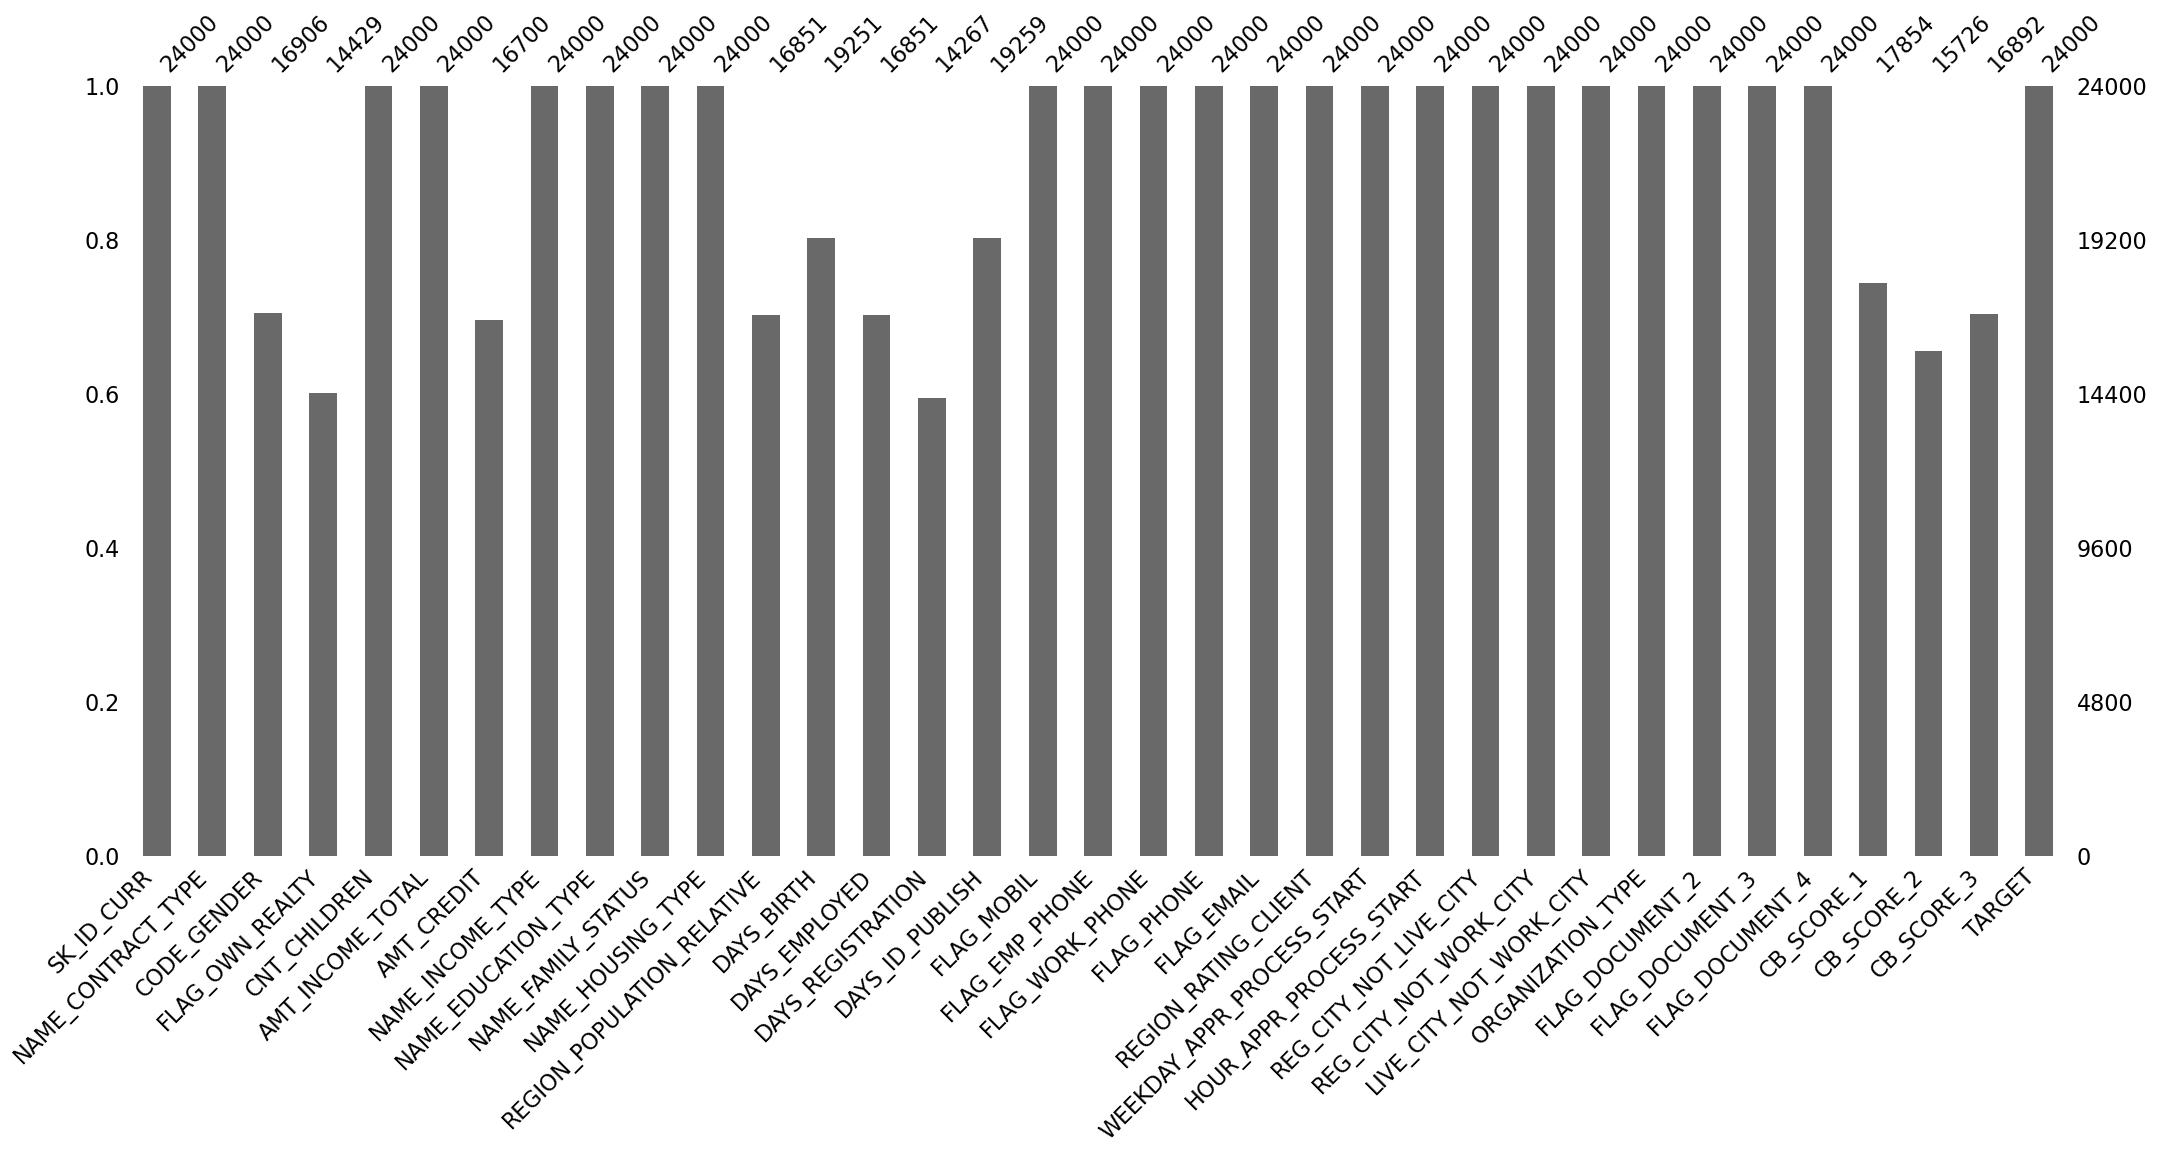

In [6]:
missingno.bar(df_master)

### 2. dtype select & describe info

In [7]:
df_master.dtypes.value_counts()

int64      16
float64    10
object      9
dtype: int64

In [8]:
df_master.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_REALTY                2
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

* ORGANIZATION_TYPE 의 구분되는 값이 58개로 보이며, 향후 인코딩시 주의가 필요해 보임

In [9]:
df_master.select_dtypes('float').describe()

AMT_INCOME_TOTAL    AMT_CREDIT  REGION_POPULATION_RELATIVE  \
count      2.400000e+04  1.670000e+04                16851.000000   
mean       1.725182e+05  5.954254e+05                    0.020989   
std        7.604604e+05  3.988125e+05                    0.014061   
min        2.700000e+04  4.500000e+04                    0.000290   
25%        1.125000e+05  2.700000e+05                    0.010006   
50%        1.440000e+05  5.108535e+05                    0.018850   
75%        2.025000e+05  8.086500e+05                    0.028663   
max        1.170000e+08  4.050000e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  19251.000000   16851.000000       14267.000000     19259.000000   
mean  -16026.527453   63041.865112       -5016.930118     -2990.491926   
std     4365.267387  140634.051334        3541.618561      1513.089981   
min   -25197.000000  -16852.000000      -24672.000000     -6263.000000   
25%   -19647.000000   -2772.000000       -7537.000000     -4308.000000   
50%   -15731.000000   -1206.000000       -4521.000000     -3251.000000   
75%   -12376.500000    -299.000000       -2050.500000     -1717.500000   
max    -7688.000000  365243.000000           0.000000         0.000000   

         CB_SCORE_1    CB_SCORE_2    CB_SCORE_3  
count  17854.000000  15726.000000  16892.000000  
mean      49.942357     58.061950     60.368432  
std       13.095990     10.752802      8.682502  
min        0.000000      0.000000     28.967147  
25%       41.026337     50.801249     54.410659  
50%       49.894802     57.935604     59.971539  
75%       58.919900     65.184718     66.097419  
max       99.870790     98.987986    100.000000

* DAYS_BIRTH / DAYS_EMPLOYED / DAYS_REGISTRATION / DAYS_ID_PUBLISH 값들이 매우 크면서 음수.
* 특이하게 DAYS_EMPLOYED의 MAX 값만 양수이면서 지나치게 큼.
* 향후 분석시 위 부분을 고려하여 처리 필요.

In [10]:
df_master.select_dtypes('int').describe()

SK_ID_CURR  CNT_CHILDREN  FLAG_MOBIL  FLAG_EMP_PHONE  \
count   24000.000000  24000.000000     24000.0    24000.000000   
mean   277994.337708      0.418083         1.0        0.821083   
std    102778.811383      0.727194         0.0        0.383291   
min    100002.000000      0.000000         1.0        0.000000   
25%    188705.250000      0.000000         1.0        1.000000   
50%    277908.500000      0.000000         1.0        1.000000   
75%    366537.250000      1.000000         1.0        1.000000   
max    456228.000000      7.000000         1.0        1.000000   

       FLAG_WORK_PHONE    FLAG_PHONE    FLAG_EMAIL  REGION_RATING_CLIENT  \
count     24000.000000  24000.000000  24000.000000          24000.000000   
mean          0.203667      0.280167      0.055250              2.051833   
std           0.402732      0.449090      0.228472              0.511525   
min           0.000000      0.000000      0.000000              1.000000   
25%           0.000000      0.000000      0.000000              2.000000   
50%           0.000000      0.000000      0.000000              2.000000   
75%           0.000000      1.000000      0.000000              2.000000   
max           1.000000      1.000000      1.000000              3.000000   

       HOUR_APPR_PROCESS_START  REG_CITY_NOT_LIVE_CITY  \
count             24000.000000            24000.000000   
mean                 12.063542                0.076583   
std                   3.254002                0.265935   
min                   0.000000                0.000000   
25%                  10.000000                0.000000   
50%                  12.000000                0.000000   
75%                  14.000000                0.000000   
max                  23.000000                1.000000   

       REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  FLAG_DOCUMENT_2  \
count            24000.000000             24000.000000     24000.000000   
mean                 0.232042                 0.181750         0.000167   
std                  0.422144                 0.385646         0.012909   
min                  0.000000                 0.000000         0.000000   
25%                  0.000000                 0.000000         0.000000   
50%                  0.000000                 0.000000         0.000000   
75%                  0.000000                 0.000000         0.000000   
max                  1.000000                 1.000000         1.000000   

       FLAG_DOCUMENT_3  FLAG_DOCUMENT_4        TARGET  
count     24000.000000     24000.000000  24000.000000  
mean          0.709292         0.000125      0.083042  
std           0.454099         0.011180      0.275951  
min           0.000000         0.000000      0.000000  
25%           0.000000         0.000000      0.000000  
50%           1.000000         0.000000      0.000000  
75%           1.000000         0.000000      0.000000  
max           1.000000         1.000000      1.000000

* FLAG_EMP_PHONE은 모든 고객이 1이므로 Master Frame에서 제외 가능해 보임
* CNT_CHILDREN은 최소값 0 , 최대값 7 이지만 75% 구간이 1인 것으로 보아 실제로는 0,1 이 많은것으로 예측해 볼수있음.
* 0과 1로 구분되어진 데이터들이 많으며 각각 Y/N을 나타내는 것으로 보임

### 3. Data Visualization

In [11]:
# 시각화 함수 선언

def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = df1[feature].value_counts()
    df_temp = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
   # Calculate the percentage of target=1 per category value
    cat_perc = df1[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)   
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts", data=df_temp)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    s = sns.barplot(ax=ax2, x = feature, y='TARGET',data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
        
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [12]:
def hist_stats(x):
    
    plt.style.use('fivethirtyeight')

    plt.hist(df1[x] , edgecolor = 'k', bins = 25)
    plt.title(x + ' of Client'); plt.xlabel(x); plt.ylabel('Count');

### 1. Effect of Organization_Type on Repayment

* ORGANIZATION_TYPE 유형의 unique 한 값의 결과가 58개 이므로 특징이 미비하다면 분석 대상에서 제외 고려 후 진행.

In [13]:
df1 = df_master

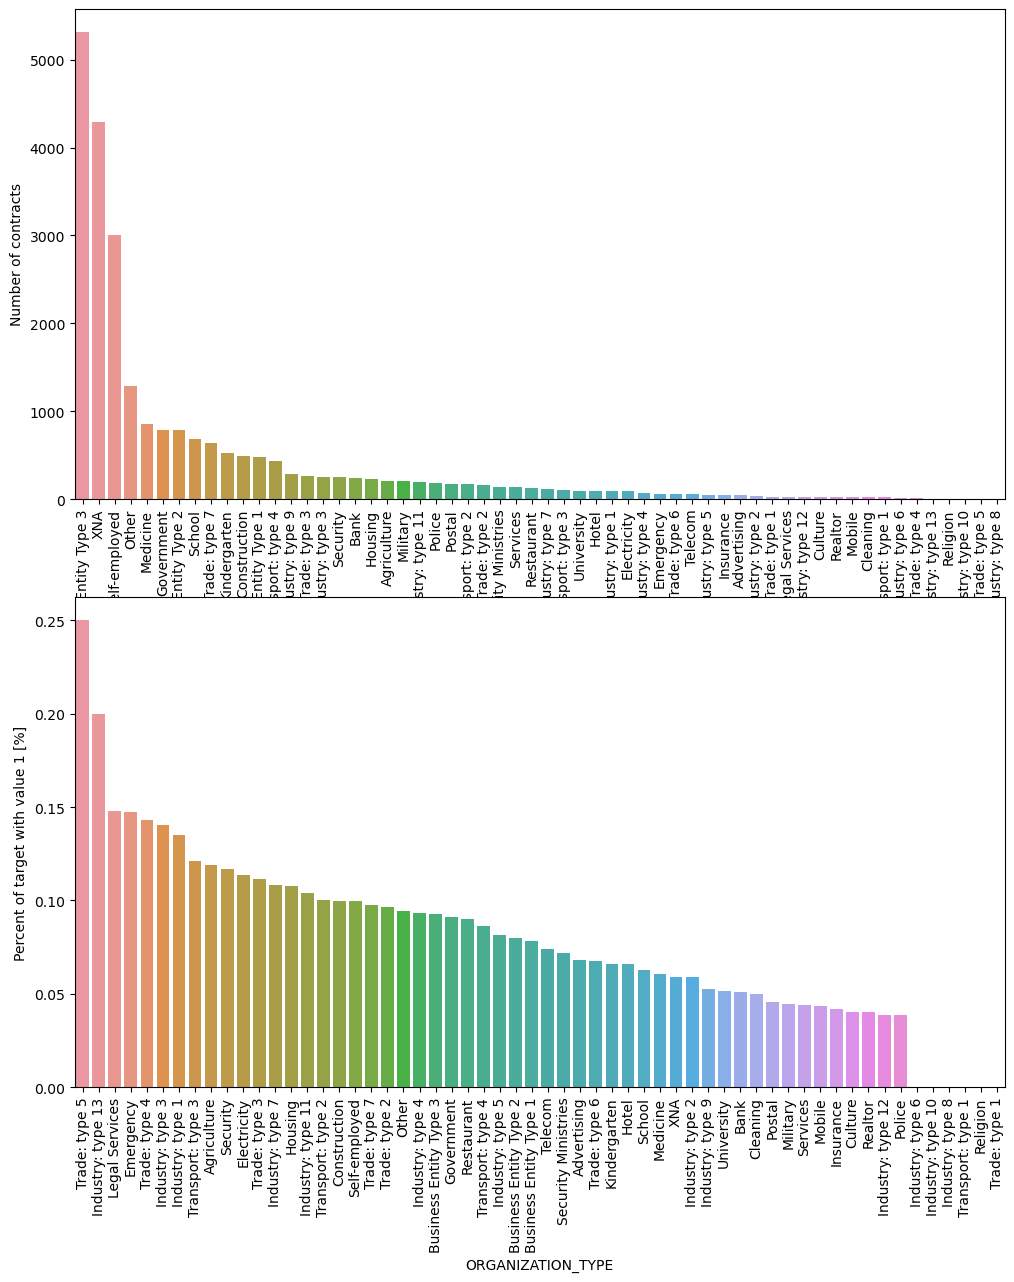

In [14]:
plot_stats('ORGANIZATION_TYPE',True, False)

* 직업별 확인결과 Trade: type5, Industry: type13 직업군에 대해 연체 비율이 높은것을 알수있음.
* BUSINESS ENTITY TYPE 3 , XNA, SELF_EMPLOYED 직업군은 대출신청건에 비해 연체비율이 낮음.
* 58개의 유형을 전부 사용하는 대신 특정 컬럼인지 체크한 값을 구성 검토

### 2. Effect of Code_Gender on Repayment

In [15]:
df_master['CODE_GENDER'].value_counts()

F      11211
M       5694
XNA        1
Name: CODE_GENDER, dtype: int64

In [16]:
df_master.loc[(df_master['CODE_GENDER'] == 'XNA'), 'CODE_GENDER'] = np.NaN

In [17]:
df_master['CODE_GENDER'].value_counts()

F    11211
M     5694
Name: CODE_GENDER, dtype: int64

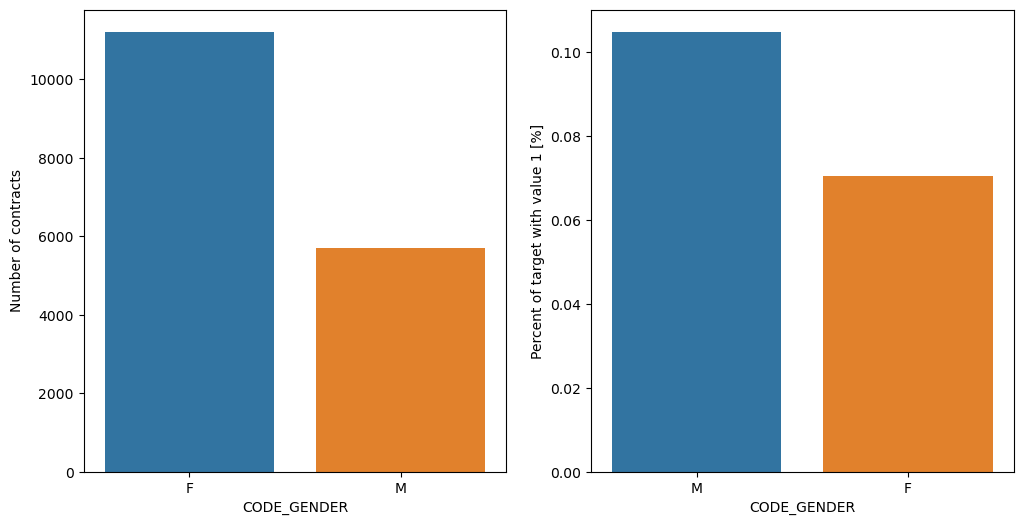

In [18]:
plot_stats('CODE_GENDER')

* 대출은 여성이 더 많이 받으나, 연체자의 비중은 남성 대출자 그룹에서 높은 것으로 확인

### 3. Effect on Days_Data on Repayment

In [19]:
df1 = df_master

* Days 데이터 유형은 현재 시점에서 전일 데이터를 의미함
* 실제 나이값으로 변환하여 분석 진행

In [20]:
df1['DAYS_BIRTH'] = df1['DAYS_BIRTH'] * -1 / 365
df1['DAYS_EMPLOYED'] = df1['DAYS_EMPLOYED'] * -1 / 365
df1['DAYS_REGISTRATION'] = df1['DAYS_REGISTRATION'] * -1 / 365
df1['DAYS_ID_PUBLISH'] = df1['DAYS_ID_PUBLISH'] * -1 / 365

#### 3-1  Effect on DAYS_BIRTH

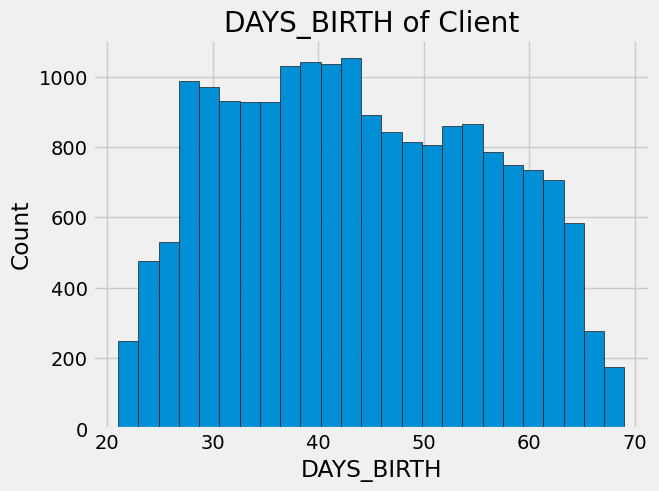

In [21]:
hist_stats('DAYS_BIRTH')

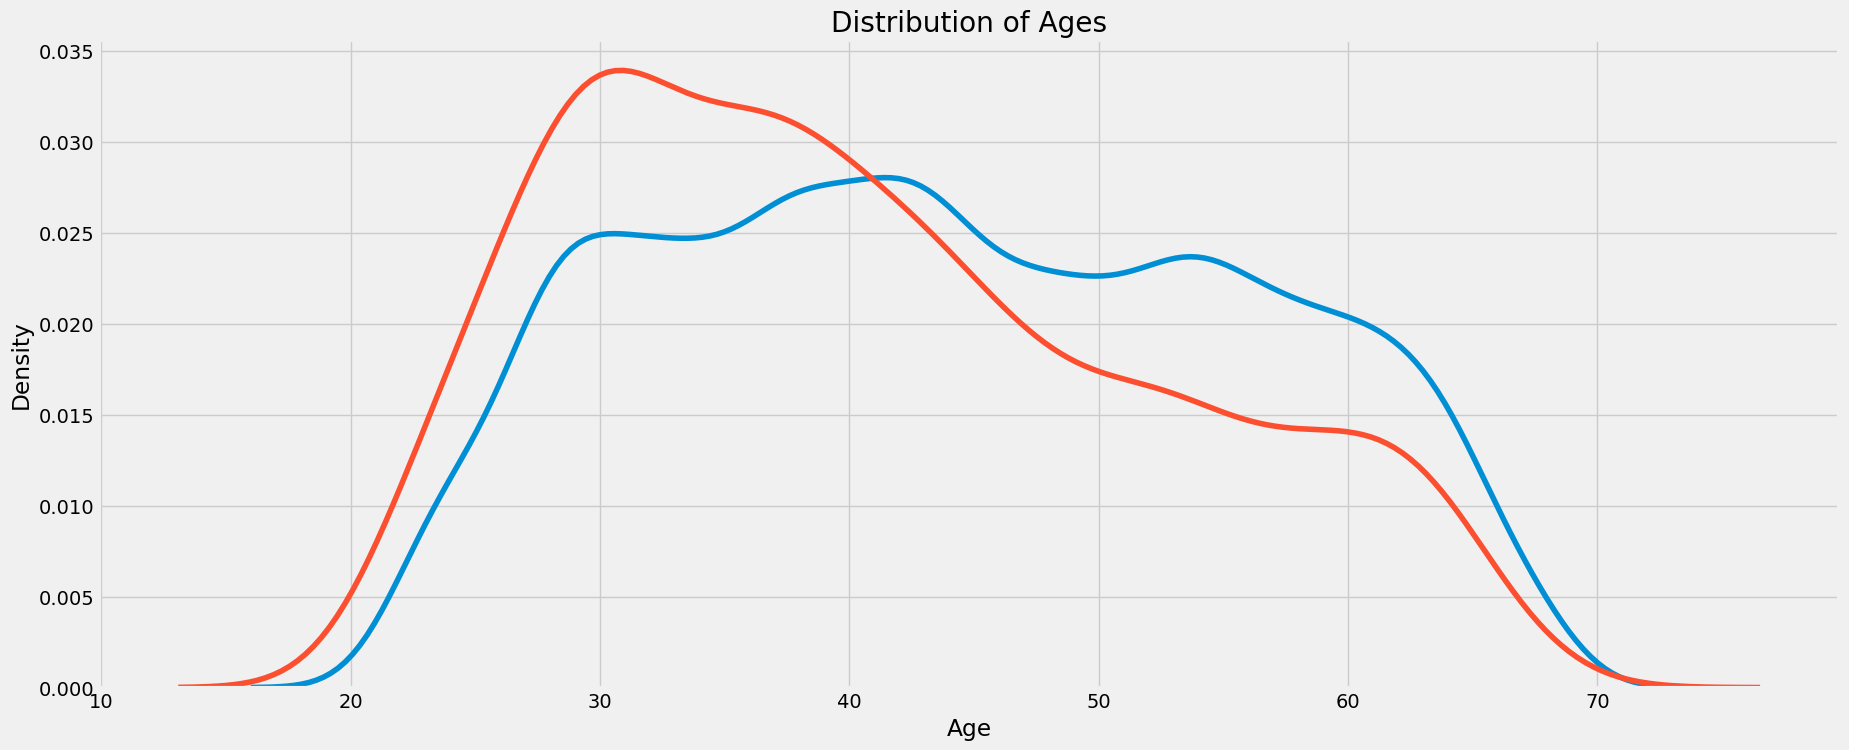

In [22]:
plt.figure(figsize = (20, 8))
sns.kdeplot(df_master.loc[df1['TARGET'] == 0, 'DAYS_BIRTH'], label = 'target == 0')
sns.kdeplot(df_master.loc[df1['TARGET'] == 1, 'DAYS_BIRTH'], label = 'target == 1')
plt.xlabel('Age'); plt.ylabel('Density'); plt.title('Distribution of Ages');

* Blue : target = 0
* Red  : target = 1

In [23]:
# Age information into a separate dataframe
age_data = df1[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(10, 70, num = 7))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1   25.920548    25.920548  (20.0, 30.0]
1       0   52.180822    52.180822  (50.0, 60.0]
2       0   35.427397    35.427397  (30.0, 40.0]
3       0   30.920548    30.920548  (30.0, 40.0]
4       0         NaN          NaN           NaN
5       0   50.038356    50.038356  (50.0, 60.0]
6       0   28.693151    28.693151  (20.0, 30.0]
7       0   43.586301    43.586301  (40.0, 50.0]
8       0         NaN          NaN           NaN
9       0   59.213699    59.213699  (50.0, 60.0]

In [24]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET  DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                   
(10.0, 20.0]       NaN         NaN          NaN
(20.0, 30.0]  0.119706   26.656895    26.656895
(30.0, 40.0]  0.105055   35.069468    35.069468
(40.0, 50.0]  0.074464   44.693542    44.693542
(50.0, 60.0]  0.057902   54.881131    54.881131
(60.0, 70.0]  0.060406   63.308937    63.308937

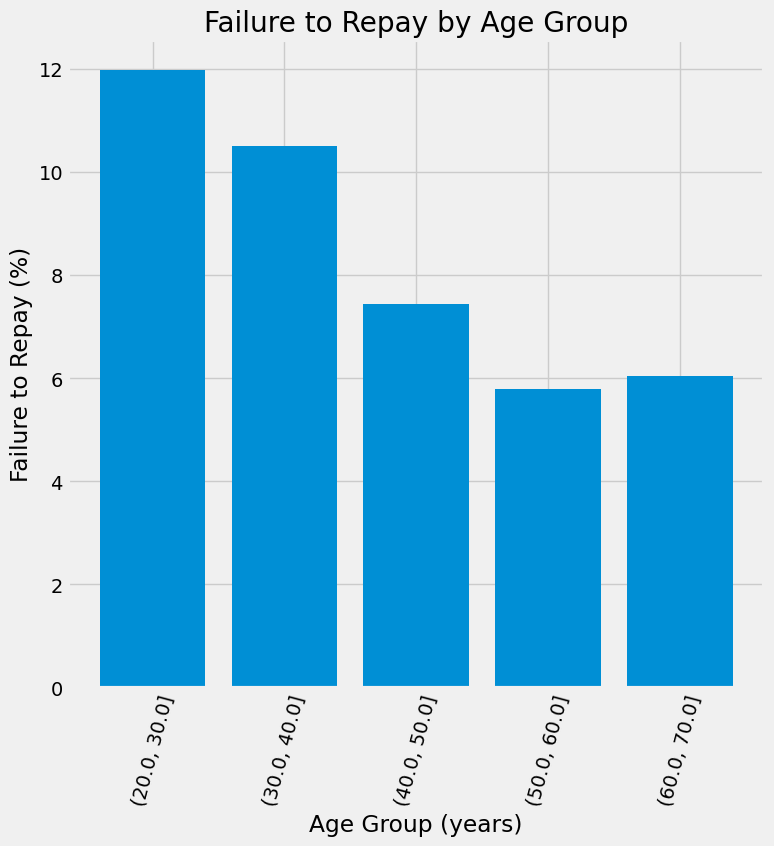

In [25]:
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

* 나이가 어릴수록 연체비율이 높은것을확인
* 나이와 연체에 대한 상관관계가 존재해보임.

#### 3-2  Effect on DAYS_EMPLOYED

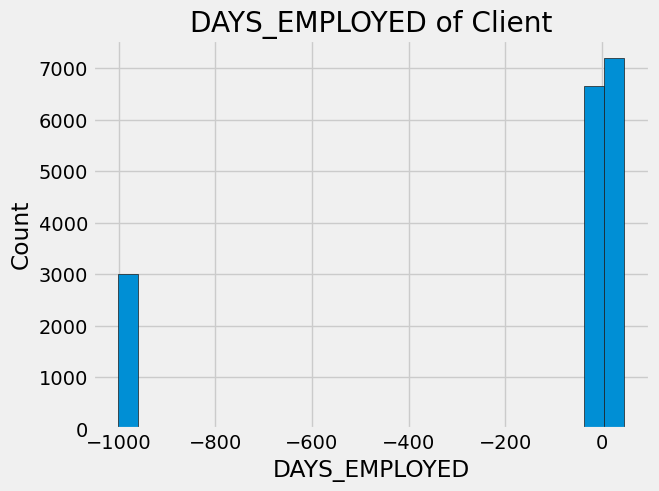

In [26]:
hist_stats('DAYS_EMPLOYED')

In [27]:
df1.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   24000.000000  24000.000000      2.400000e+04  1.670000e+04   
mean   277994.337708      0.418083      1.725182e+05  5.954254e+05   
std    102778.811383      0.727194      7.604604e+05  3.988125e+05   
min    100002.000000      0.000000      2.700000e+04  4.500000e+04   
25%    188705.250000      0.000000      1.125000e+05  2.700000e+05   
50%    277908.500000      0.000000      1.440000e+05  5.108535e+05   
75%    366537.250000      1.000000      2.025000e+05  8.086500e+05   
max    456228.000000      7.000000      1.170000e+08  4.050000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
count                16851.000000  19251.000000   16851.000000   
mean                     0.020989     43.908294    -172.717439   
std                      0.014061     11.959637     385.298771   
min                      0.000290     21.063014   -1000.665753   
25%                      0.010006     33.908219       0.819178   
50%                      0.018850     43.098630       3.304110   
75%                      0.028663     53.827397       7.594521   
max                      0.072508     69.032877      46.169863   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  ...  \
count       14267.000000     19259.000000     24000.0  ...   
mean           13.745014         8.193129         1.0  ...   
std             9.703065         4.145452         0.0  ...   
min            -0.000000        -0.000000         1.0  ...   
25%             5.617808         4.705479         1.0  ...   
50%            12.386301         8.906849         1.0  ...   
75%            20.649315        11.802740         1.0  ...   
max            67.594521        17.158904         1.0  ...   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count            24000.000000            24000.000000   
mean                 0.076583                0.232042   
std                  0.265935                0.422144   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max                  1.000000                1.000000   

       LIVE_CITY_NOT_WORK_CITY  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
count             24000.000000     24000.000000     24000.000000   
mean                  0.181750         0.000167         0.709292   
std                   0.385646         0.012909         0.454099   
min                   0.000000         0.000000         0.000000   
25%                   0.000000         0.000000         0.000000   
50%                   0.000000         0.000000         1.000000   
75%                   0.000000         0.000000         1.000000   
max                   1.000000         1.000000         1.000000   

       FLAG_DOCUMENT_4    CB_SCORE_1    CB_SCORE_2    CB_SCORE_3        TARGET  
count     24000.000000  17854.000000  15726.000000  16892.000000  24000.000000  
mean          0.000125     49.942357     58.061950     60.368432      0.083042  
std           0.011180     13.095990     10.752802      8.682502      0.275951  
min           0.000000      0.000000      0.000000     28.967147      0.000000  
25%           0.000000     41.026337     50.801249     54.410659      0.000000  
50%           0.000000     49.894802     57.935604     59.971539      0.000000  
75%           0.000000     58.919900     65.184718     66.097419      0.000000  
max           1.000000     99.870790     98.987986    100.000000      1.000000  

[8 rows x 26 columns]

* 데이터 describe 과정에서 발견했던 DAYS_EMPLOYED 값들이 지나치게 편차가 있는것을 확인
* 음수가된 고객은 직장이 없거나 퇴직한 고객으로 예측해 볼 수 있음.
* 더 나은 시각화를 위해 해당값을 -10으로 변경

In [28]:
df1.loc[(df1['DAYS_EMPLOYED'] < 0), 'DAYS_EMPLOYED'] = -10

In [29]:
df1.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   24000.000000  24000.000000      2.400000e+04  1.670000e+04   
mean   277994.337708      0.418083      1.725182e+05  5.954254e+05   
std    102778.811383      0.727194      7.604604e+05  3.988125e+05   
min    100002.000000      0.000000      2.700000e+04  4.500000e+04   
25%    188705.250000      0.000000      1.125000e+05  2.700000e+05   
50%    277908.500000      0.000000      1.440000e+05  5.108535e+05   
75%    366537.250000      1.000000      2.025000e+05  8.086500e+05   
max    456228.000000      7.000000      1.170000e+08  4.050000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
count                16851.000000  19251.000000   16851.000000   
mean                     0.020989     43.908294       3.592964   
std                      0.014061     11.959637       8.593928   
min                      0.000290     21.063014     -10.000000   
25%                      0.010006     33.908219       0.819178   
50%                      0.018850     43.098630       3.304110   
75%                      0.028663     53.827397       7.594521   
max                      0.072508     69.032877      46.169863   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  ...  \
count       14267.000000     19259.000000     24000.0  ...   
mean           13.745014         8.193129         1.0  ...   
std             9.703065         4.145452         0.0  ...   
min            -0.000000        -0.000000         1.0  ...   
25%             5.617808         4.705479         1.0  ...   
50%            12.386301         8.906849         1.0  ...   
75%            20.649315        11.802740         1.0  ...   
max            67.594521        17.158904         1.0  ...   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count            24000.000000            24000.000000   
mean                 0.076583                0.232042   
std                  0.265935                0.422144   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max                  1.000000                1.000000   

       LIVE_CITY_NOT_WORK_CITY  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
count             24000.000000     24000.000000     24000.000000   
mean                  0.181750         0.000167         0.709292   
std                   0.385646         0.012909         0.454099   
min                   0.000000         0.000000         0.000000   
25%                   0.000000         0.000000         0.000000   
50%                   0.000000         0.000000         1.000000   
75%                   0.000000         0.000000         1.000000   
max                   1.000000         1.000000         1.000000   

       FLAG_DOCUMENT_4    CB_SCORE_1    CB_SCORE_2    CB_SCORE_3        TARGET  
count     24000.000000  17854.000000  15726.000000  16892.000000  24000.000000  
mean          0.000125     49.942357     58.061950     60.368432      0.083042  
std           0.011180     13.095990     10.752802      8.682502      0.275951  
min           0.000000      0.000000      0.000000     28.967147      0.000000  
25%           0.000000     41.026337     50.801249     54.410659      0.000000  
50%           0.000000     49.894802     57.935604     59.971539      0.000000  
75%           0.000000     58.919900     65.184718     66.097419      0.000000  
max           1.000000     99.870790     98.987986    100.000000      1.000000  

[8 rows x 26 columns]

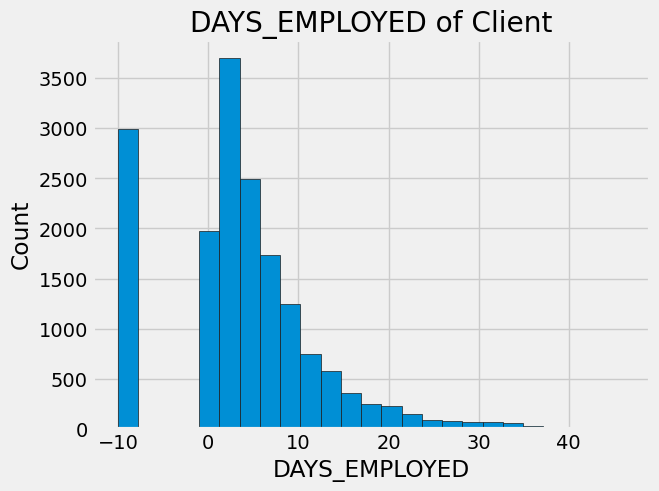

In [30]:
hist_stats('DAYS_EMPLOYED')

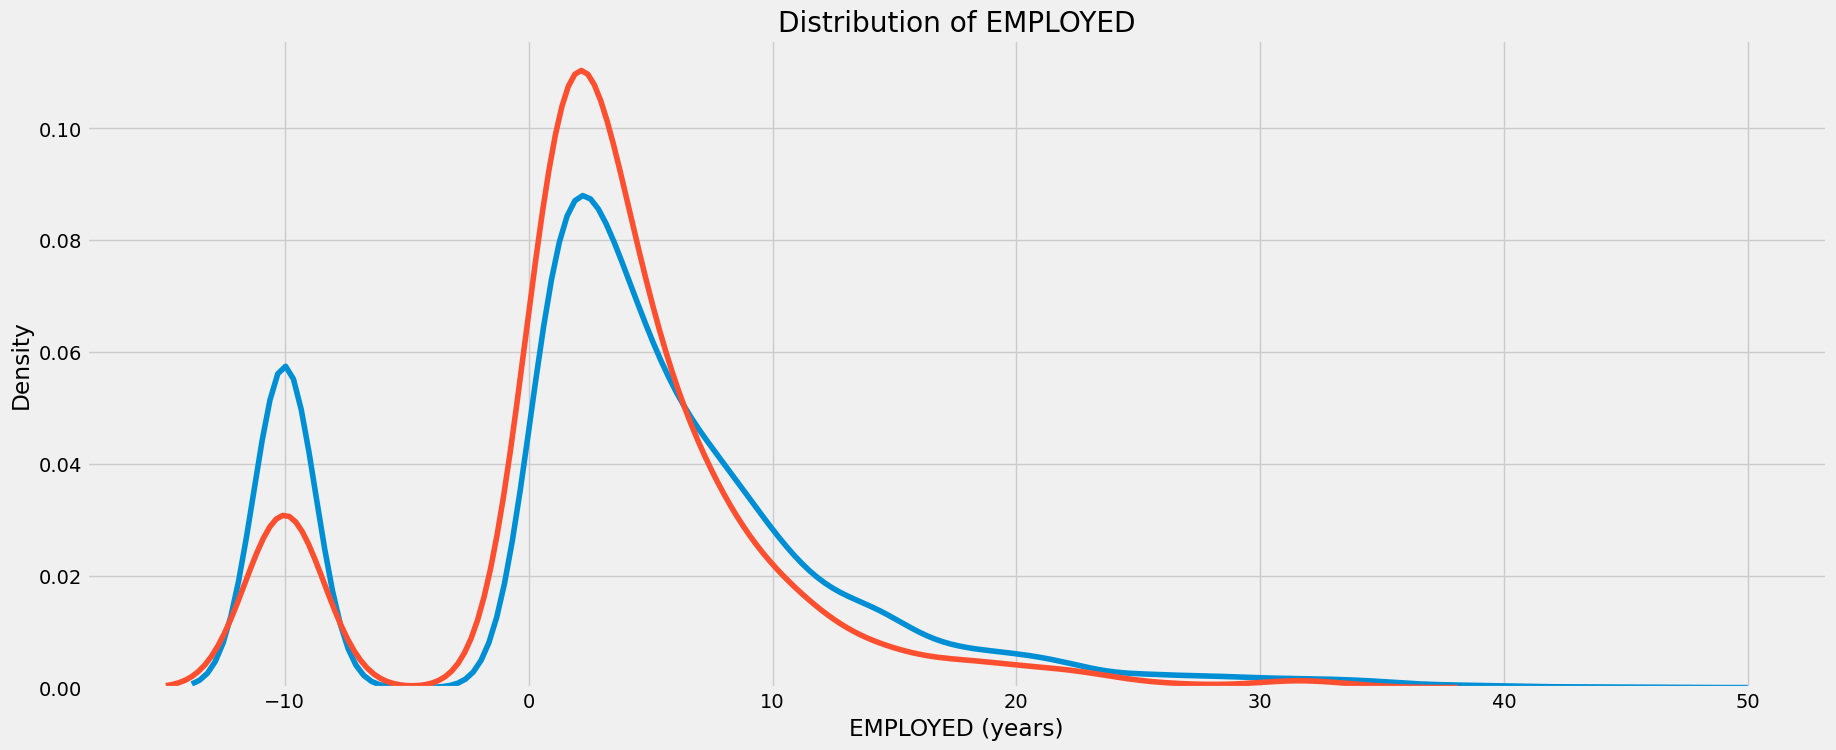

In [31]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'DAYS_EMPLOYED'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'DAYS_EMPLOYED'], label = 'target == 1')

plt.xlabel('EMPLOYED (years)'); plt.ylabel('Density'); plt.title('Distribution of EMPLOYED');

* 1. 은퇴한 고객들의 연체비율은 상대적으로 낮음
* 2. 직장근무 년수가 낮을수록 연체비율이 높음

#### 3-3  Effect on DAYS_REGISTRATION

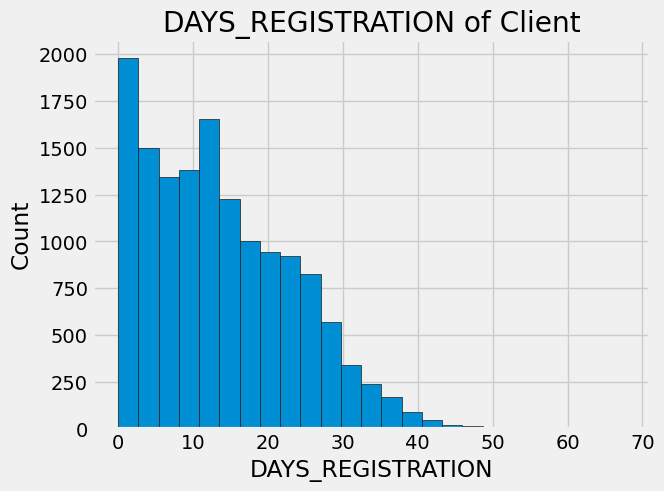

In [32]:
hist_stats('DAYS_REGISTRATION')

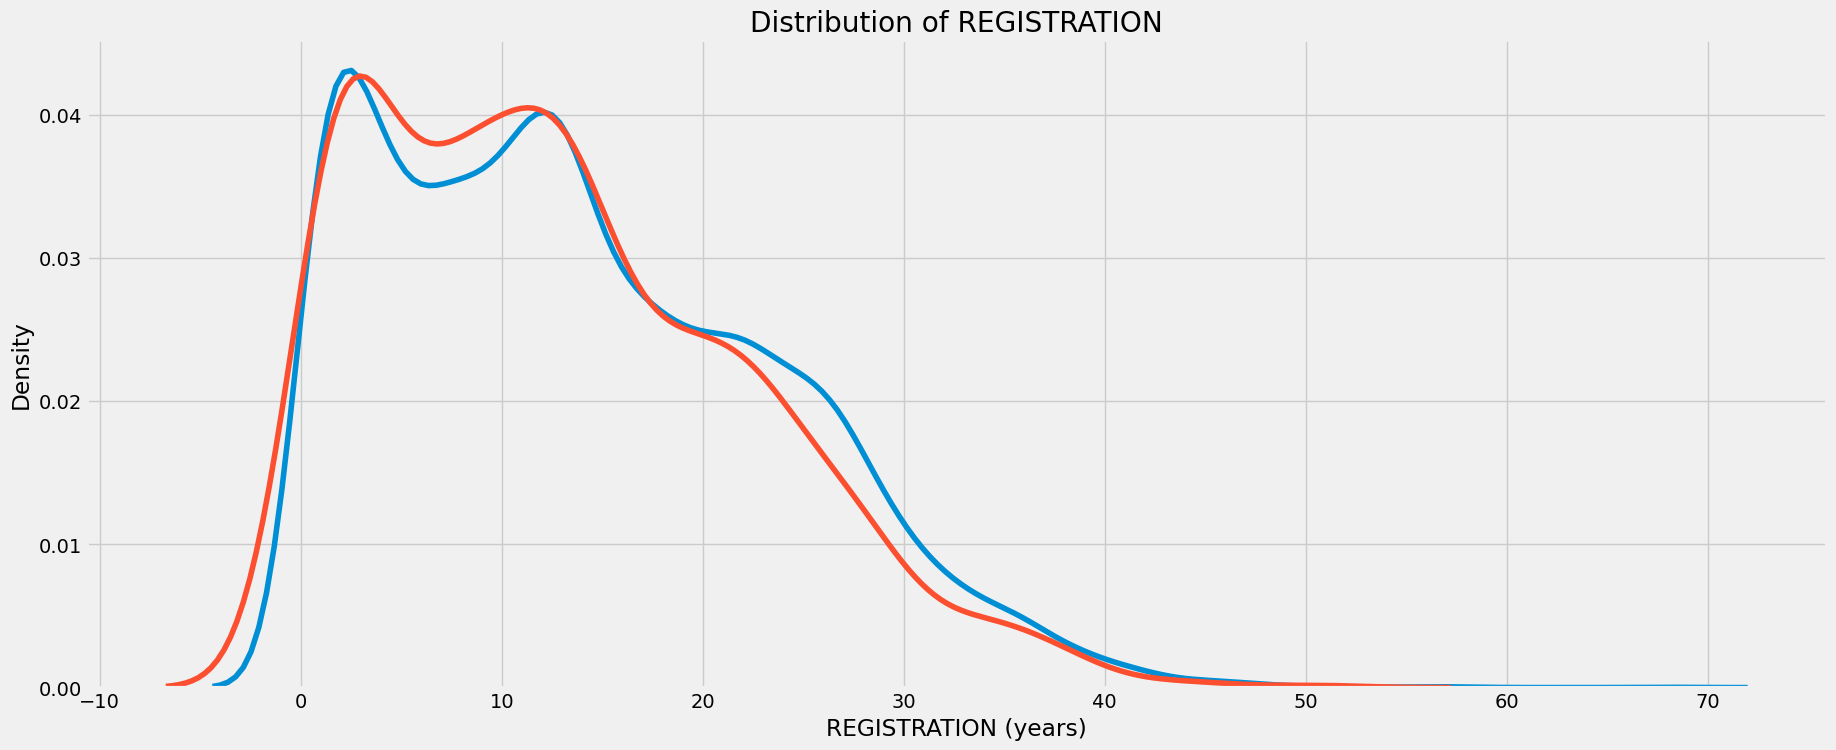

In [33]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'DAYS_REGISTRATION'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'DAYS_REGISTRATION'], label = 'target == 1')

plt.xlabel('REGISTRATION (years)'); plt.ylabel('Density'); plt.title('Distribution of REGISTRATION');

* 대출 신청일과 근접할수록 고객 정보 변경이 많이 일어나는 것으로 보임
* 비교적 고객 정보 변경이 최근에 발생할수록 연체비율이 높음.
* 젊은 고객들의 신규 유입 또는 대출실행을 위한 고객정보 최신화로 보임
* 최신 고객정보를 장시간 유지하는 고객의 연체비율은 비교적 낮아보임.
* 급하게 대출신청을 한 고객일수록 연체비율이 높지않을까 추측해봄.

#### 3-4  Effect on DAYS_ID_PUBLISH

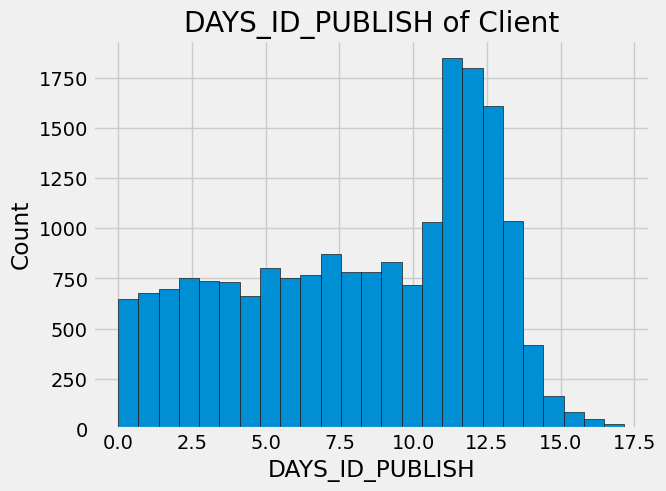

In [34]:
hist_stats('DAYS_ID_PUBLISH')

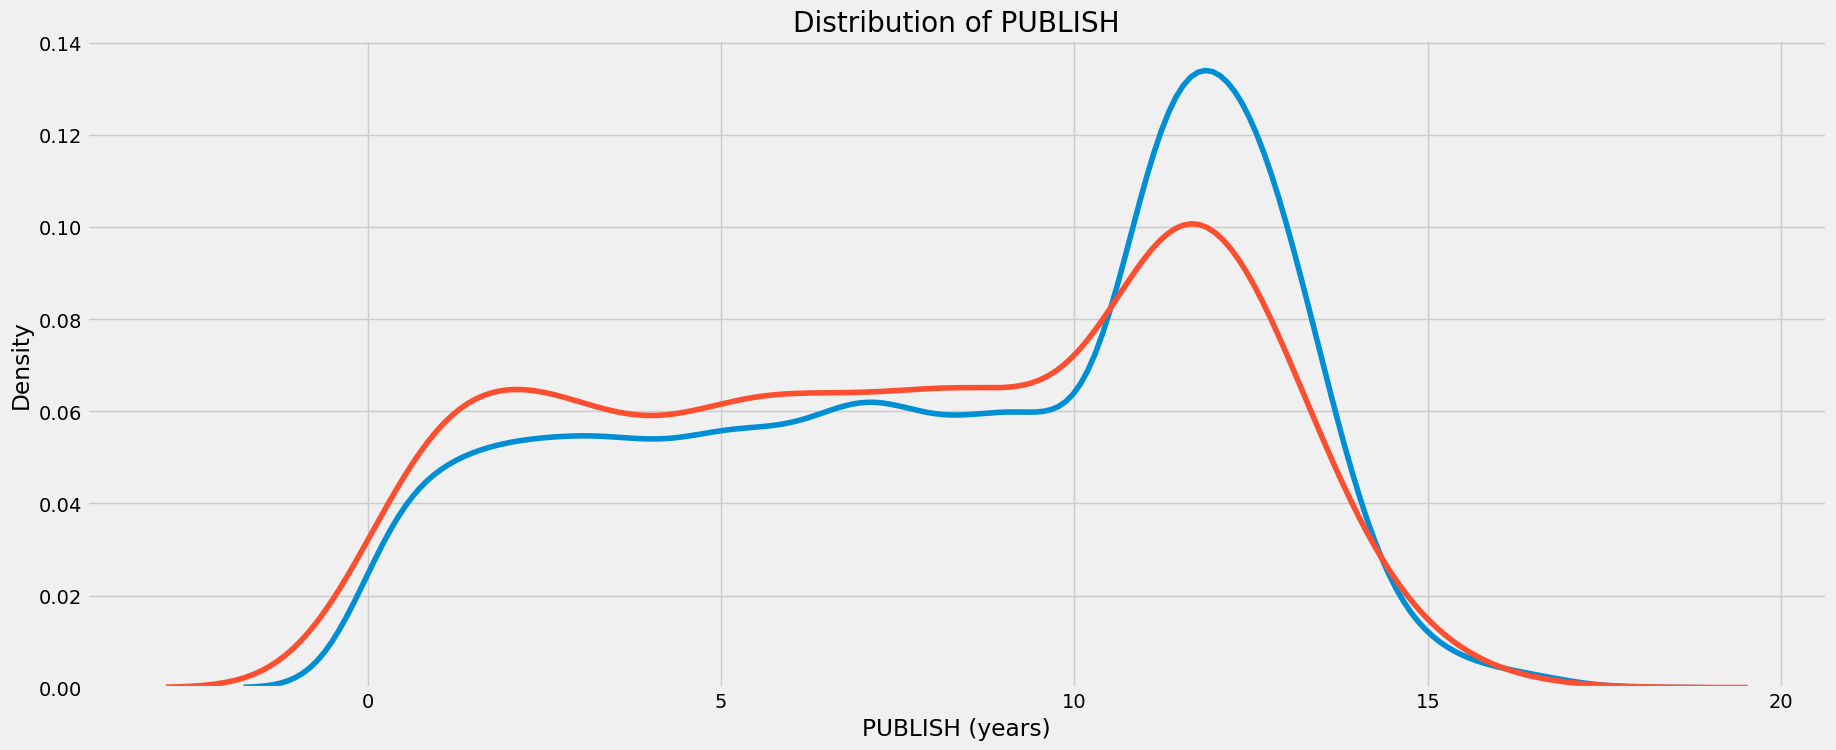

In [35]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'DAYS_ID_PUBLISH'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'DAYS_ID_PUBLISH'], label = 'target == 1')

plt.xlabel('PUBLISH (years)'); plt.ylabel('Density'); plt.title('Distribution of PUBLISH');

* 최종 결론 : 나이가 어리고 직장 근무 년수가 적고 고객정보 최신화의 시간이 최근일 수록 연체율이 높음을 확인
*             위의 모든 변수를 합하여 하나의 특징을 만들면 유의미한 값이 될수 있을거라고 판단.
*             향후 특성 생성시 반영해 보도록 함.    

### 4. Effect on CONTRACT_TYPE on Repayment

#### 4-1  Effect on NAME_CONTRACT_TYPE

In [36]:
df1 = df_master

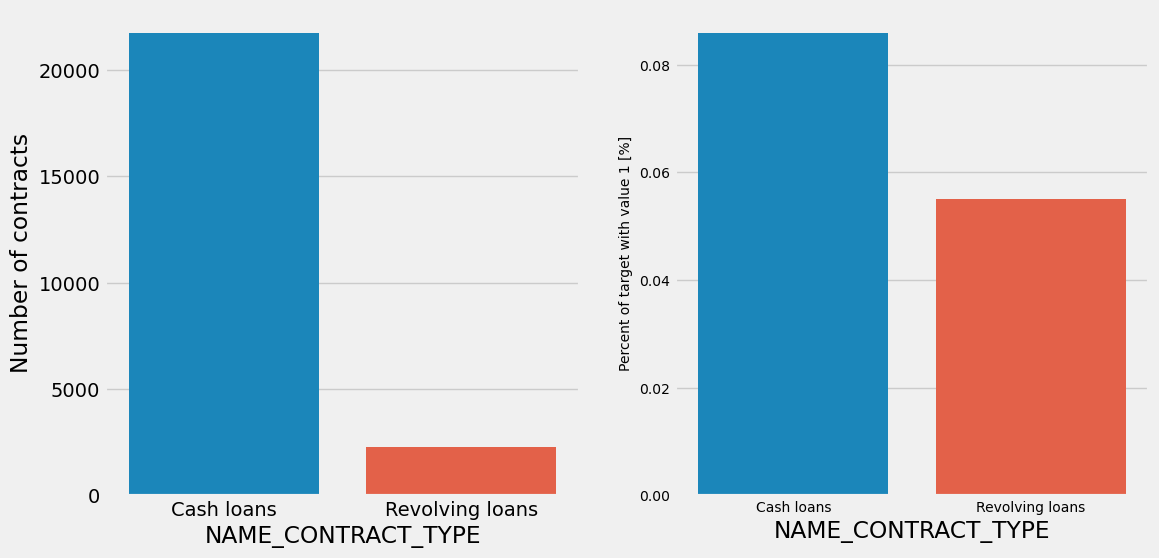

In [37]:
plot_stats('NAME_CONTRACT_TYPE',False, True)

In [38]:
df1['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         21733
Revolving loans     2267
Name: NAME_CONTRACT_TYPE, dtype: int64

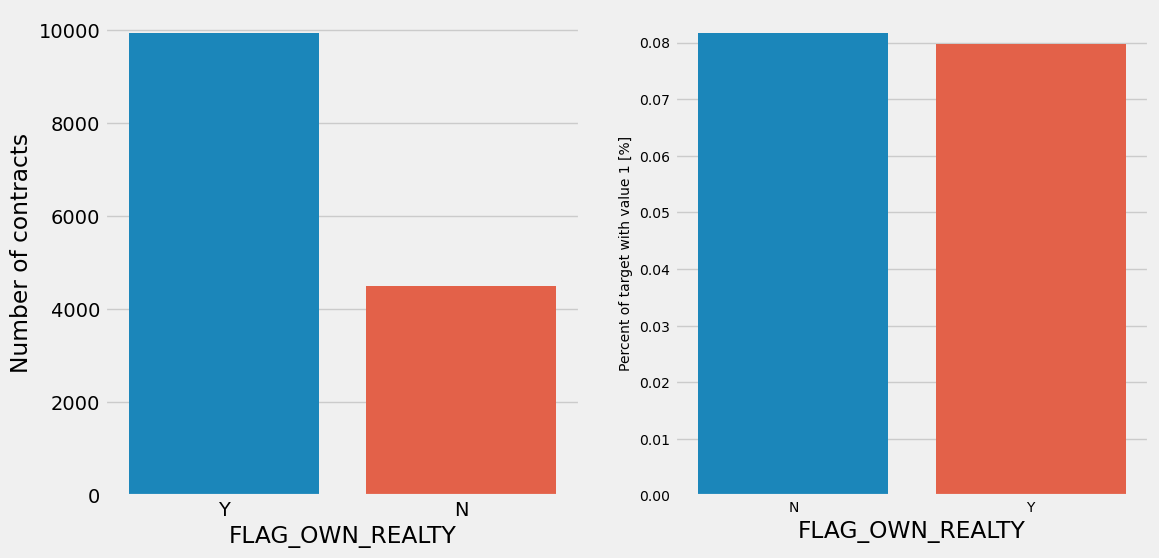

In [39]:
plot_stats('FLAG_OWN_REALTY',False, True)

### 5. Effect of CB_SCORE on Repayment

In [40]:
cb_data = df1[['TARGET', 'CB_SCORE_1', 'CB_SCORE_2', 'CB_SCORE_3', 'DAYS_BIRTH']]
cb_data_corrs = cb_data.corr()
cb_data_corrs

TARGET  CB_SCORE_1  CB_SCORE_2  CB_SCORE_3  DAYS_BIRTH
TARGET      1.000000    0.129019   -0.011226   -0.018678   -0.084192
CB_SCORE_1  0.129019    1.000000   -0.023349   -0.017150   -0.143115
CB_SCORE_2 -0.011226   -0.023349    1.000000    0.036829    0.159534
CB_SCORE_3 -0.018678   -0.017150    0.036829    1.000000    0.150138
DAYS_BIRTH -0.084192   -0.143115    0.159534    0.150138    1.000000

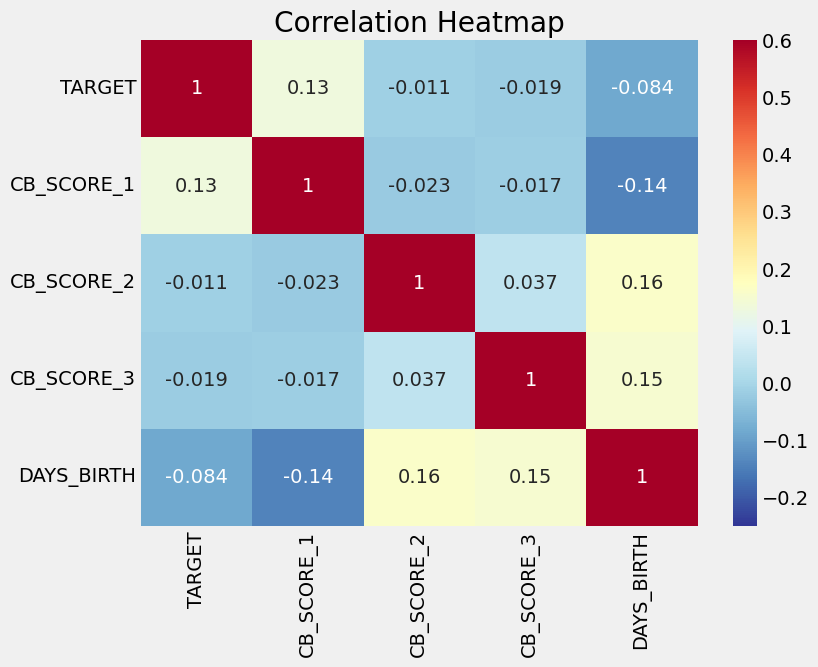

In [41]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(cb_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

* target과 cb_socre 상관관계 분석 시 cb_score_1을 제외하고는 큰 관련도가 없어 보임.(사실상 CB_SCORE 영향도 미비)
* cb_score와 days_birth 의 관계를 보면 cb_score_1은 나이가 많을수록 낮고, cb_score_2,3 는 나이가 많을수록 높은것으로 보임.

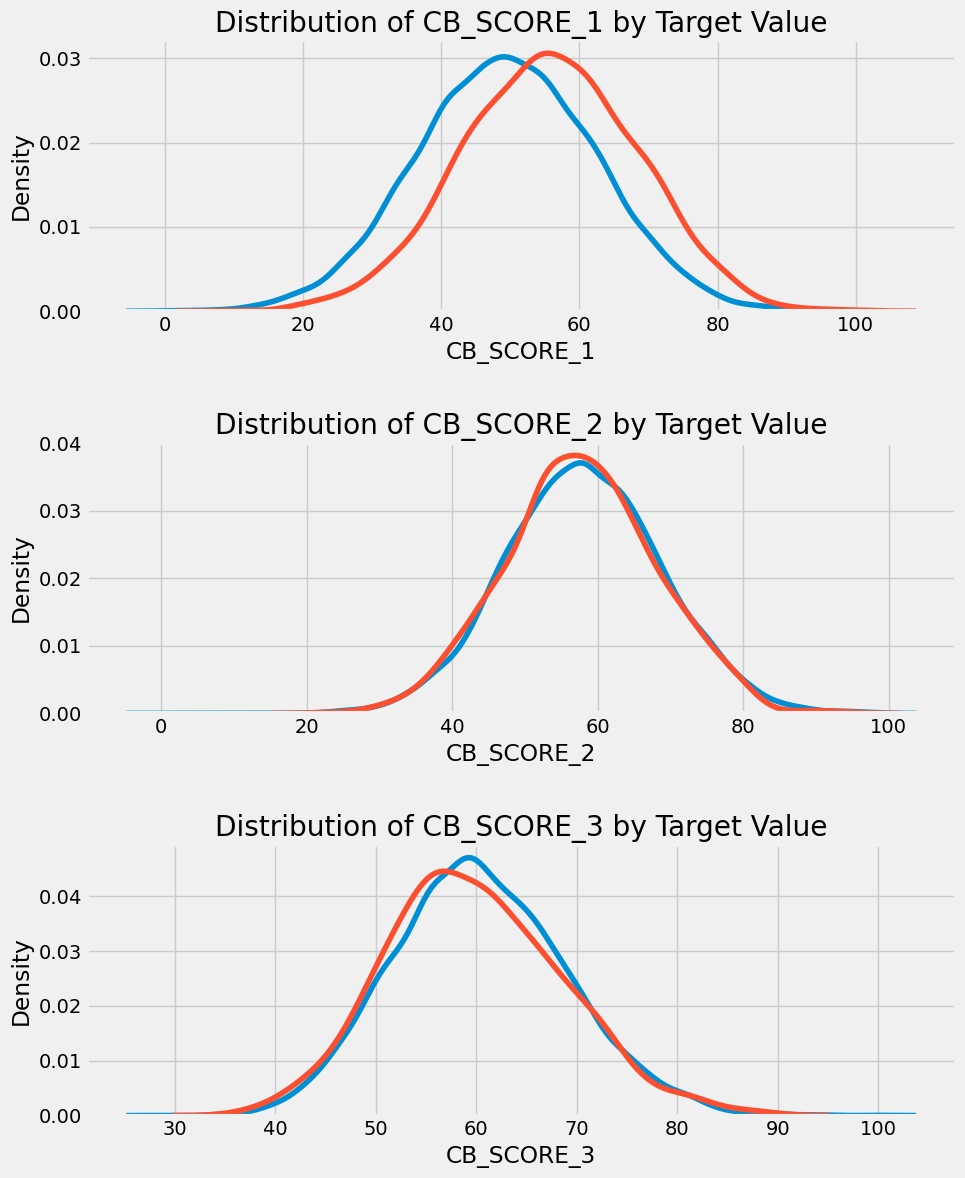

In [42]:
plt.figure(figsize = (10, 12))


for i, source in enumerate(['CB_SCORE_1', 'CB_SCORE_2', 'CB_SCORE_3']):
    
    plt.subplot(3, 1, i + 1)

    sns.kdeplot(df1.loc[df1['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(df1.loc[df1['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### 6. Effect of CNT_CHILDREN on Repayment

In [43]:
df1 = df_master

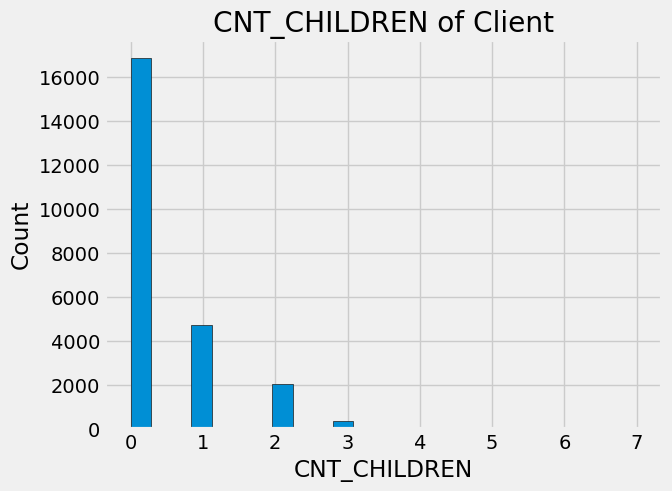

In [44]:
hist_stats('CNT_CHILDREN')

In [45]:
df1[['CNT_CHILDREN']].value_counts()

CNT_CHILDREN
0               16859
1                4703
2                2046
3                 341
4                  41
5                   9
7                   1
dtype: int64

In [46]:
cnt_child_groups = df1[['TARGET','CNT_CHILDREN']]
cnt_child_groups['CNT_CHILDREN_MEAN'] = df1['CNT_CHILDREN']
cnt_child_groups = cnt_child_groups.groupby('CNT_CHILDREN_MEAN').mean()
cnt_child_groups

TARGET  CNT_CHILDREN
CNT_CHILDREN_MEAN                        
0                  0.080728           0.0
1                  0.088667           1.0
2                  0.083578           2.0
3                  0.099707           3.0
4                  0.195122           4.0
5                  0.222222           5.0
7                  0.000000           7.0

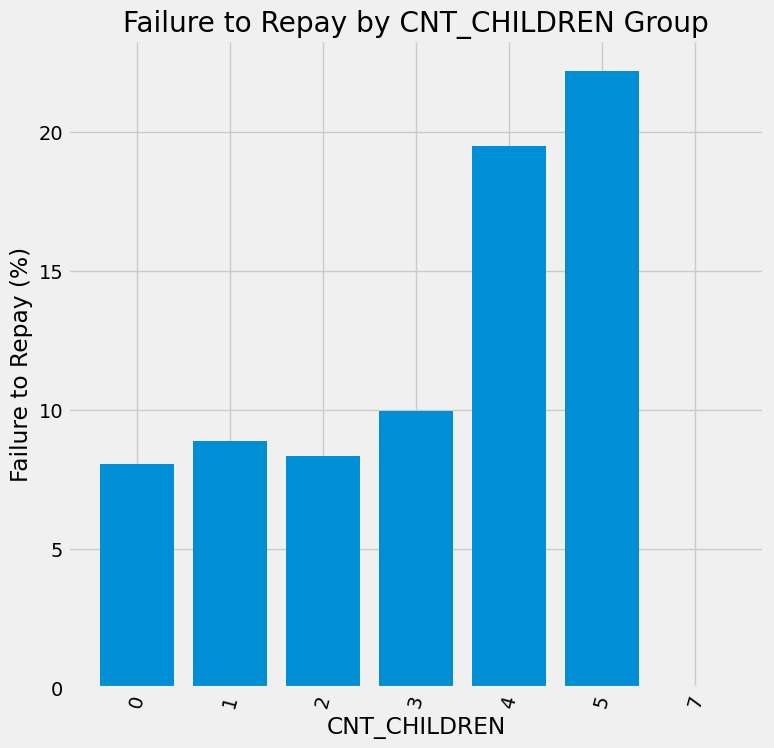

In [47]:
plt.figure(figsize = (8, 8))

plt.bar(cnt_child_groups.index.astype(str), 100 * cnt_child_groups['TARGET'])

plt.xticks(rotation = 75); plt.xlabel('CNT_CHILDREN'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by CNT_CHILDREN Group');

* 아이가 많을 수록 연체 비율이 증가함을 확인 가능
* CNT_CHILDREN 의 값이 7인 1건에 대해 인지하고 필요하면 이상치 제거 염두.

### 7. Effect of AMT_INCOME_TOTAL on Repayment

In [48]:
df1 = df_master

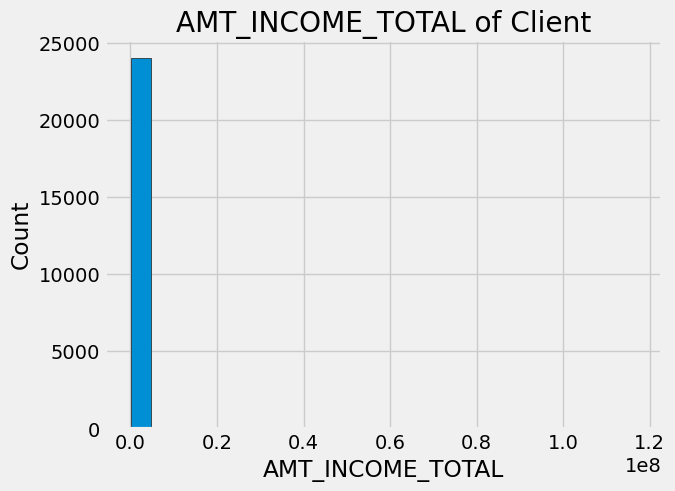

In [49]:
hist_stats('AMT_INCOME_TOTAL')

In [52]:
df1[['AMT_INCOME_TOTAL']].describe()

AMT_INCOME_TOTAL
count      2.400000e+04
mean       1.725182e+05
std        7.604604e+05
min        2.700000e+04
25%        1.125000e+05
50%        1.440000e+05
75%        2.025000e+05
max        1.170000e+08

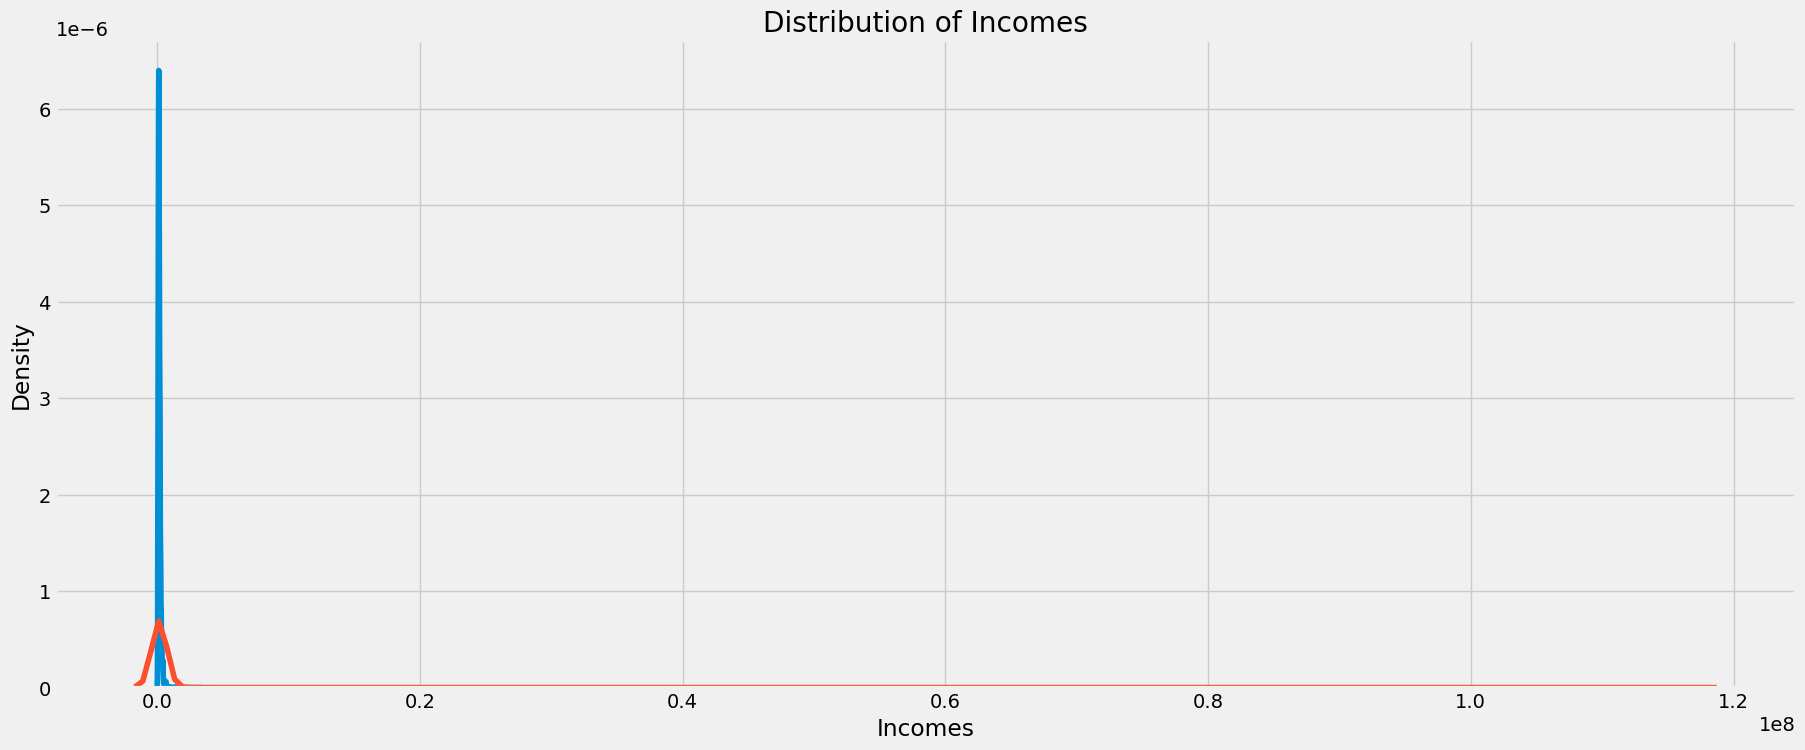

In [53]:
plt.figure(figsize = (20, 8))


sns.kdeplot(df_master.loc[df1['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label = 'target == 0')
sns.kdeplot(df_master.loc[df1['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label = 'target == 1')

plt.xlabel('Incomes'); plt.ylabel('Density'); plt.title('Distribution of Incomes');


In [54]:
df1['AMT_INCOME_TOTAL'].describe()

count    2.400000e+04
mean     1.725182e+05
std      7.604604e+05
min      2.700000e+04
25%      1.125000e+05
50%      1.440000e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [55]:
def income_grouping(x):
    if x < 100000 :
        return 10000
    elif x < 200000 :
        return 100000
    elif x < 300000. :
        return 200000 
    elif x < 400000 :
        return 300000
    elif x < 500000 :
        return 400000
    return 500000
df1['INCOME_GROUP'] = df1['AMT_INCOME_TOTAL'].apply(income_grouping)

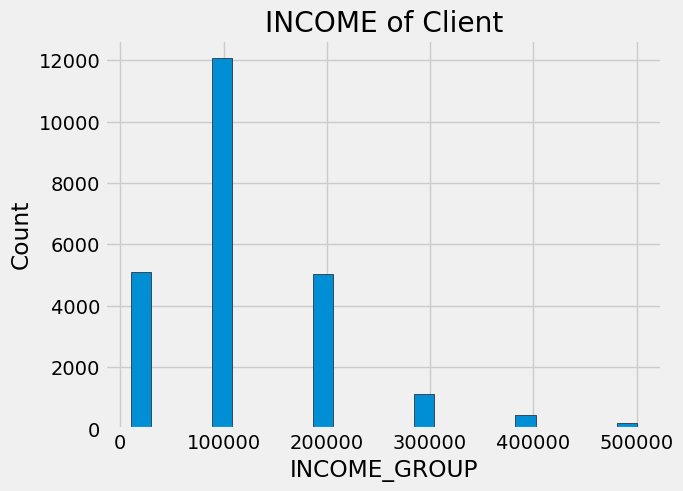

In [56]:
plt.style.use('fivethirtyeight')

plt.hist(df1['INCOME_GROUP'] , edgecolor = 'k', bins = 25)
plt.title('INCOME of Client'); plt.xlabel('INCOME_GROUP'); plt.ylabel('Count');

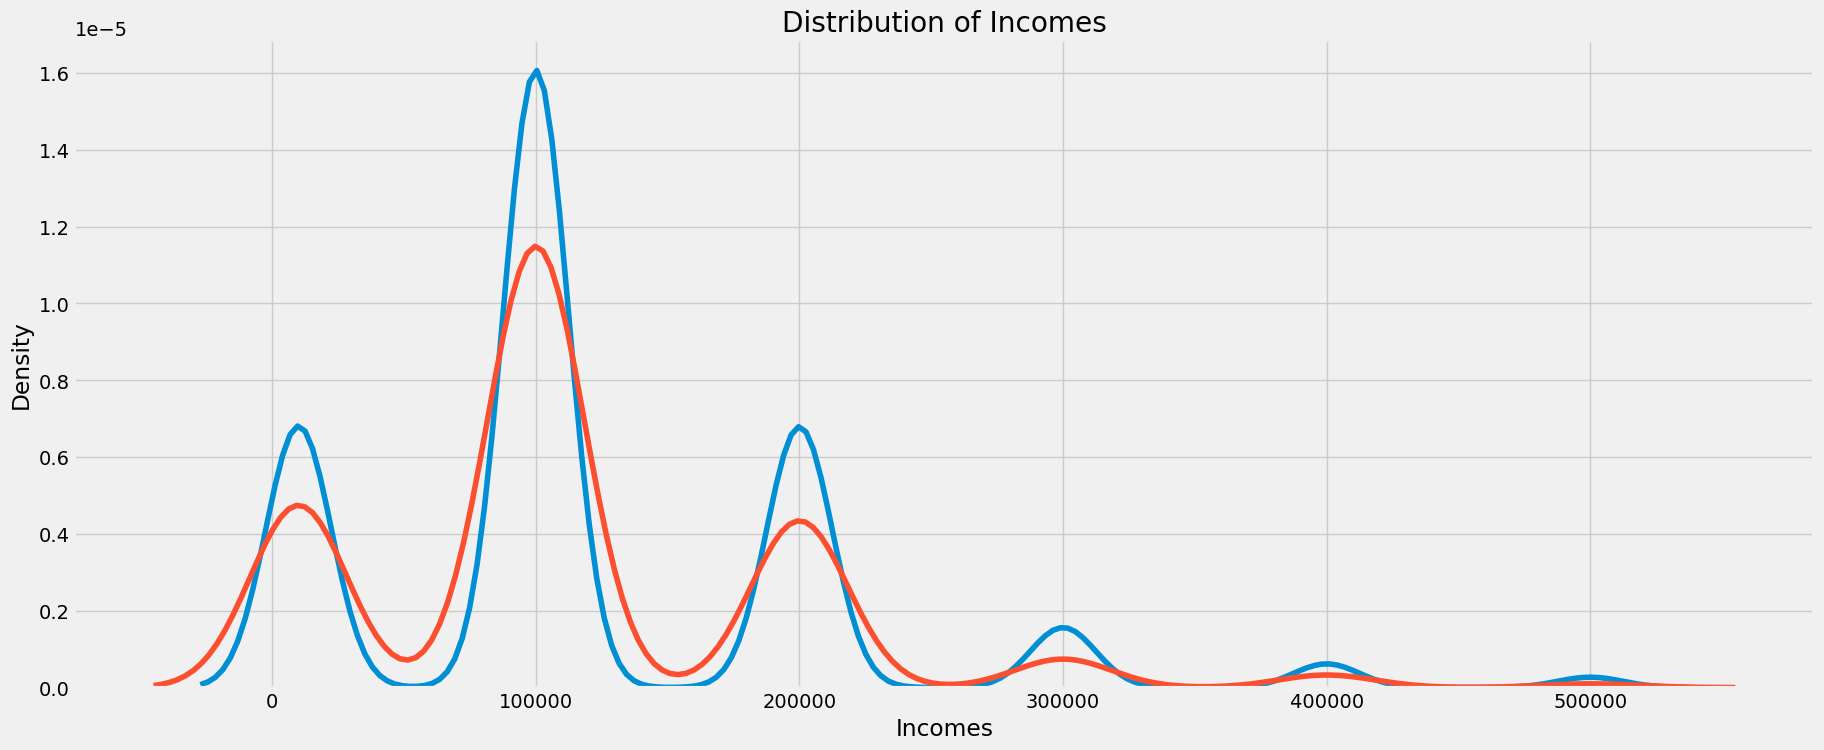

In [57]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'INCOME_GROUP'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'INCOME_GROUP'], label = 'target == 1')

plt.xlabel('Incomes'); plt.ylabel('Density'); plt.title('Distribution of Incomes');


In [58]:
income_groups = df1[['TARGET','INCOME_GROUP']]
income_groups['INCOME_GROUP_MEAN'] = df1['INCOME_GROUP']
income_groups = income_groups.groupby('INCOME_GROUP_MEAN').mean()
income_groups

TARGET  INCOME_GROUP
INCOME_GROUP_MEAN                        
10000              0.085294       10000.0
100000             0.087292      100000.0
200000             0.078796      200000.0
300000             0.059701      300000.0
400000             0.066225      400000.0
500000             0.046392      500000.0

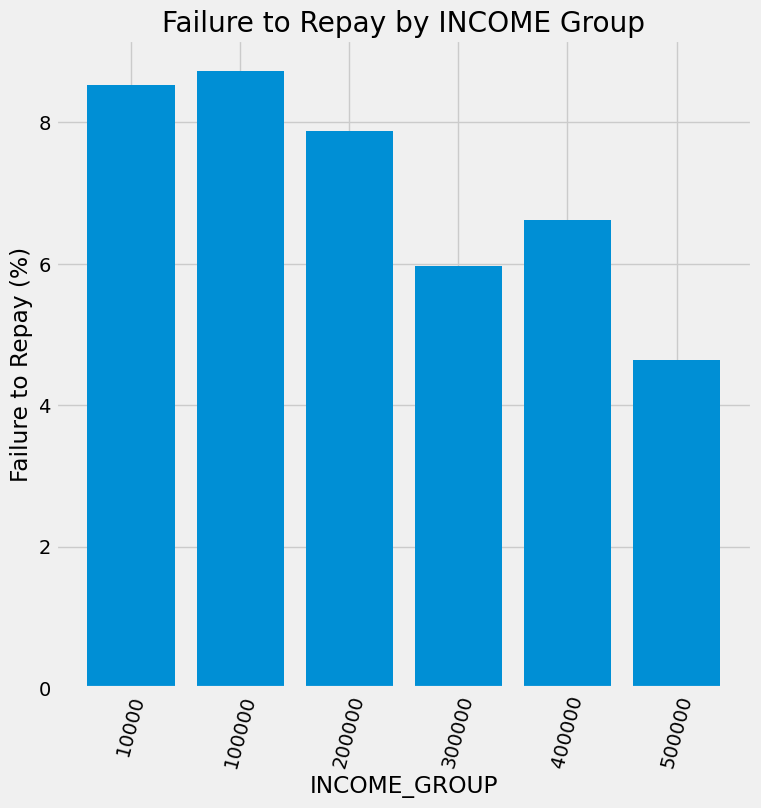

In [59]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(income_groups.index.astype(str), 100 * income_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('INCOME_GROUP'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by INCOME Group');

* 소득금액이 높을수록 연체비율이 줄어드는것을 확인

In [60]:
df1['ln_AMT_INCOME_TOTAL'] = np.log(df1['AMT_INCOME_TOTAL'])

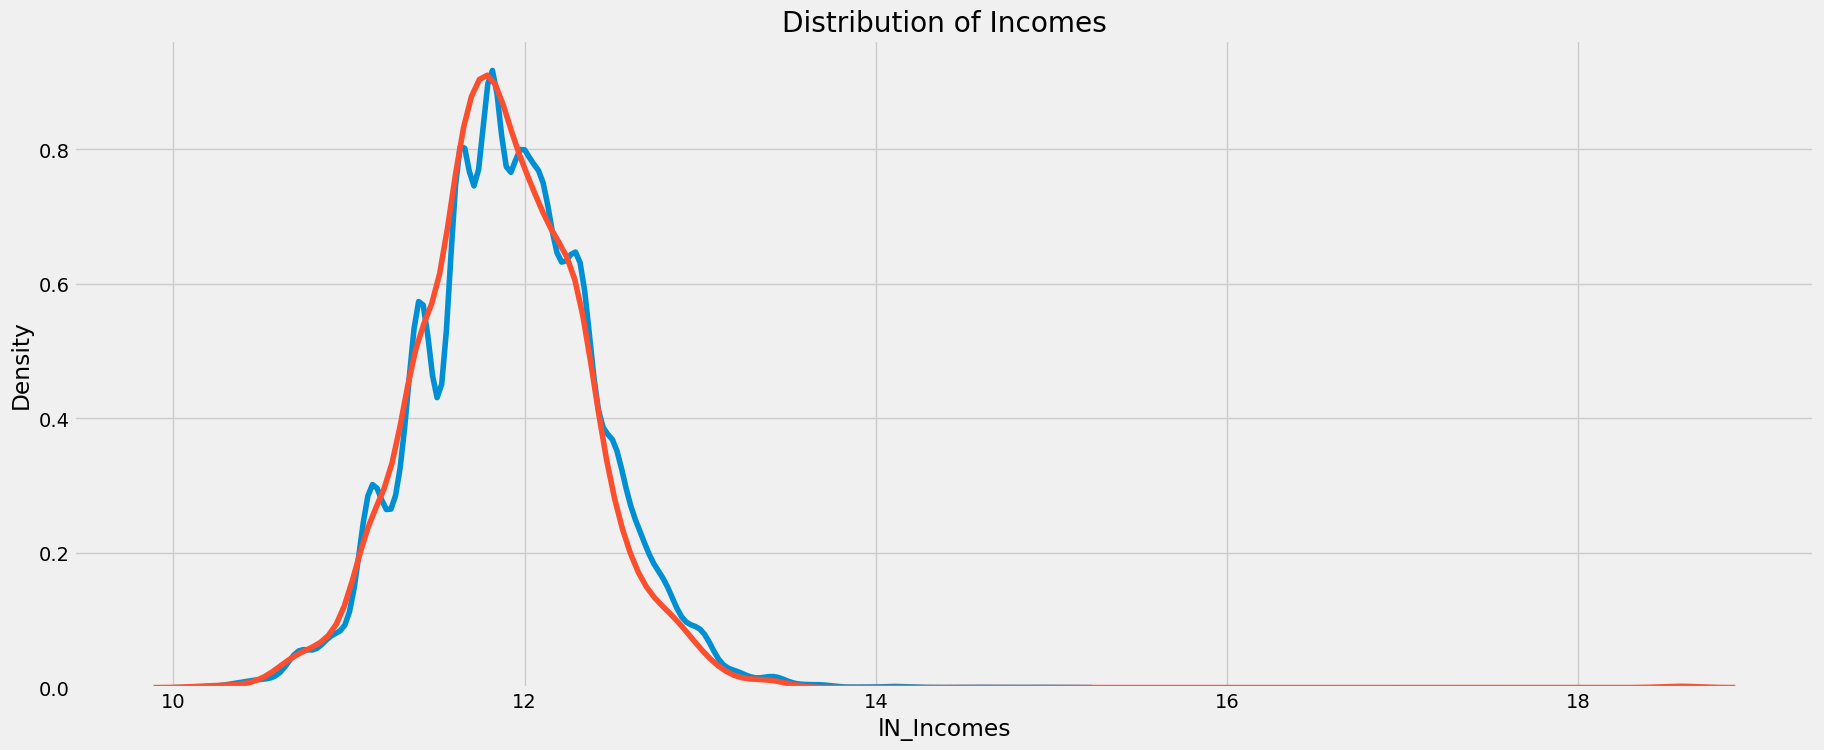

In [61]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df_master['TARGET'] == 0, 'ln_AMT_INCOME_TOTAL'], label = 'target == 0')
sns.kdeplot(df1.loc[df_master['TARGET'] == 1, 'ln_AMT_INCOME_TOTAL'], label = 'target == 1')

plt.xlabel('lN_Incomes'); plt.ylabel('Density'); plt.title('Distribution of Incomes');


### 8. Effect of AMT_INCOME_TOTAL on Repayment

In [62]:
df1 = df_master

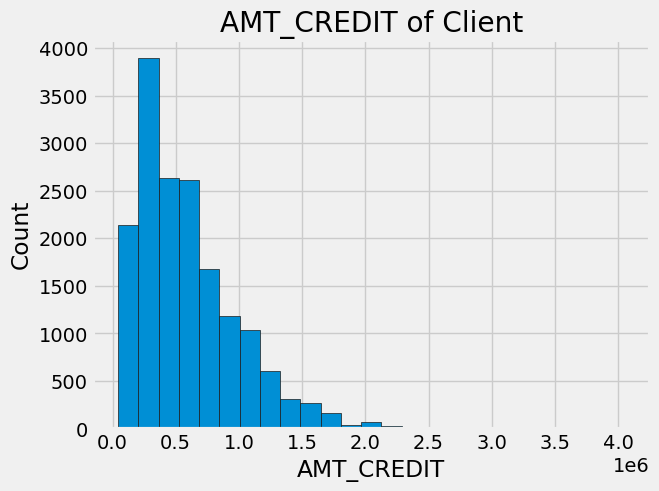

In [63]:
hist_stats('AMT_CREDIT')

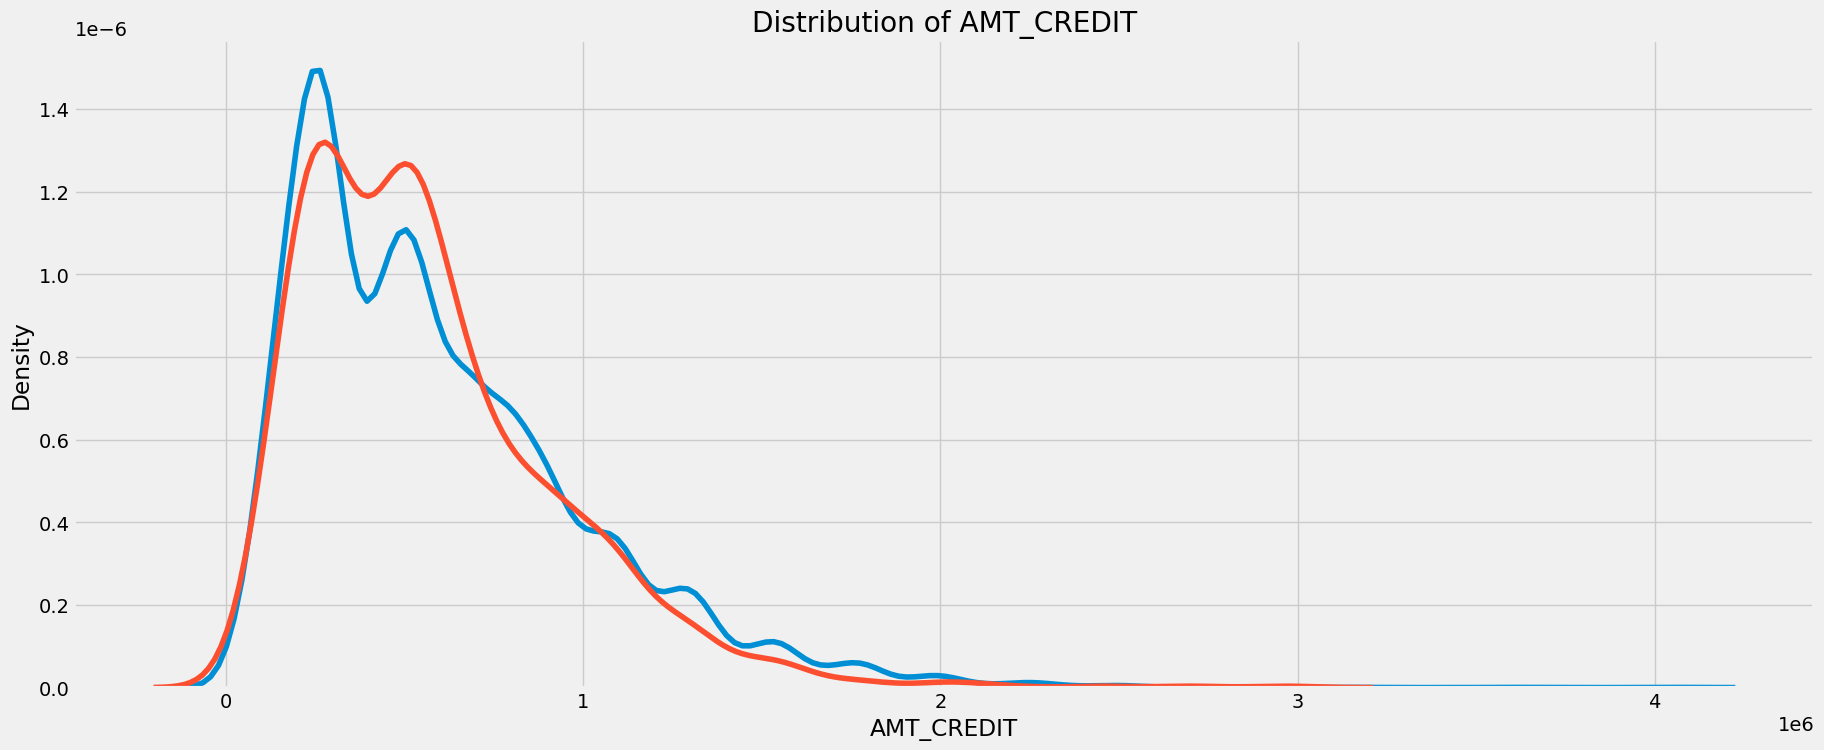

In [64]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'AMT_CREDIT'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'AMT_CREDIT'], label = 'target == 1')

plt.xlabel('AMT_CREDIT'); plt.ylabel('Density'); plt.title('Distribution of AMT_CREDIT');


In [65]:
df1['ln_AMT_CREDIT'] = np.log(df1['AMT_CREDIT'])

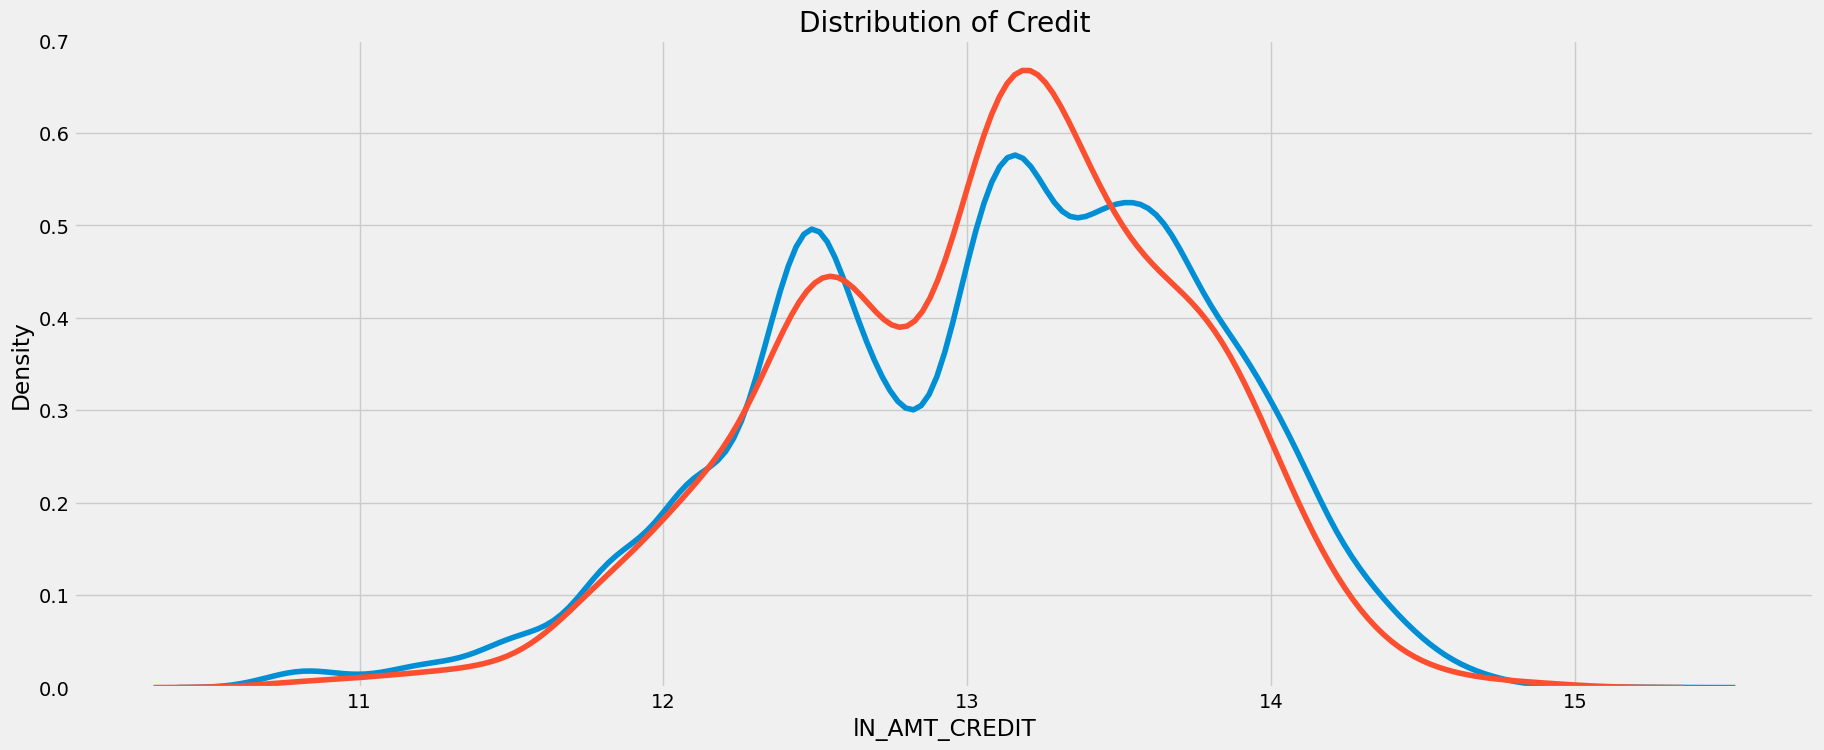

In [66]:
plt.figure(figsize = (20, 8))


sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'ln_AMT_CREDIT'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'ln_AMT_CREDIT'], label = 'target == 1')

plt.xlabel('lN_AMT_CREDIT'); plt.ylabel('Density'); plt.title('Distribution of Credit');


### 9. Effect on Flag_Data on Repayment

In [67]:
df1 = df_master

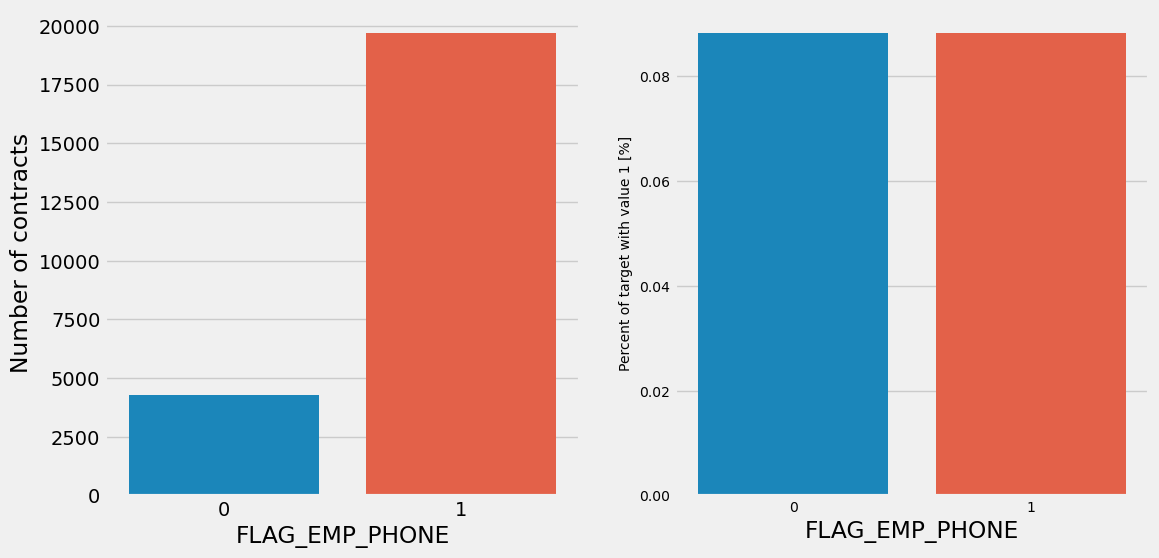

In [68]:
plot_stats('FLAG_EMP_PHONE')

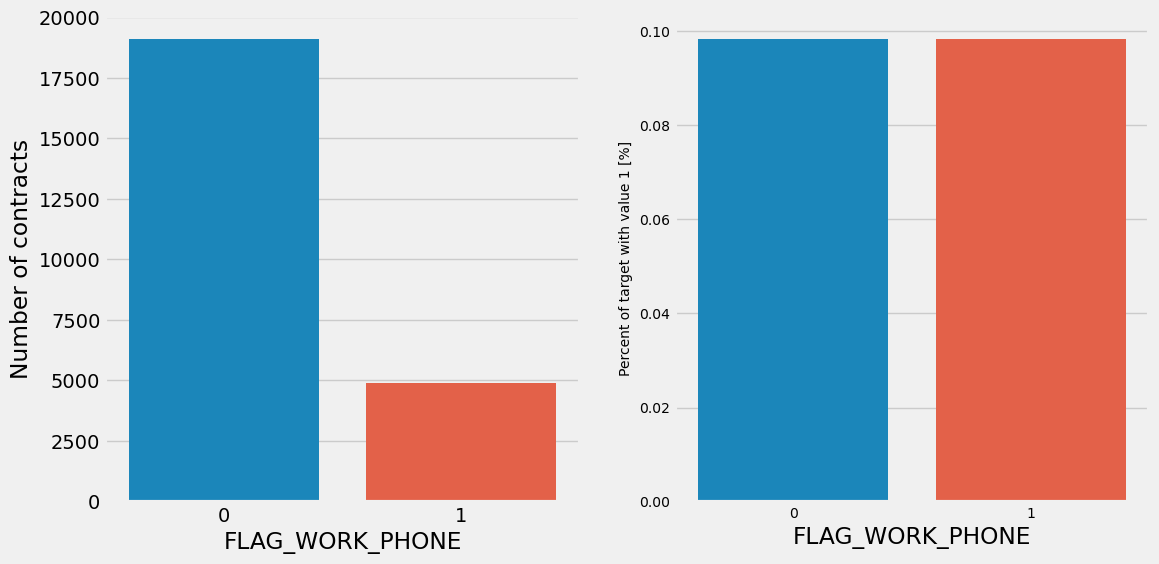

In [69]:
plot_stats('FLAG_WORK_PHONE')

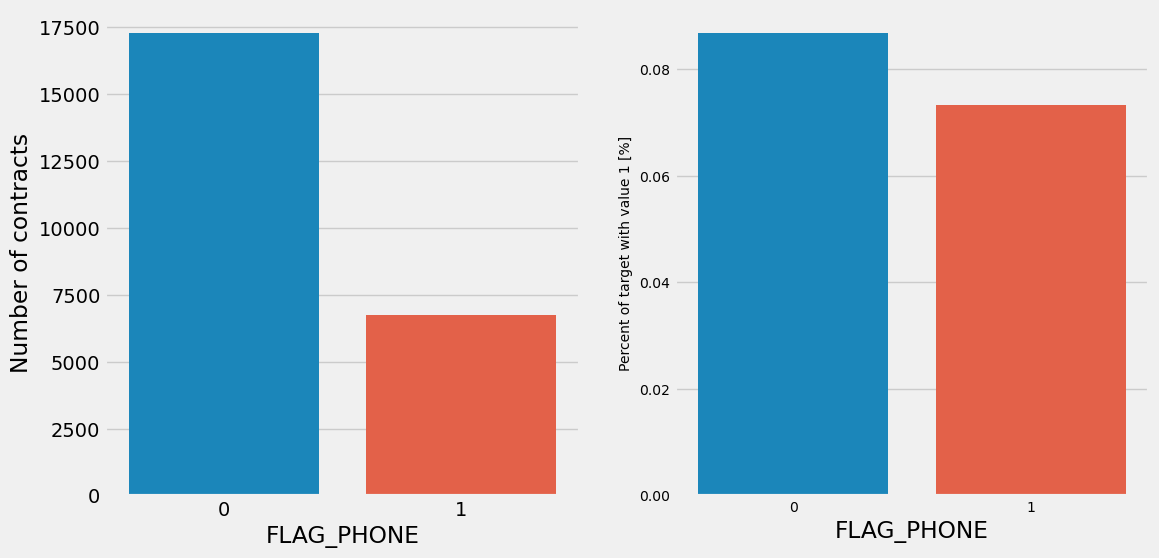

In [70]:
plot_stats('FLAG_PHONE')

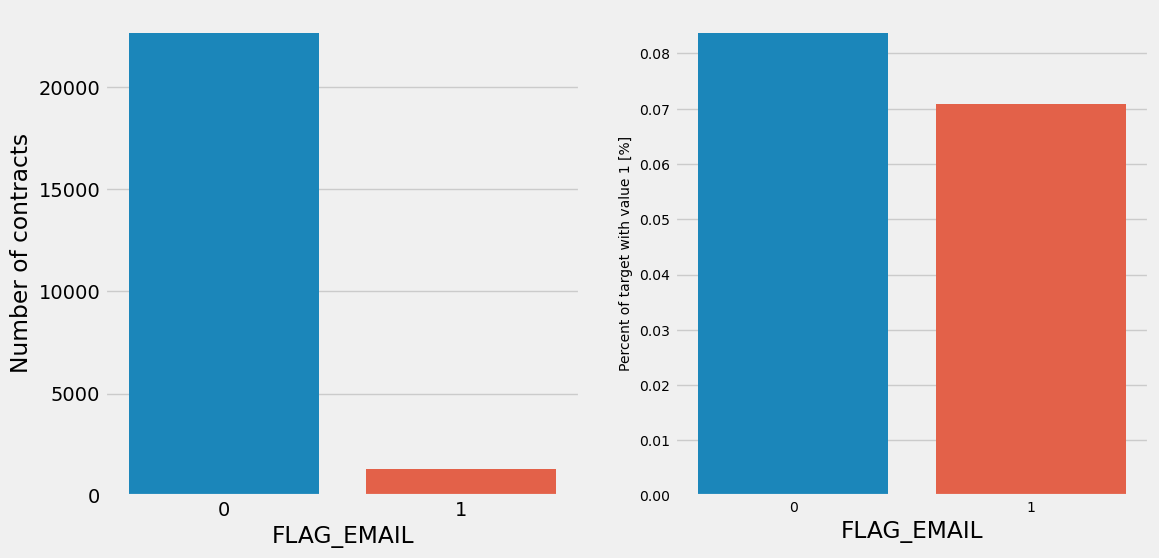

In [71]:
plot_stats('FLAG_EMAIL')

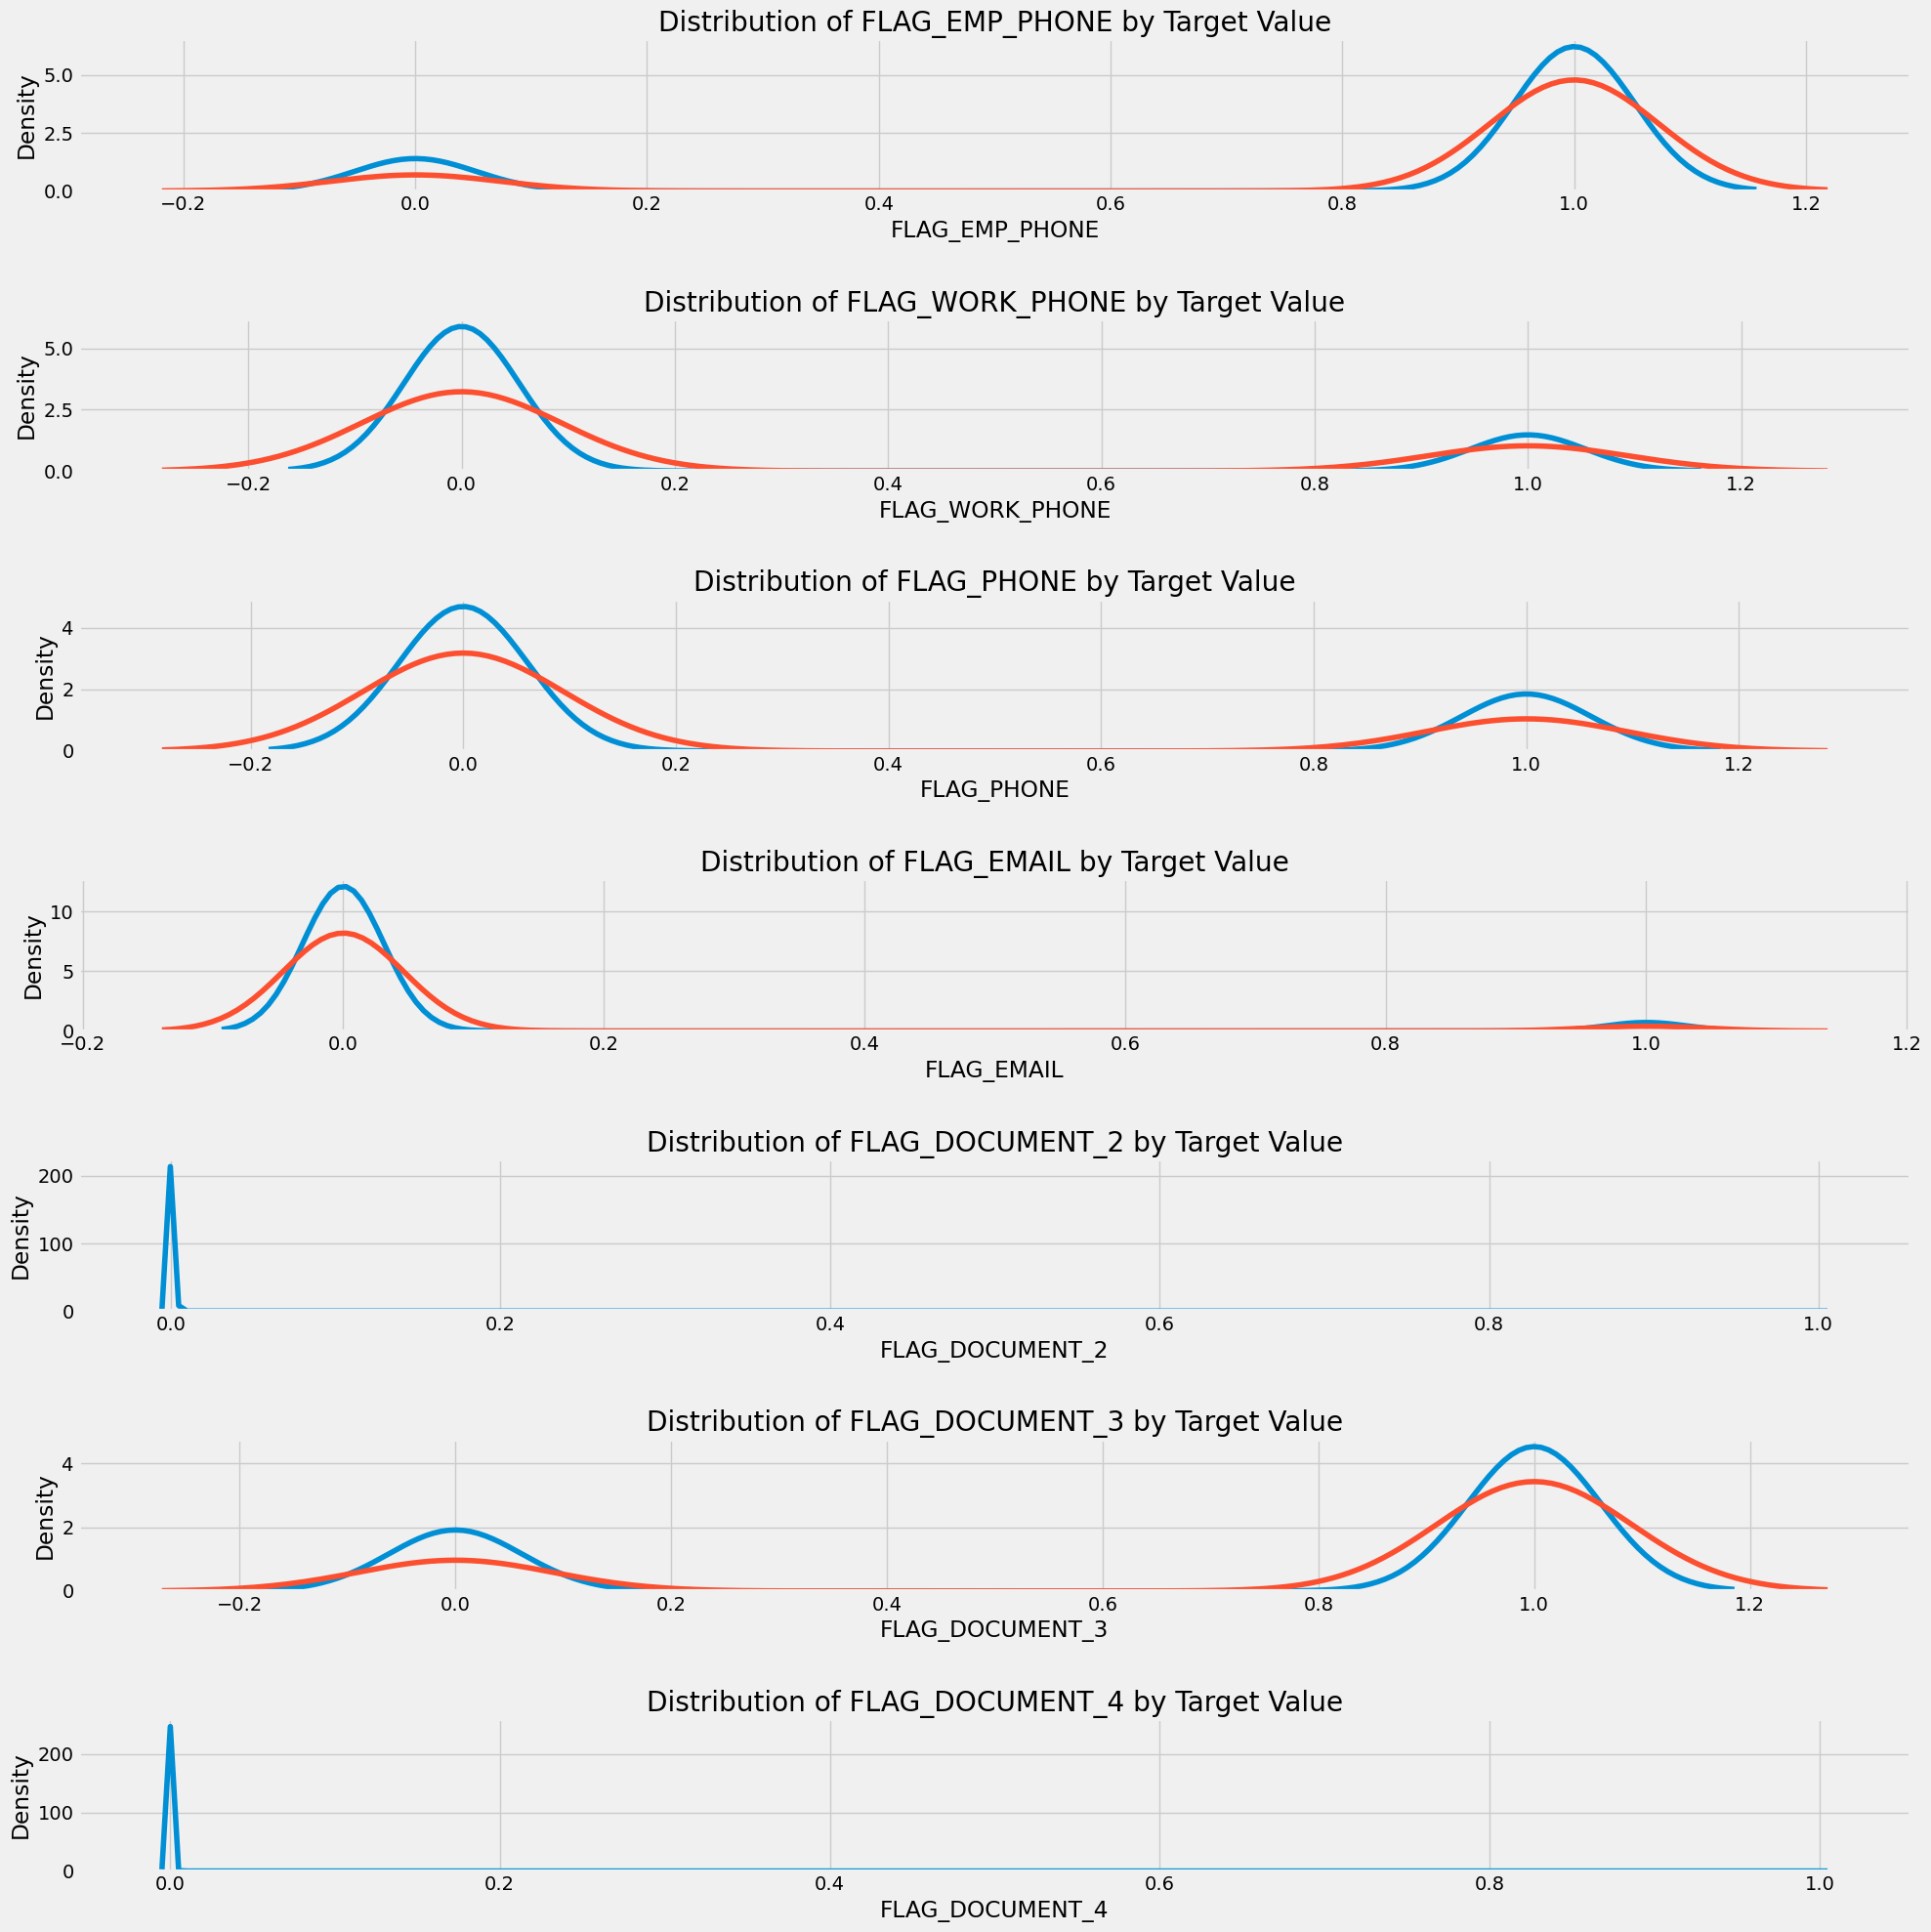

In [72]:
plt.figure(figsize = (20, 20))

for i, source in enumerate(['FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4']):
    
    plt.subplot(7, 1, i + 1)
    
    sns.kdeplot(df1.loc[df1['TARGET'] == 0, source], label = 'target == 0')
    
    sns.kdeplot(df1.loc[df1['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [73]:
df1['FLAG_DOCUMENT_2'].value_counts()

0    23996
1        4
Name: FLAG_DOCUMENT_2, dtype: int64

In [74]:
df1['FLAG_DOCUMENT_4'].value_counts()

0    23997
1        3
Name: FLAG_DOCUMENT_4, dtype: int64

* FLAG_WORK_PHONE , FLAG_PHONE, FLAG_EMAIL 을 등록하지 않은 고객은 등록한 고객에 비해 연체비율이 높았음.
* FLAG_EMP_PHONE 등록한 고객은 등록하지 않은 고객보다 연체비율이 높았음.
* DOCUMENT_2, 4의 경우 제출한 고객에 대해서는 연체 이력이 없지만 애초에 제출한 사람의 수가 적기에 신뢰하기에는 부족.
* DOCUMENT_3의 경우 제출한 고객은 제출하지 않은 고객보다 연체비율이 높았음.
* 하지만 FLAG_DOCUMENT 의 값들을 가지고 특징 추출을 진행해 보기로 계획.

### 10. Effect on YN_Data on Repayment 

In [75]:
df1 = df_master

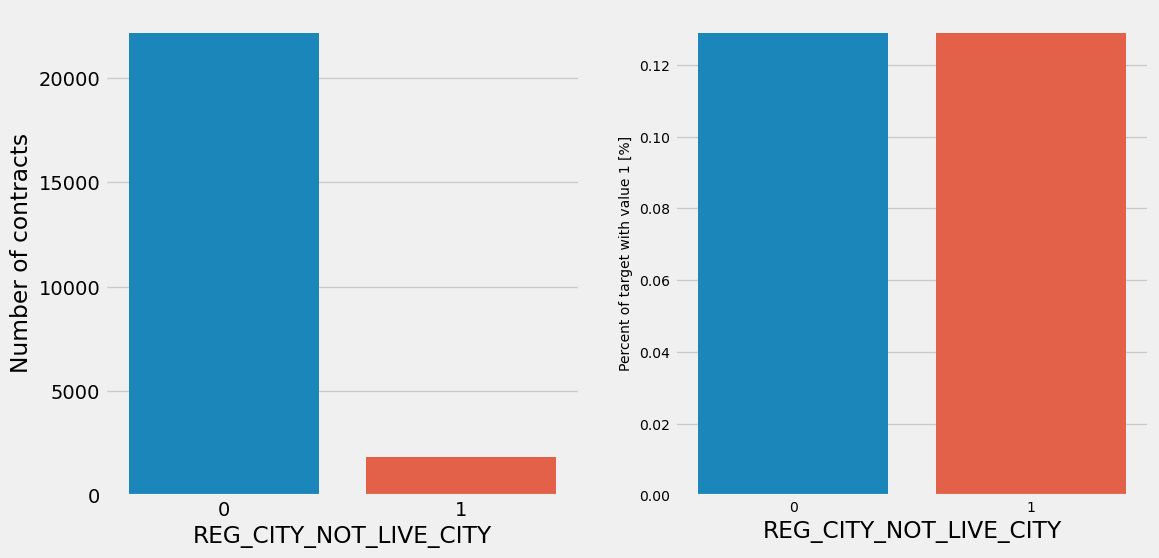

In [76]:
plot_stats('REG_CITY_NOT_LIVE_CITY')

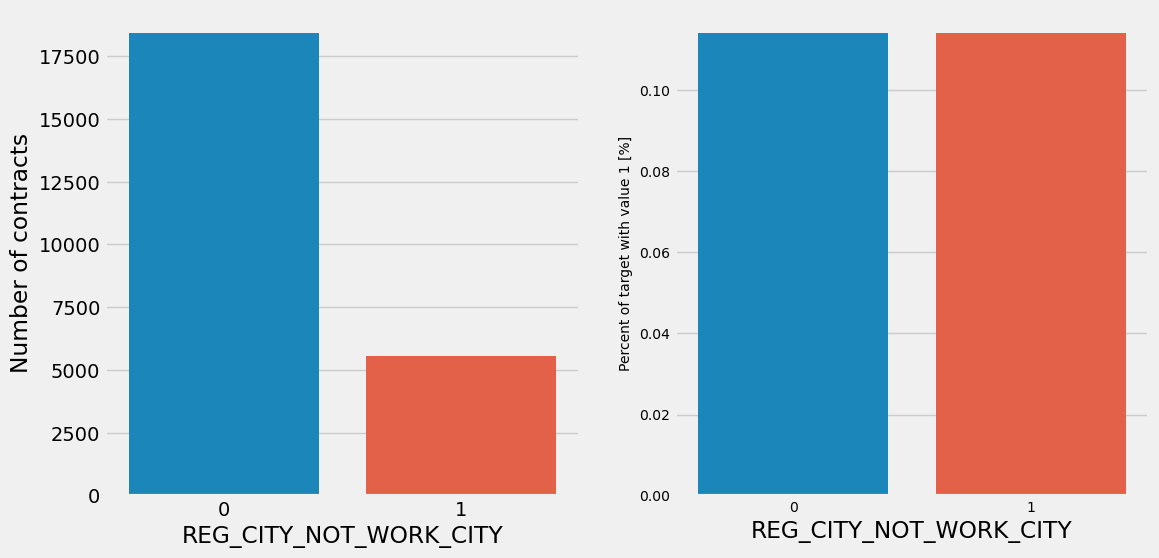

In [77]:
plot_stats('REG_CITY_NOT_WORK_CITY')

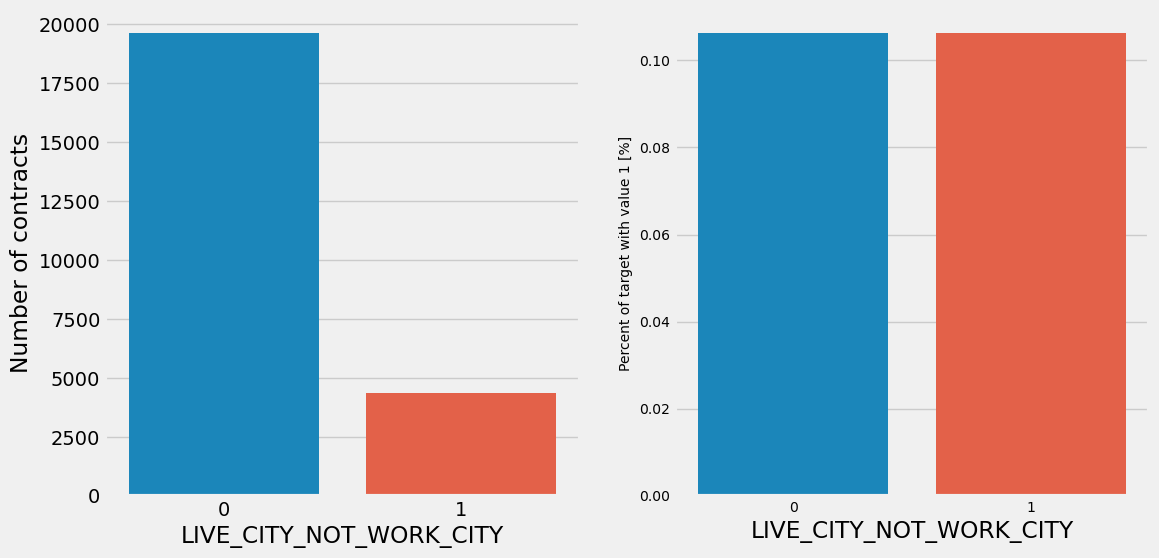

In [78]:
plot_stats('LIVE_CITY_NOT_WORK_CITY')

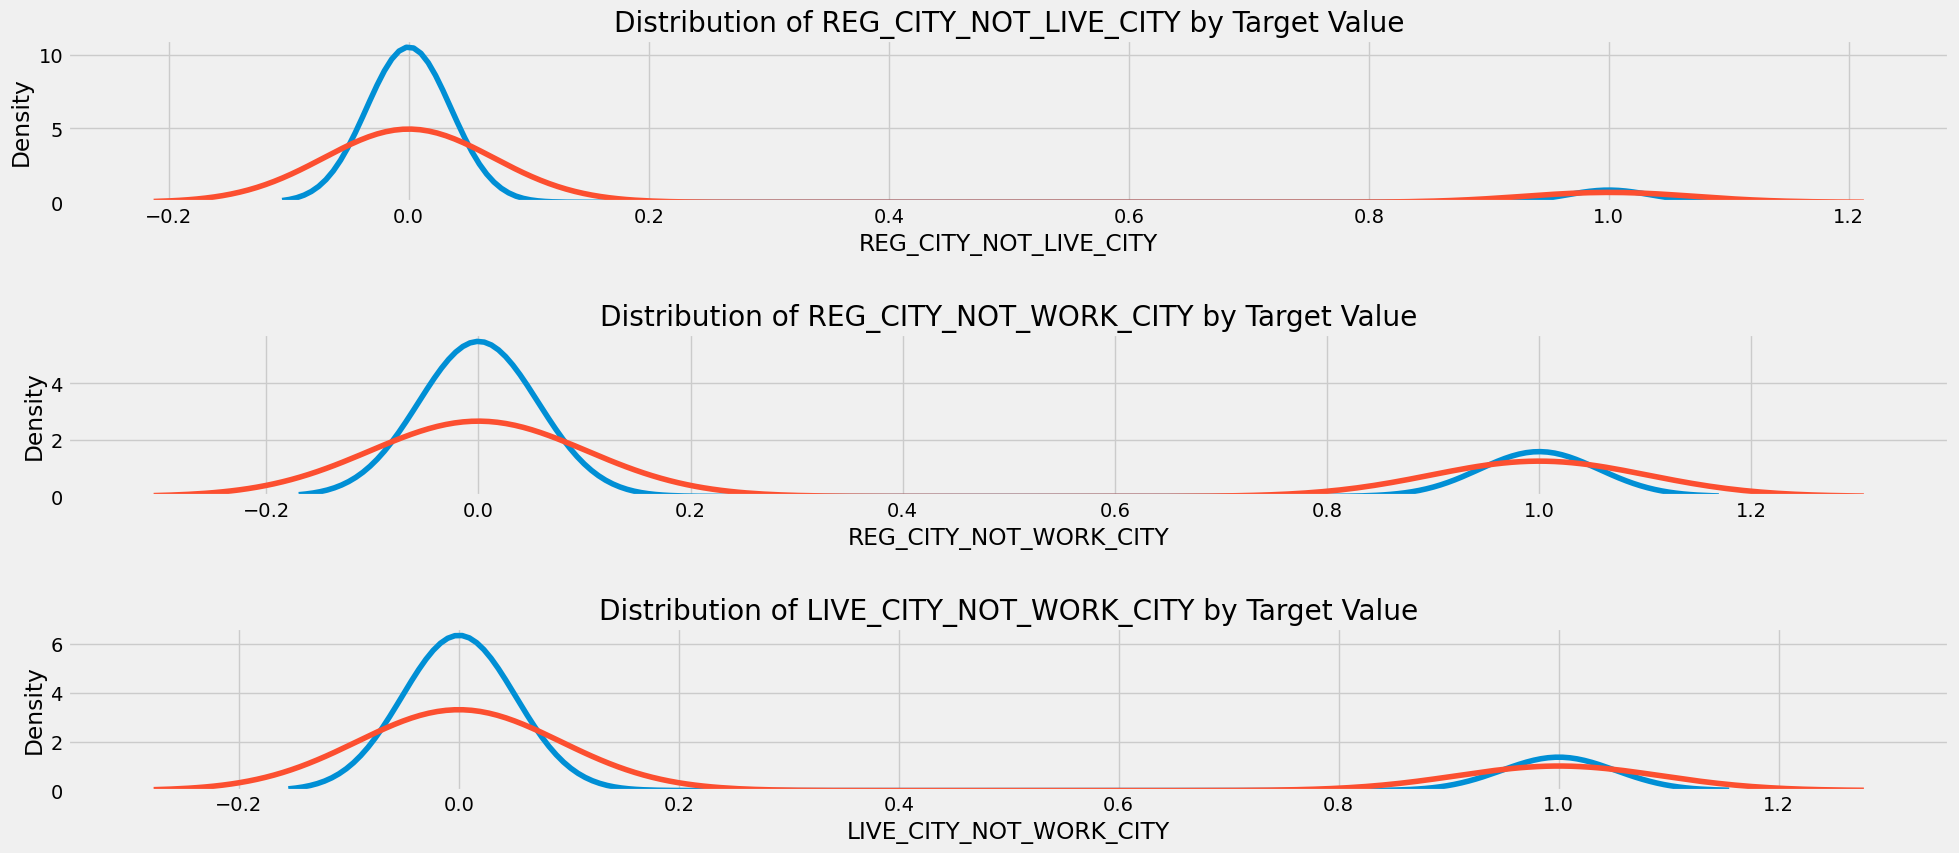

In [79]:
plt.figure(figsize = (20, 20))

for i, source in enumerate(['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']):
    
    plt.subplot(7, 1, i + 1)
    sns.kdeplot(df1.loc[df1['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(df1.loc[df1['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

* 각각의 항목들에대해 일치하지 않을경우 연체비율이 높았음.

### 11. Effect on Income_type on Repayment 

In [80]:
df1= df_master

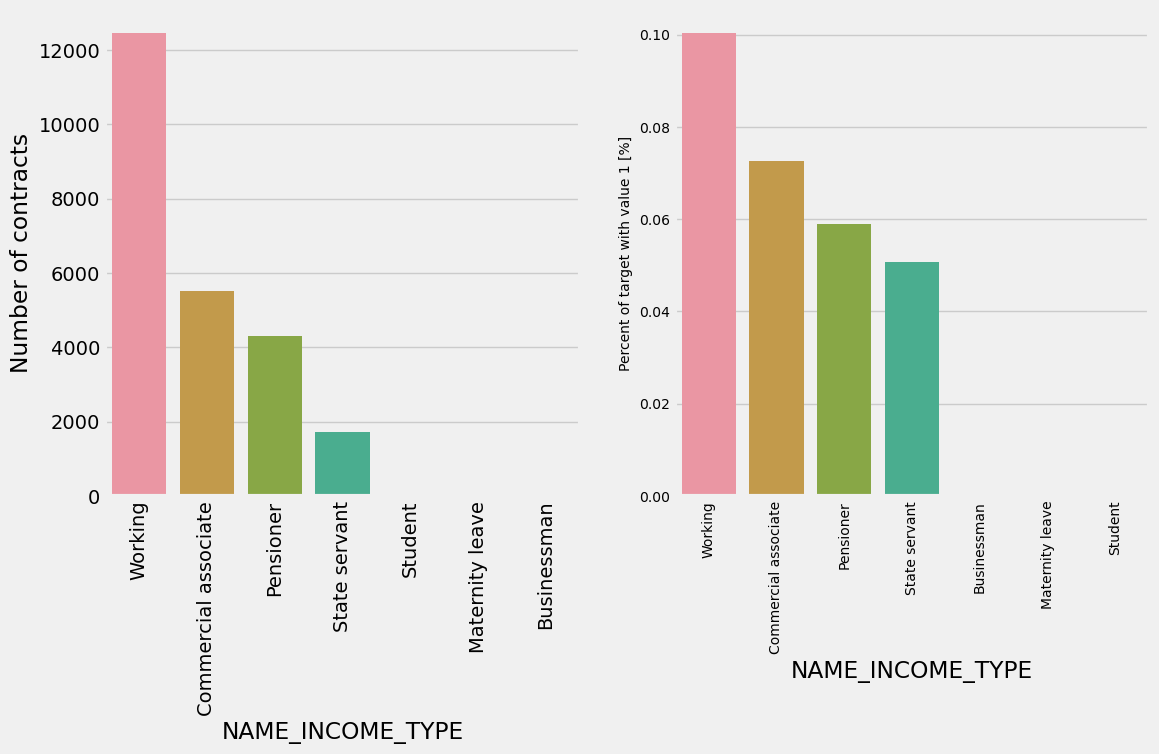

Working                 12460
Commercial associate     5527
Pensioner                4294
State servant            1714
Student                     2
Maternity leave             2
Businessman                 1
Name: NAME_INCOME_TYPE, dtype: int64

In [81]:
plot_stats('NAME_INCOME_TYPE',True)
df1['NAME_INCOME_TYPE'].value_counts()

### 12. Effect on Education_Type on Repayment 

In [82]:
df1 = df_master

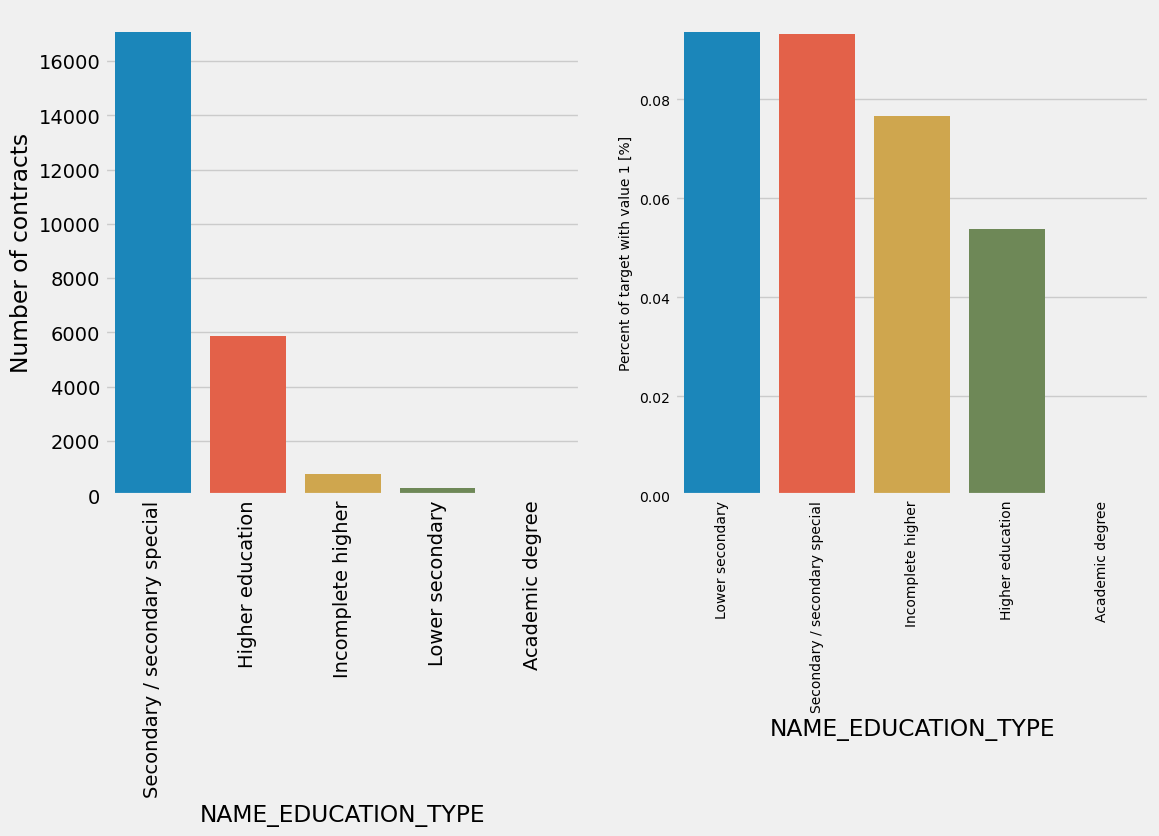

Secondary / secondary special    17054
Higher education                  5857
Incomplete higher                  796
Lower secondary                    278
Academic degree                     15
Name: NAME_EDUCATION_TYPE, dtype: int64

In [83]:
plot_stats('NAME_EDUCATION_TYPE',True)
df1['NAME_EDUCATION_TYPE'].value_counts()

* 교육 수준이 낮을수록 연체 비율이 높음을 예측해 볼 수 있음.

### 13. Effect on Family_Status on Repayment 

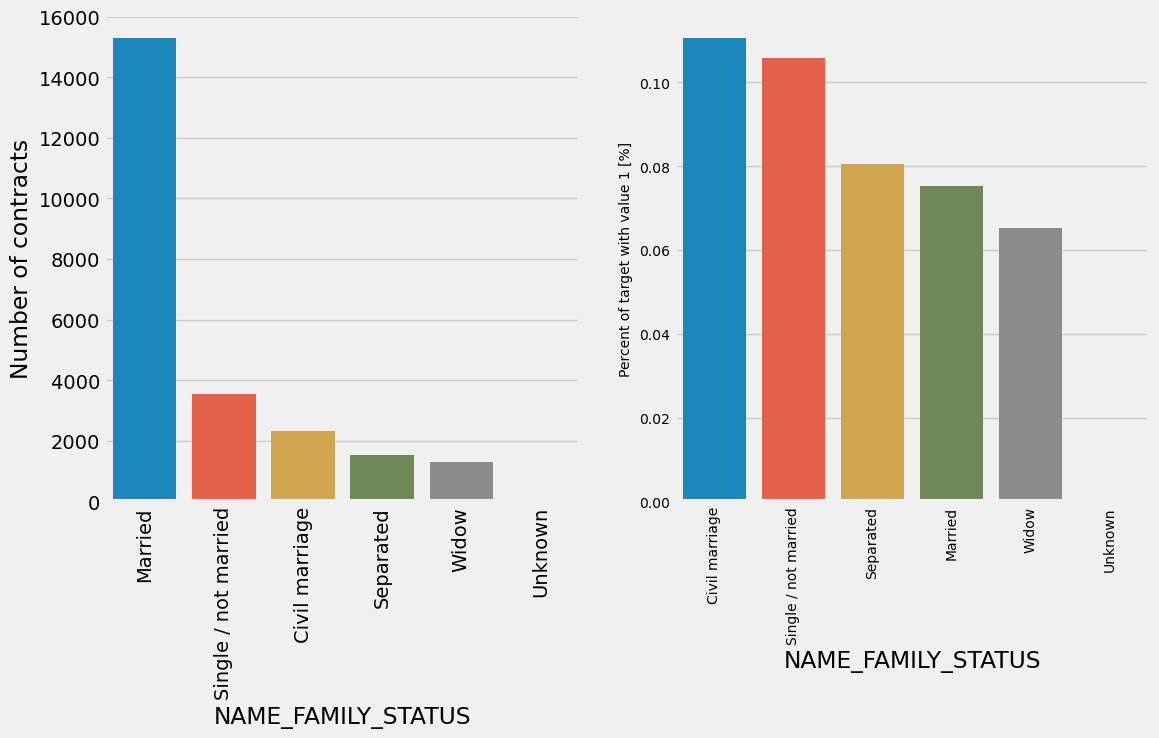

Married                 15275
Single / not married     3557
Civil marriage           2336
Separated                1527
Widow                    1304
Unknown                     1
Name: NAME_FAMILY_STATUS, dtype: int64

In [84]:
plot_stats('NAME_FAMILY_STATUS',True)
df1['NAME_FAMILY_STATUS'].value_counts()

* 결혼한 사람의 대출신청빈도가 높았으며, 싱글의 연체 비율이 높음.
* 결혼한 사람들의 직업,소득,가족 구성 등이 영향이 있지 않을까 추측.

### 14. Effect on Housing_Type on Repayment 

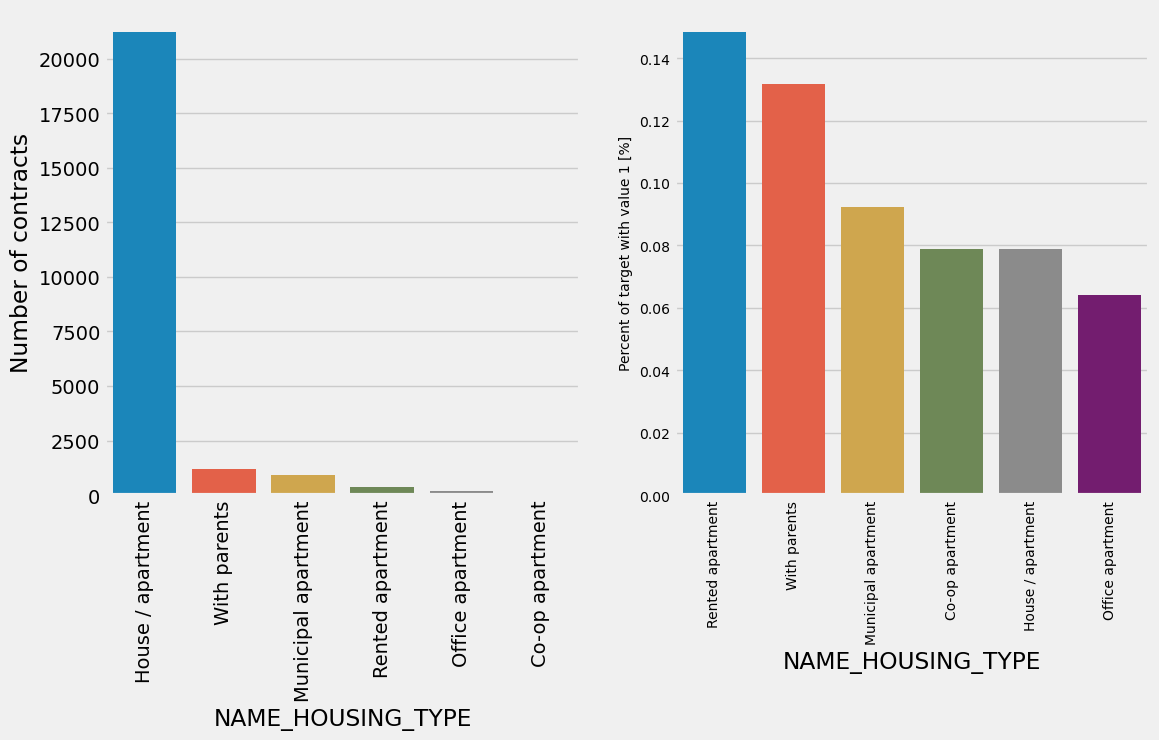

House / apartment      21213
With parents            1206
Municipal apartment      911
Rented apartment         391
Office apartment         203
Co-op apartment           76
Name: NAME_HOUSING_TYPE, dtype: int64

In [85]:
plot_stats('NAME_HOUSING_TYPE',True)
df1['NAME_HOUSING_TYPE'].value_counts()

* 일반주택/아파트에 거주하고 있는 사람들의 대출 신청빈도가 높았음. 자가 부동산이 있지 않을까 추측.
* 임대 및 부모님과 거주 한 사람들의 연체 빈도가 높음. 직업,소득과 같은 경제적인 상황과 연관이 있지 않을까 추측.

### 15. Effect on Region_Relative on Repayment 

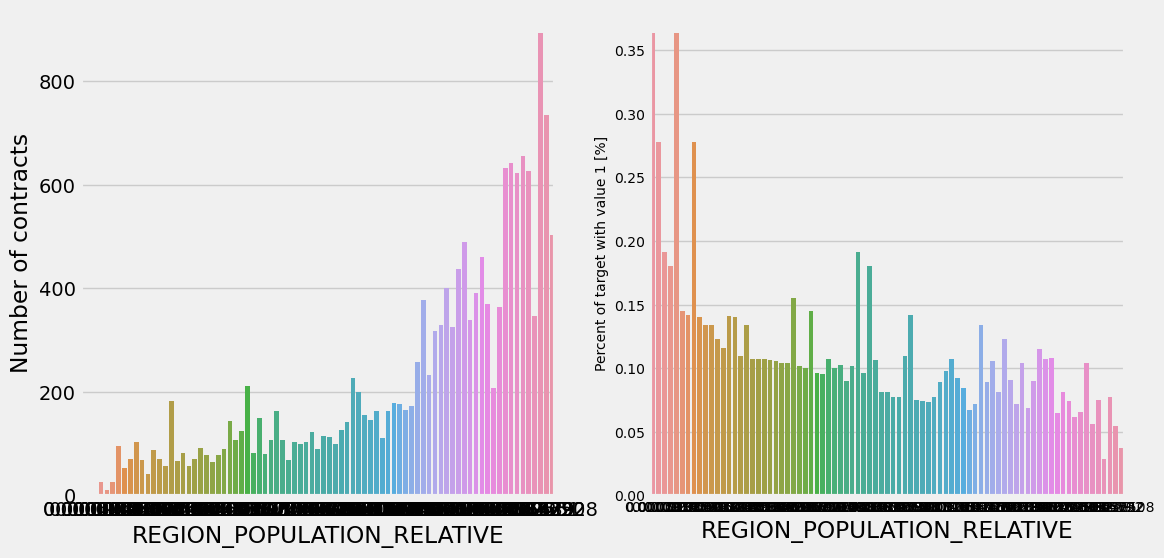

In [86]:
plot_stats('REGION_POPULATION_RELATIVE')

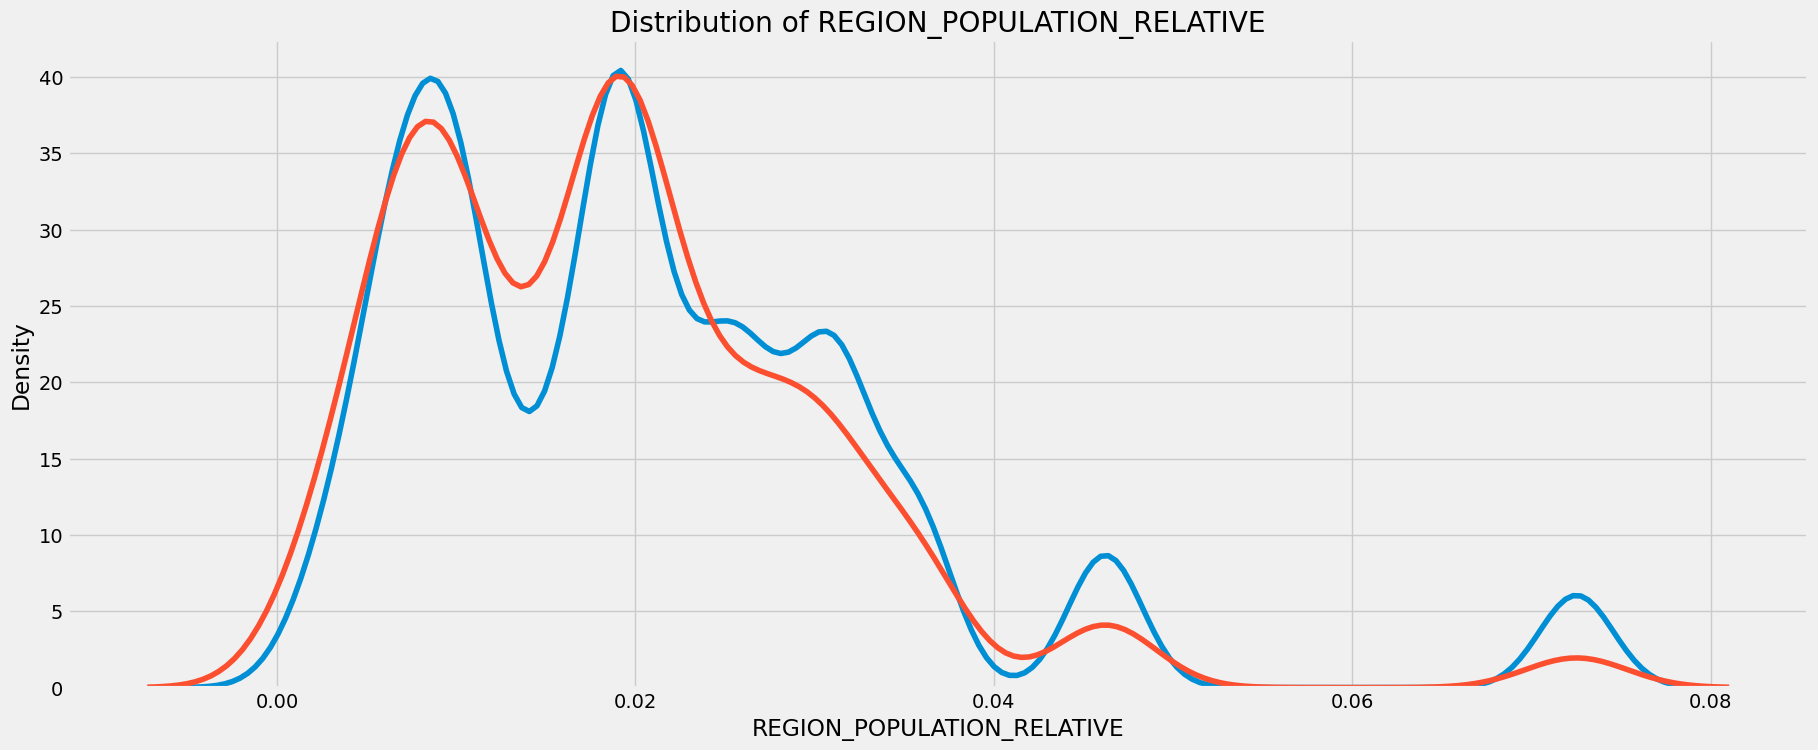

In [87]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'REGION_POPULATION_RELATIVE'], label = 'target == 0')

sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'REGION_POPULATION_RELATIVE'], label = 'target == 1')

plt.xlabel('REGION_POPULATION_RELATIVE'); plt.ylabel('Density'); plt.title('Distribution of REGION_POPULATION_RELATIVE');


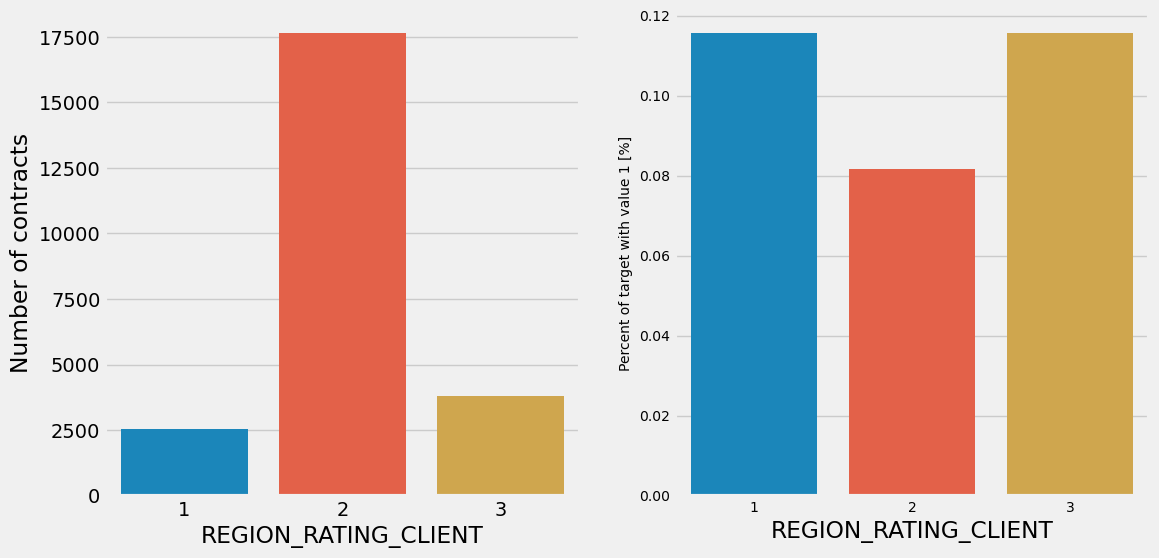

In [88]:
plot_stats('REGION_RATING_CLIENT')

In [89]:
# Extract the Region variables and show correlations
region_data = df1[['REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT']]
region_data_corrs = region_data.corr()
region_data_corrs

REGION_POPULATION_RELATIVE  REGION_RATING_CLIENT
REGION_POPULATION_RELATIVE                       1.000                -0.537
REGION_RATING_CLIENT                            -0.537                 1.000

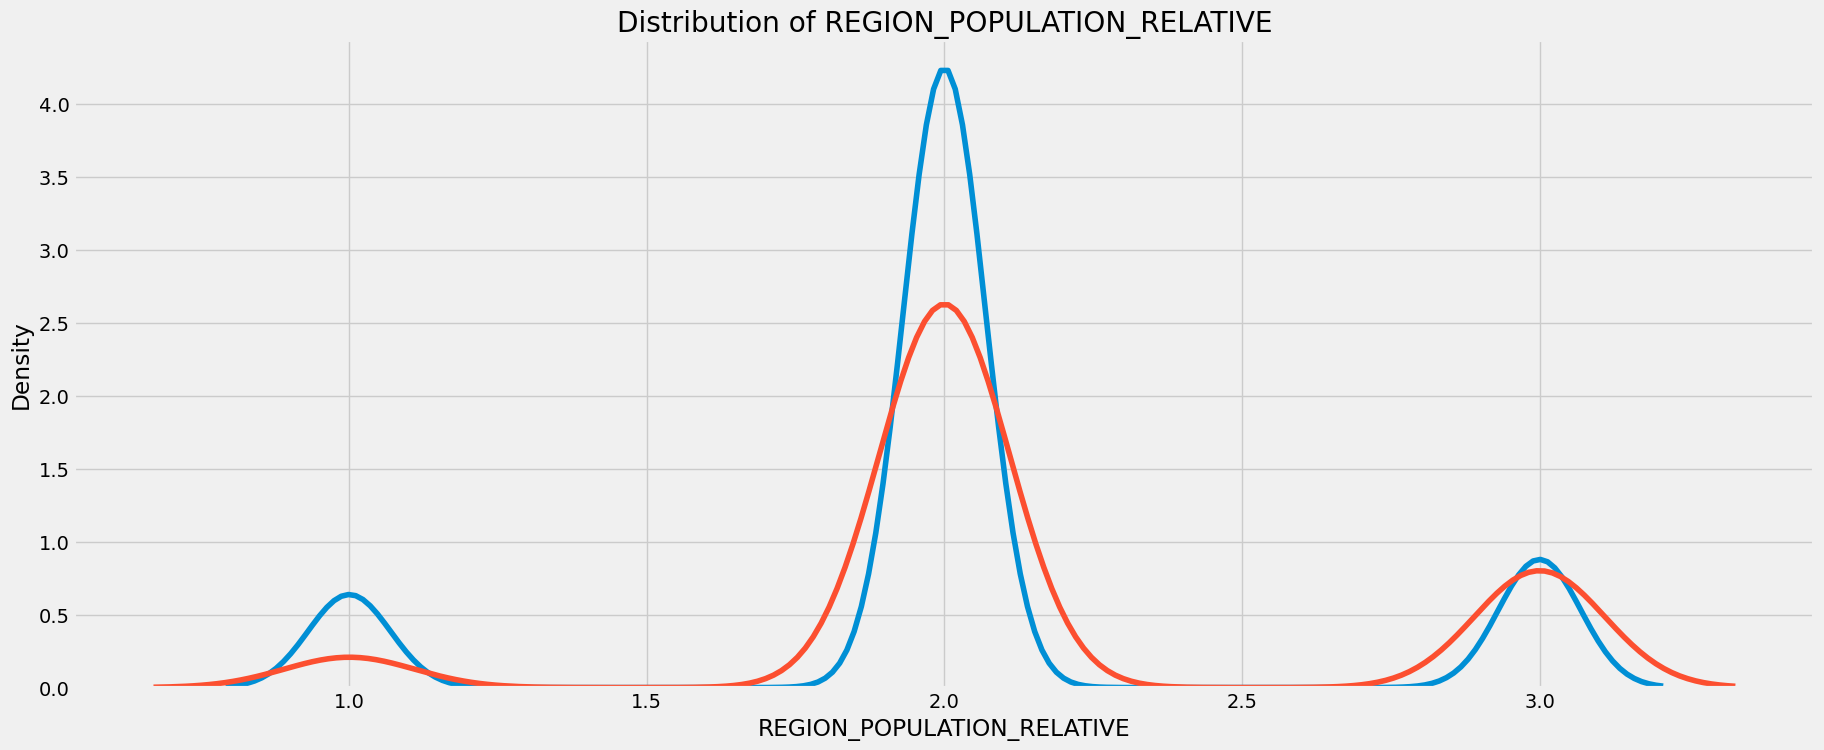

In [90]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'REGION_RATING_CLIENT'], label = 'target == 0')

sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'REGION_RATING_CLIENT'], label = 'target == 1')

plt.xlabel('REGION_POPULATION_RELATIVE'); plt.ylabel('Density'); plt.title('Distribution of REGION_POPULATION_RELATIVE');


* REGION_POPULATION_RELATIVE 와 REGION_RATING_CLIENT 는 음의 상관관계를 가지고 있음.
* 거주지의 등급이 높을수록 표준화된 인구비율이 줄어든다는 것을 알수있다
* 거주지 등급이 높고 표준화된 인구비율이 낮을수록 연체율이 높다.

### 16. Effect on Wweek Day & Time on Repayment 

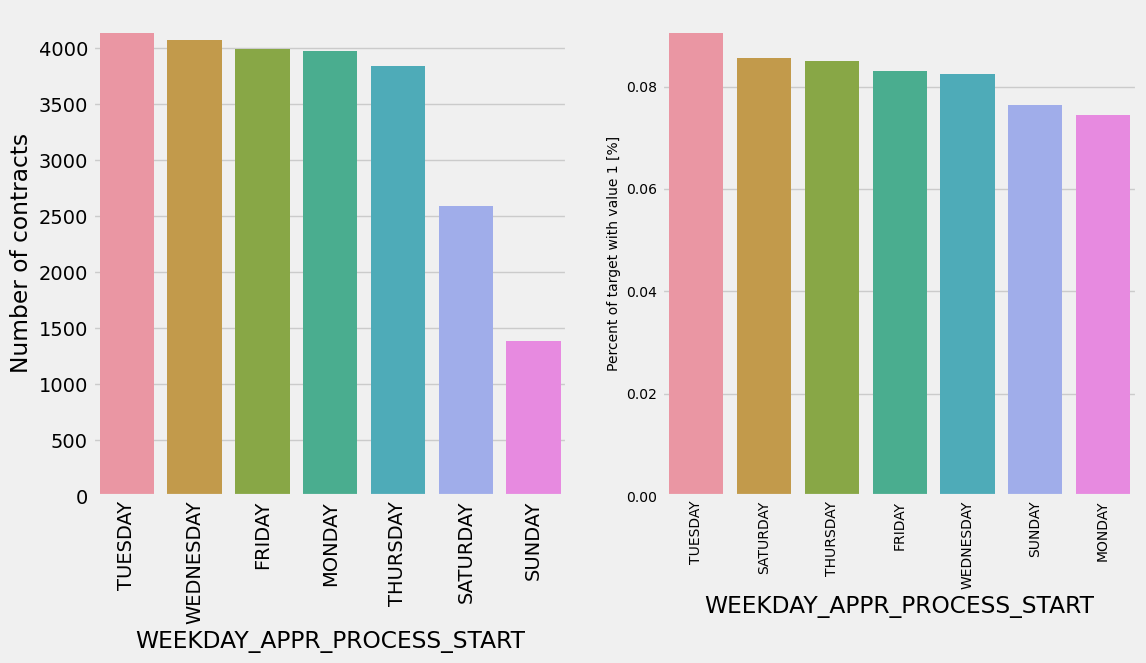

In [91]:
plot_stats('WEEKDAY_APPR_PROCESS_START', True)

* 토요일과 일요일에 발생한 대출신청건은 모바일 신청으로 예측 됨.

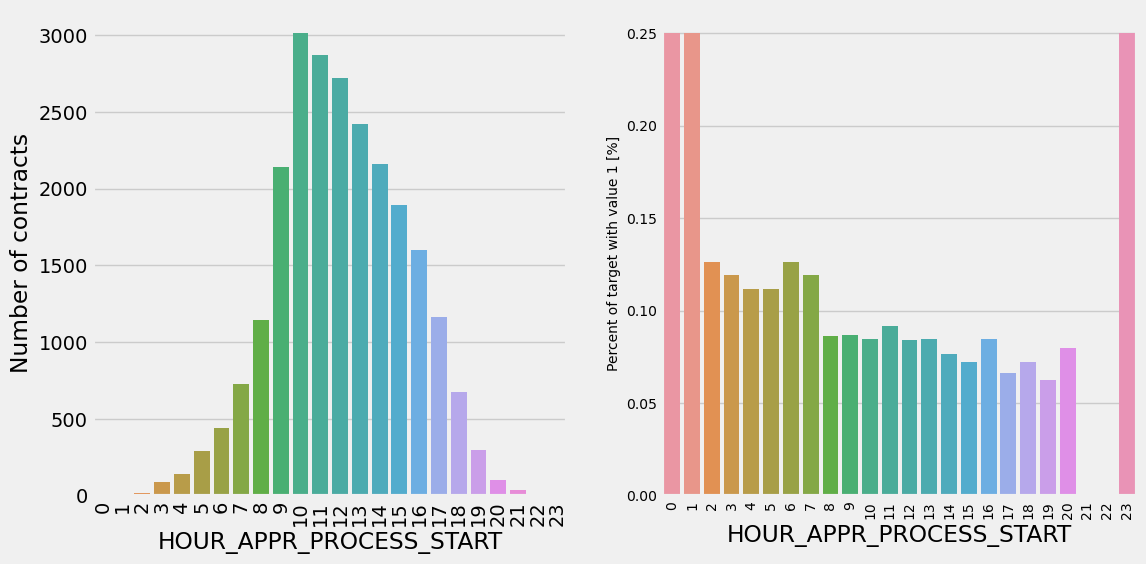

In [92]:
plot_stats('HOUR_APPR_PROCESS_START', True)

* 대출시간 중 23시 이후 새벽 시간에 연체비율이 높은것으로 보임.
* 이는 은행 마감 시간에 비대면 대출일 가능성이 높음,
* 비대면 대출의 연체비율이 높다고 가정.
* 단, 23시 ~ 1시 까지의 대출 신청건이 현저히 낮으므로 과적합에 유의가 필요.

# Feature Engineering

## Missing Value & Encoding

In [95]:
df_master = pd.read_csv('../0.data/loan_customer.csv')

In [96]:
df = df_master

In [97]:
# CODE_GENDER Impute Missing value with RandomFroest
key_col = 'SK_ID_CURR'
y_col = 'TARGET'

df.drop(columns = key_col,inplace = True)

x_col = [col for col in df.columns if col != y_col]
nullCol = [col for col in df.columns if sum(df[col].isna())>0]
NnullCol = [col for col in df.columns if col not in (nullCol+[y_col])]

nullObjcol = [col for col in df.columns if (sum(df[col].isna())>0) & (df[col].dtype.name == 'object')]
NullNObjcol = [col for col in df.columns if (sum(df[col].isna())>0) & (df[col].dtype.name in ('int64','float64'))]

objCol = list(df.select_dtypes('object').columns)
NobjCol = [col for col in df.columns if col not in (objCol+[y_col])]

genderDf = df[NnullCol]
genderDf = pd.get_dummies(genderDf)
genderDf = pd.concat([genderDf,df['TARGET'],df['CODE_GENDER']],axis=1)

trainX = genderDf[genderDf['CODE_GENDER'].isna()==False].drop(columns='CODE_GENDER')
trainY = genderDf[genderDf['CODE_GENDER'].isna()==False]['CODE_GENDER']
#trainY = pd.get_dummies(trainY)

testX = genderDf[genderDf['CODE_GENDER'].isna()].drop(columns='CODE_GENDER').reset_index(drop=1)

RF = RandomForestClassifier(n_estimators=1000,max_depth=9)
RF.fit(trainX,trainY)

testY = RF.predict(testX)
testY = pd.DataFrame(testY,columns=['CODE_GENDER']).reset_index(drop=1)
fillGender = pd.concat([testX,testY],axis=1)

In [98]:
fillGender = pd.concat([genderDf[genderDf['CODE_GENDER'].isna()==False],fillGender],axis=0).reset_index(drop=True)
fillGender = pd.get_dummies(fillGender)

In [99]:
codeGender = fillGender[['CODE_GENDER_F','CODE_GENDER_M']]
codeGender

CODE_GENDER_F  CODE_GENDER_M
0                  0              1
1                  0              1
2                  0              1
3                  1              0
4                  1              0
...              ...            ...
23995              1              0
23996              1              0
23997              1              0
23998              1              0
23999              0              1

[24000 rows x 2 columns]

In [100]:
df_master.drop(columns = 'CODE_GENDER',inplace = True)

In [101]:
df_master = df_master.join(codeGender, how='left')

In [102]:
# FLAG_OWN_REALTY Impute Missing value with RandomFroest
y_col = 'TARGET'

x_col = [col for col in df.columns if col != y_col]
nullCol = [col for col in df.columns if sum(df[col].isna())>0]
NnullCol = [col for col in df.columns if col not in (nullCol+[y_col])]

nullObjcol = [col for col in df.columns if (sum(df[col].isna())>0) & (df[col].dtype.name == 'object')]
NullNObjcol = [col for col in df.columns if (sum(df[col].isna())>0) & (df[col].dtype.name in ('int64','float64'))]

objCol = list(df.select_dtypes('object').columns)
NobjCol = [col for col in df.columns if col not in (objCol+[y_col])]

realtyDf = df[NnullCol]
realtyDf = pd.get_dummies(realtyDf)
realtyDf = pd.concat([realtyDf,df['TARGET'],df['FLAG_OWN_REALTY']],axis=1)

trainX = realtyDf[realtyDf['FLAG_OWN_REALTY'].isna()==False].drop(columns='FLAG_OWN_REALTY')
trainY = realtyDf[realtyDf['FLAG_OWN_REALTY'].isna()==False]['FLAG_OWN_REALTY']
#trainY = pd.get_dummies(trainY)

testX = realtyDf[realtyDf['FLAG_OWN_REALTY'].isna()].drop(columns='FLAG_OWN_REALTY').reset_index(drop=1)

RF = RandomForestClassifier(n_estimators=1000,max_depth=9)
RF.fit(trainX,trainY)

testY = RF.predict(testX)
testY = pd.DataFrame(testY,columns=['FLAG_OWN_REALTY']).reset_index(drop=1)
fillRealty = pd.concat([testX,testY],axis=1)

fillRealty = pd.concat([realtyDf[realtyDf['FLAG_OWN_REALTY'].isna()==False],fillRealty],axis=0).reset_index(drop=True)
fillRealty = pd.get_dummies(fillRealty)

In [103]:
fillRealty

CNT_CHILDREN  AMT_INCOME_TOTAL  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                 0          202500.0           1               1   
1                 0          108000.0           1               1   
2                 2          135000.0           1               1   
3                 0          202500.0           1               1   
4                 0          360000.0           1               1   
...             ...               ...         ...             ...   
23995             2          247500.0           1               1   
23996             0          157500.0           1               1   
23997             4          135000.0           1               1   
23998             0          135000.0           1               0   
23999             1          360000.0           1               1   

       FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0                    0           1           0                     2   
1                    0           0           0                     2   
2                    0           0           0                     2   
3                    0           1           0                     2   
4                    0           0           0                     2   
...                ...         ...         ...                   ...   
23995                0           0           0                     3   
23996                1           1           0                     3   
23997                0           0           0                     2   
23998                0           0           0                     2   
23999                1           0           0                     3   

       HOUR_APPR_PROCESS_START  REG_CITY_NOT_LIVE_CITY  ...  \
0                           10                       0  ...   
1                           12                       1  ...   
2                           14                       0  ...   
3                           12                       0  ...   
4                           10                       0  ...   
...                        ...                     ...  ...   
23995                       12                       0  ...   
23996                        7                       0  ...   
23997                       10                       1  ...   
23998                       10                       0  ...   
23999                       11                       0  ...   

       ORGANIZATION_TYPE_Trade: type 7  ORGANIZATION_TYPE_Transport: type 1  \
0                                    0                                    0   
1                                    0                                    0   
2                                    0                                    0   
3                                    0                                    0   
4                                    0                                    0   
...                                ...                                  ...   
23995                                0                                    0   
23996                                0                                    0   
23997                                0                                    0   
23998                                0                                    0   
23999                                0                                    0   

       ORGANIZATION_TYPE_Transport: type 2  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        1   
...                                    ...   
23995                                    0   
23996                                    0   
23997                                    0   
23998                                    0   
23999                                    0   

       ORGANIZATION_TYPE_Transport: type 3  \
0       

In [104]:
codeRealty = fillRealty[['FLAG_OWN_REALTY_N','FLAG_OWN_REALTY_Y']]
codeRealty

FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y
0                      0                  1
1                      1                  0
2                      1                  0
3                      0                  1
4                      0                  1
...                  ...                ...
23995                  0                  1
23996                  0                  1
23997                  0                  1
23998                  0                  1
23999                  0                  1

[24000 rows x 2 columns]

In [105]:
df_master.drop(columns = 'FLAG_OWN_REALTY',inplace = True)
df_master

NAME_CONTRACT_TYPE  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0             Cash loans             0          202500.0         NaN   
1        Revolving loans             0           67500.0    135000.0   
2             Cash loans             0          108000.0    509602.5   
3             Cash loans             2          135000.0         NaN   
4             Cash loans             0          202500.0    604152.0   
...                  ...           ...               ...         ...   
23995         Cash loans             0          135000.0         NaN   
23996         Cash loans             1           67500.0    490536.0   
23997         Cash loans             0          135000.0    995643.0   
23998         Cash loans             1          360000.0   1417185.0   
23999         Cash loans             0          540000.0         NaN   

           NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0                   Working  Secondary / secondary special   
1                   Working  Secondary / secondary special   
2                   Working  Secondary / secondary special   
3                   Working  Secondary / secondary special   
4                   Working  Secondary / secondary special   
...                     ...                            ...   
23995             Pensioner               Higher education   
23996               Working  Secondary / secondary special   
23997               Working               Higher education   
23998               Working               Higher education   
23999  Commercial associate  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0      Single / not married  House / apartment                    0.018801   
1      Single / not married  House / apartment                         NaN   
2                   Married  House / apartment                    0.018634   
3                   Married  House / apartment                    0.026392   
4                   Married  House / apartment                    0.009175   
...                     ...                ...                         ...   
23995               Married  House / apartment                         NaN   
23996               Married  House / apartment                    0.003813   
23997               Married  House / apartment                         NaN   
23998  Single / not married  House / apartment                    0.018029   
23999               Married   Rented apartment                    0.032561   

       DAYS_BIRTH  ...       ORGANIZATION_TYPE  FLAG_DOCUMENT_2  \
0         -9461.0  ...  Business Entity Type 3                0   
1        -19046.0  ...              Government                0   
2        -12931.0  ...              Government                0   
3        -11286.0  ...  Business Entity Type 3                0   
4             NaN  ...        Industry: type 1                0   
...           ...  ...                     ...              ...   
23995    -19105.0  ...                     XNA                0   
23996    -12183.0  ...  Business Entity Type 3                0   
23997         NaN  ...  Business Entity Type 3                0   
23998    -14010.0  ...                  School                0   
23999    -12847.0  ...  Business Entity Type 3                0   

       FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  CB_SCORE_1  CB_SCORE_2  CB_SCORE_3  \
0                    1                0         NaN         NaN   58.349224   
1                    0                0   26.499494   57.600542   46.433666   
2                    1                0         NaN   63.496369         NaN   
3                    1                0   82.376245   45.996152   68.694333   
4                    1                0   66.199985         NaN         NaN   
...                ...              ...         ...         ...         ...   
23995                1                0   55.568876   64.318198   56.609319   
23996                1

In [106]:
df_master = df_master.join(codeRealty, how='left')

In [107]:
# DAYS_EMPLOYED IMPUTE MISSING VALUE
df_master['DAYS_EMPLOYED'].describe()

count     16851.000000
mean      63041.865112
std      140634.051334
min      -16852.000000
25%       -2772.000000
50%       -1206.000000
75%        -299.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [108]:
# 소득유형이 Pensioner 사람들의 DAYS_EMPLOYED 값을 365243 으로 채워넣음
df_master.loc[(df_master['NAME_INCOME_TYPE'] == 'Pensioner'), 'DAYS_EMPLOYED'] = 365243

In [109]:
# 나머지 결측값들을 채워 넣기 위해 imputation 작업시 ONE-HOT 인코딩이 되어지는 object 컬럼을 별도로 분리.
df_temp = df_master[['NAME_EDUCATION_TYPE','ORGANIZATION_TYPE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','WEEKDAY_APPR_PROCESS_START','NAME_CONTRACT_TYPE','NAME_HOUSING_TYPE']]
df_temp

NAME_EDUCATION_TYPE       ORGANIZATION_TYPE  \
0      Secondary / secondary special  Business Entity Type 3   
1      Secondary / secondary special              Government   
2      Secondary / secondary special              Government   
3      Secondary / secondary special  Business Entity Type 3   
4      Secondary / secondary special        Industry: type 1   
...                              ...                     ...   
23995               Higher education                     XNA   
23996  Secondary / secondary special  Business Entity Type 3   
23997               Higher education  Business Entity Type 3   
23998               Higher education                  School   
23999  Secondary / secondary special  Business Entity Type 3   

           NAME_INCOME_TYPE    NAME_FAMILY_STATUS WEEKDAY_APPR_PROCESS_START  \
0                   Working  Single / not married                  WEDNESDAY   
1                   Working  Single / not married                     MONDAY   
2                   Working               Married                   THURSDAY   
3                   Working               Married                   THURSDAY   
4                   Working               Married                     MONDAY   
...                     ...                   ...                        ...   
23995             Pensioner               Married                     SUNDAY   
23996               Working               Married                     MONDAY   
23997               Working               Married                     FRIDAY   
23998               Working  Single / not married                     FRIDAY   
23999  Commercial associate               Married                     MONDAY   

      NAME_CONTRACT_TYPE  NAME_HOUSING_TYPE  
0             Cash loans  House / apartment  
1        Revolving loans  House / apartment  
2             Cash loans  House / apartment  
3             Cash loans  House / apartment  
4             Cash loans  House / apartment  
...                  ...                ...  
23995         Cash loans  House / apartment  
23996         Cash loans  House / apartment  
23997         Cash loans  House / apartment  
23998         Cash loans  House / apartment  
23999         Cash loans   Rented apartment  

[24000 rows x 7 columns]

In [110]:
# master 프레임에서 백업해둔 object 값들을 삭제
df_master = df_master.drop(['NAME_FAMILY_STATUS'], axis=1)
df_master = df_master.drop(['NAME_HOUSING_TYPE'], axis=1)
df_master = df_master.drop(['NAME_INCOME_TYPE'], axis=1)
df_master = df_master.drop(['ORGANIZATION_TYPE'], axis=1)
df_master = df_master.drop(['NAME_EDUCATION_TYPE'], axis=1)
df_master = df_master.drop(['WEEKDAY_APPR_PROCESS_START'], axis=1)
df_master = df_master.drop(['NAME_CONTRACT_TYPE'], axis=1)

In [111]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CNT_CHILDREN                24000 non-null  int64  
 1   AMT_INCOME_TOTAL            24000 non-null  float64
 2   AMT_CREDIT                  16700 non-null  float64
 3   REGION_POPULATION_RELATIVE  16851 non-null  float64
 4   DAYS_BIRTH                  19251 non-null  float64
 5   DAYS_EMPLOYED               18146 non-null  float64
 6   DAYS_REGISTRATION           14267 non-null  float64
 7   DAYS_ID_PUBLISH             19259 non-null  float64
 8   FLAG_MOBIL                  24000 non-null  int64  
 9   FLAG_EMP_PHONE              24000 non-null  int64  
 10  FLAG_WORK_PHONE             24000 non-null  int64  
 11  FLAG_PHONE                  24000 non-null  int64  
 12  FLAG_EMAIL                  24000 non-null  int64  
 13  REGION_RATING_CLIENT        240

In [112]:
df_master = pd.get_dummies(df_master)
print('Training Features shape: ', df_master.shape)

Training Features shape:  (24000, 29)


In [113]:
# impute missing value
df_master_impute = pd.DataFrame(IterativeImputer(random_state=1234).fit_transform(df_master))
df_master_impute.columns = df_master.columns
df_master_impute.head()
df_master_impute

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
0               0.0          202500.0  5.523721e+05   
1               0.0           67500.0  1.350000e+05   
2               0.0          108000.0  5.096025e+05   
3               2.0          135000.0  6.374564e+05   
4               0.0          202500.0  6.041520e+05   
...             ...               ...           ...   
23995           0.0          135000.0  4.518031e+05   
23996           1.0           67500.0  4.905360e+05   
23997           0.0          135000.0  9.956430e+05   
23998           1.0          360000.0  1.417185e+06   
23999           0.0          540000.0  7.640887e+05   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
0                        0.018801  -9461.000000    -637.000000   
1                        0.022553 -19046.000000   -2974.730406   
2                        0.018634 -12931.000000   -1513.272945   
3                        0.026392 -11286.000000    -746.000000   
4                        0.009175 -13182.529207    -475.000000   
...                           ...           ...            ...   
23995                    0.019830 -19105.000000  365243.000000   
23996                    0.003813 -12183.000000   -1741.024822   
23997                    0.022457 -16732.845706   -2646.870142   
23998                    0.018029 -14010.000000   -2323.507384   
23999                    0.032561 -12847.000000   -2065.497553   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  ...  \
0           -3648.000000     -2120.000000         1.0             1.0  ...   
1           -4260.000000     -2531.000000         1.0             1.0  ...   
2           -5946.557356     -3866.000000         1.0             1.0  ...   
3            -108.000000     -2562.613089         1.0             1.0  ...   
4           -4671.468033      -513.000000         1.0             1.0  ...   
...                  ...              ...         ...             ...  ...   
23995       -6442.291841     -2662.000000         1.0             0.0  ...   
23996        -106.000000     -2618.200178         1.0             1.0  ...   
23997       -5368.252915     -4095.000000         1.0             1.0  ...   
23998       -3328.211207     -4796.000000         1.0             1.0  ...   
23999       -2710.041530       -35.000000         1.0             1.0  ...   

       FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  CB_SCORE_1  CB_SCORE_2  CB_SCORE_3  \
0                  1.0              0.0   58.153314   56.911397   58.349224   
1                  0.0              0.0   26.499494   57.600542   46.433666   
2                  1.0              0.0   51.455578   63.496369   59.637910   
3                  1.0              0.0   82.376245   45.996152   68.694333   
4                  1.0              0.0   66.199985   57.939383   59.379230   
...                ...              ...         ...         ...         ...   
23995              1.0              0.0   55.568876   64.318198   56.609319   
23996              1.0              0.0   79.804871   48.448946   51.115667   
23997              1.0              0.0   40.231662   52.893315   51.533905   
23998              1.0              0.0   50.734878   43.848156   59.707773   
23999              0.0              0.0   71.163710   50.173294   58.329626   

       TARGET  CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_REALTY_N  \
0         1.0            0.0            1.0                0.0   
1         0.0            0.0            1.0                1.0   
2         0.0            0.0            1.0                1.0   
3         0.0            1.0            0.0                0.0   
4         0.0            1.0            0.0                0.0   
...       ...            ...            ...                ...   
23995     0.0            1.0            0.0                0.0   
23996     0.0            1.0            0.0                0.0   
23997     0.0            1.0            0.0                0.0   
23998  

In [114]:
df_master_impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CNT_CHILDREN                24000 non-null  float64
 1   AMT_INCOME_TOTAL            24000 non-null  float64
 2   AMT_CREDIT                  24000 non-null  float64
 3   REGION_POPULATION_RELATIVE  24000 non-null  float64
 4   DAYS_BIRTH                  24000 non-null  float64
 5   DAYS_EMPLOYED               24000 non-null  float64
 6   DAYS_REGISTRATION           24000 non-null  float64
 7   DAYS_ID_PUBLISH             24000 non-null  float64
 8   FLAG_MOBIL                  24000 non-null  float64
 9   FLAG_EMP_PHONE              24000 non-null  float64
 10  FLAG_WORK_PHONE             24000 non-null  float64
 11  FLAG_PHONE                  24000 non-null  float64
 12  FLAG_EMAIL                  24000 non-null  float64
 13  REGION_RATING_CLIENT        240

In [115]:
df_master = df_master_impute.join(df_temp, how='left')
df_master

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
0               0.0          202500.0  5.523721e+05   
1               0.0           67500.0  1.350000e+05   
2               0.0          108000.0  5.096025e+05   
3               2.0          135000.0  6.374564e+05   
4               0.0          202500.0  6.041520e+05   
...             ...               ...           ...   
23995           0.0          135000.0  4.518031e+05   
23996           1.0           67500.0  4.905360e+05   
23997           0.0          135000.0  9.956430e+05   
23998           1.0          360000.0  1.417185e+06   
23999           0.0          540000.0  7.640887e+05   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
0                        0.018801  -9461.000000    -637.000000   
1                        0.022553 -19046.000000   -2974.730406   
2                        0.018634 -12931.000000   -1513.272945   
3                        0.026392 -11286.000000    -746.000000   
4                        0.009175 -13182.529207    -475.000000   
...                           ...           ...            ...   
23995                    0.019830 -19105.000000  365243.000000   
23996                    0.003813 -12183.000000   -1741.024822   
23997                    0.022457 -16732.845706   -2646.870142   
23998                    0.018029 -14010.000000   -2323.507384   
23999                    0.032561 -12847.000000   -2065.497553   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  ...  \
0           -3648.000000     -2120.000000         1.0             1.0  ...   
1           -4260.000000     -2531.000000         1.0             1.0  ...   
2           -5946.557356     -3866.000000         1.0             1.0  ...   
3            -108.000000     -2562.613089         1.0             1.0  ...   
4           -4671.468033      -513.000000         1.0             1.0  ...   
...                  ...              ...         ...             ...  ...   
23995       -6442.291841     -2662.000000         1.0             0.0  ...   
23996        -106.000000     -2618.200178         1.0             1.0  ...   
23997       -5368.252915     -4095.000000         1.0             1.0  ...   
23998       -3328.211207     -4796.000000         1.0             1.0  ...   
23999       -2710.041530       -35.000000         1.0             1.0  ...   

       CODE_GENDER_M  FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  \
0                1.0                0.0                1.0   
1                1.0                1.0                0.0   
2                1.0                1.0                0.0   
3                0.0                0.0                1.0   
4                0.0                0.0                1.0   
...              ...                ...                ...   
23995            0.0                0.0                1.0   
23996            0.0                0.0                1.0   
23997            0.0                0.0                1.0   
23998            0.0                0.0                1.0   
23999            1.0                0.0                1.0   

                 NAME_EDUCATION_TYPE       ORGANIZATION_TYPE  \
0      Secondary / secondary special  Business Entity Type 3   
1      Secondary / secondary special              Government   
2      Secondary / secondary special              Government   
3      Secondary / secondary special  Business Entity Type 3   
4      Secondary / secondary special        Industry: type 1   
...                              ...                     ...   
23995               Higher education                     XNA   
23996  Secondary / secondary special  Business Entity Type 3   
23997               Higher education  Business Entity Type 3   
23998               Higher education                  School   
23999  Secondary / secondary special  Business Entity Type 3   

           NAME_INCOME_TYPE    NAME_FAMILY_STATUS  WEEKDAY_APPR_PROCESS_START  \
0                   W

## New Feature & Encoding

In [116]:
# NAME_CONTRACT_TYPE 0 OR 1 ENCODING
df_master['NAME_CONTRACT_TYPE'] = df_master['NAME_CONTRACT_TYPE'].apply(lambda x: 1 if x =='Cash loans' else 0)

In [117]:
# EDA 결과 연체율에 영향이 있다고 판단한 고학력인 값들인지 아닌지 판단하기 위한 작업    
def func_NAME_EDUCATION_TYPE(x):
    if x in ('Higher education', 'Academic degree'):
        return 1
    else:
        return 0

In [118]:
# 위에서 사용한 함수의 결과값으로 NAME_EDUCATION_TYPE의 값을 대체
df_master['NAME_EDUCATION_TYPE'] = df_master['NAME_EDUCATION_TYPE'].apply(func_NAME_EDUCATION_TYPE)

In [119]:
# EDA 결과 연체율에 영향이 있다고 판단한 직업군인 값들인지 아닌지 판단하기 위한 작업   
def func_ORGANIZATION_TYPE(x):
    if x in ('Trade: type 5', 'Industry: type 13'):
        return 1
    elif x in ('Business Entity Type 3', 'XNA', 'Self-employed'):
        return 0
    else:
        return 2

In [120]:
# 위에서 사용한 함수의 결과값으로 ORGANIZATION_TYPE 값을 대체
df_master['ORGANIZATION_TYPE'] = df_master['ORGANIZATION_TYPE'].apply(func_ORGANIZATION_TYPE)

In [121]:
# 결혼의 유무와 아이의 수를 가지고 총 가족구성원의 수를 예측.
df_master.loc[df_master['NAME_FAMILY_STATUS']     == 'Married', 'CNT_FAM_MEMBERS'] = df_master['CNT_CHILDREN'] + 2
df_master.loc[df_master['NAME_FAMILY_STATUS']     == 'Civil marriage', 'CNT_FAM_MEMBERS'] = df_master['CNT_CHILDREN'] + 2
df_master.loc[df_master['CNT_FAM_MEMBERS'].isna() == True, 'CNT_FAM_MEMBERS'] = df_master['CNT_CHILDREN'] + 1

In [122]:
# 소득금액과 가족 구성원 수를 가지고 구성원당 소득금액을 산출.
df_master['AMT_INCOME_TOTAL_PER_FAM_MEMBERS'] = df_master['AMT_INCOME_TOTAL'] / df_master['CNT_FAM_MEMBERS']

In [123]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CNT_CHILDREN                      24000 non-null  float64
 1   AMT_INCOME_TOTAL                  24000 non-null  float64
 2   AMT_CREDIT                        24000 non-null  float64
 3   REGION_POPULATION_RELATIVE        24000 non-null  float64
 4   DAYS_BIRTH                        24000 non-null  float64
 5   DAYS_EMPLOYED                     24000 non-null  float64
 6   DAYS_REGISTRATION                 24000 non-null  float64
 7   DAYS_ID_PUBLISH                   24000 non-null  float64
 8   FLAG_MOBIL                        24000 non-null  float64
 9   FLAG_EMP_PHONE                    24000 non-null  float64
 10  FLAG_WORK_PHONE                   24000 non-null  float64
 11  FLAG_PHONE                        24000 non-null  float64
 12  FLAG

In [124]:
# 대출실행요일 및 시간을 가지고 영업시간내 대출실행 여부를 파악.
df_master['HOUR_APPR_PROCESS_START'] = df_master['HOUR_APPR_PROCESS_START'].astype(int)

In [125]:
df_master['HOUR_APPR_PROCESS_START'].value_counts()

10    3014
11    2873
12    2719
13    2423
14    2162
9     2140
15    1894
16    1601
17    1165
8     1146
7      729
18     676
6      444
19     297
5      295
4      144
20     100
3       93
21      40
2       20
22      11
1        6
0        4
23       4
Name: HOUR_APPR_PROCESS_START, dtype: int64

In [126]:
# 대출실행 요일과 시간을 문자열로 합하여 데이터 생성
df_date = df_master['WEEKDAY_APPR_PROCESS_START'] + df_master['HOUR_APPR_PROCESS_START'].astype(str)

In [127]:
df_date

0        WEDNESDAY10
1            MONDAY9
2         THURSDAY12
3         THURSDAY14
4           MONDAY12
            ...     
23995       SUNDAY10
23996       MONDAY12
23997       FRIDAY14
23998       FRIDAY11
23999       MONDAY13
Length: 24000, dtype: object

In [128]:
temp = df_date.to_frame()

In [129]:
temp.value_counts()

WEDNESDAY10    542
FRIDAY10       502
TUESDAY10      498
MONDAY11       478
TUESDAY12      476
              ... 
WEDNESDAY0       1
TUESDAY0         1
TUESDAY1         1
TUESDAY2         1
FRIDAY0          1
Length: 156, dtype: int64

In [130]:
# 생성한 데이터 컬럼명 지정 : OPENING_HOURS_YN 
temp.columns=['OPENING_HOURS_YN']
temp.value_counts()

OPENING_HOURS_YN
WEDNESDAY10         542
FRIDAY10            502
TUESDAY10           498
MONDAY11            478
TUESDAY12           476
                   ... 
WEDNESDAY0            1
TUESDAY0              1
TUESDAY1              1
TUESDAY2              1
FRIDAY0               1
Length: 156, dtype: int64

In [131]:
# Saturday,Sunday로 시작한 데이터는 영업시간 외 모바일 대출로 취급
temp.loc[temp['OPENING_HOURS_YN'].str.startswith('SUNDAY'),   'OPENING_HOURS_YN'] = 'N'
temp.loc[temp['OPENING_HOURS_YN'].str.startswith('SATURDAY'), 'OPENING_HOURS_YN'] = 'N'
# 주말을 제외한 9시~18시 까지의 데이터는 영업시간 내 대출로 취급
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY9'),  'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY10'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY11'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY12'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY13'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY14'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY15'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY16'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY17'), 'OPENING_HOURS_YN'] = 'Y'
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY18'), 'OPENING_HOURS_YN'] = 'Y'
# 이후 평일 나머지 시간대는 영업시간 외 모바일 대출로 취급
temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY'), 'OPENING_HOURS_YN'] = 'N'

In [132]:
# 필요없는 컬럼 삭제
df_master = df_master.drop(['WEEKDAY_APPR_PROCESS_START'], axis=1)
df_master = df_master.drop(['HOUR_APPR_PROCESS_START'], axis=1)
df_master = df_master.drop(['FLAG_MOBIL'], axis=1)
df_master = df_master.drop(['NAME_FAMILY_STATUS'], axis=1)
df_master = df_master.drop(['NAME_HOUSING_TYPE'], axis=1)

In [133]:
df_master = df_master.join(temp, how='left')
df_master

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
0               0.0          202500.0  5.523721e+05   
1               0.0           67500.0  1.350000e+05   
2               0.0          108000.0  5.096025e+05   
3               2.0          135000.0  6.374564e+05   
4               0.0          202500.0  6.041520e+05   
...             ...               ...           ...   
23995           0.0          135000.0  4.518031e+05   
23996           1.0           67500.0  4.905360e+05   
23997           0.0          135000.0  9.956430e+05   
23998           1.0          360000.0  1.417185e+06   
23999           0.0          540000.0  7.640887e+05   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
0                        0.018801  -9461.000000    -637.000000   
1                        0.022553 -19046.000000   -2974.730406   
2                        0.018634 -12931.000000   -1513.272945   
3                        0.026392 -11286.000000    -746.000000   
4                        0.009175 -13182.529207    -475.000000   
...                           ...           ...            ...   
23995                    0.019830 -19105.000000  365243.000000   
23996                    0.003813 -12183.000000   -1741.024822   
23997                    0.022457 -16732.845706   -2646.870142   
23998                    0.018029 -14010.000000   -2323.507384   
23999                    0.032561 -12847.000000   -2065.497553   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0           -3648.000000     -2120.000000             1.0              0.0   
1           -4260.000000     -2531.000000             1.0              1.0   
2           -5946.557356     -3866.000000             1.0              0.0   
3            -108.000000     -2562.613089             1.0              0.0   
4           -4671.468033      -513.000000             1.0              0.0   
...                  ...              ...             ...              ...   
23995       -6442.291841     -2662.000000             0.0              0.0   
23996        -106.000000     -2618.200178             1.0              1.0   
23997       -5368.252915     -4095.000000             1.0              0.0   
23998       -3328.211207     -4796.000000             1.0              1.0   
23999       -2710.041530       -35.000000             1.0              0.0   

       ...  CODE_GENDER_M  FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  \
0      ...            1.0                0.0                1.0   
1      ...            1.0                1.0                0.0   
2      ...            1.0                1.0                0.0   
3      ...            0.0                0.0                1.0   
4      ...            0.0                0.0                1.0   
...    ...            ...                ...                ...   
23995  ...            0.0                0.0                1.0   
23996  ...            0.0                0.0                1.0   
23997  ...            0.0                0.0                1.0   
23998  ...            0.0                0.0                1.0   
23999  ...            1.0                0.0                1.0   

       NAME_EDUCATION_TYPE  ORGANIZATION_TYPE      NAME_INCOME_TYPE  \
0                        0                  0               Working   
1                        0                  2               Working   
2                        0                  2               Working   
3                        0                  0               Working   
4                        0                  2               Working   
...                    ...                ...                   ...   
23995                    1                  0             Pensioner   
23996                    0                  0               Working   
23997                    1                  0               Working   
23998                    1                  2               Working   
23999                    0    

In [134]:
# 소득구간을 금액단위로 묶음 처리
def income_grouping(x):
    if x < 100000 :
        return 10000
    elif x < 200000 :
        return 100000
    elif x < 300000. :
        return 200000 
    elif x < 400000 :
        return 300000
    elif x < 500000 :
        return 400000
    return 500000

df_master['INCOME_GROUP'] = df_master['AMT_INCOME_TOTAL'].apply(income_grouping)

In [135]:
# 소득금액을 log 변환하여 처리
df_master['ln_AMT_INCOME_TOTAL'] = np.log(df_master['AMT_INCOME_TOTAL'])

In [136]:
# 알아보기 쉽게 양수로 변경
df_master['DAYS_BIRTH'] = df_master['DAYS_BIRTH'] * -1
df_master['DAYS_EMPLOYED'] = df_master['DAYS_EMPLOYED'] * -1
df_master['DAYS_REGISTRATION'] = df_master['DAYS_REGISTRATION'] * -1
df_master['DAYS_ID_PUBLISH'] = df_master['DAYS_ID_PUBLISH'] * -1

In [137]:
df_master.loc[(df_master['DAYS_EMPLOYED'] < 0), 'DAYS_EMPLOYED'] = 0
df_master.loc[(df_master['DAYS_EMPLOYED'] > 36500), 'DAYS_EMPLOYED'] = 18250

In [138]:
# BEFORE_EMPLOYED: 고용되기 전까지의 일수
df_master['BEFORE_EMPLOYED'] = df_master['DAYS_BIRTH'] - df_master['DAYS_EMPLOYED']
df_master['INCOME_TOTAL_BEFORE_EMP_RATIO'] = df_master['AMT_INCOME_TOTAL'] / df_master['BEFORE_EMPLOYED']
df_master['BEFORE_EMPLOYED_Y'] = np.floor(df_master['BEFORE_EMPLOYED'] / 365).astype(int)
df_master['BEFORE_EMPLOYED_M'] = np.floor(df_master['BEFORE_EMPLOYED'] / 30).astype(int)
df_master['BEFORE_EMPLOYED_W'] = np.floor(df_master['BEFORE_EMPLOYED'] / 7).astype(int)

#DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)    
df_master['DAYS_BIRTH_Y'] = np.floor(df_master['DAYS_BIRTH'] / 365).astype(int)
df_master['DAYS_BIRTH_M'] = np.floor(df_master['DAYS_BIRTH'] / 30).astype(int)
df_master['DAYS_BIRTH_W'] = np.floor(df_master['DAYS_BIRTH'] / 7).astype(int)

#DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
df_master['DAYS_EMPLOYED_Y'] = np.floor(df_master['DAYS_EMPLOYED'] / 365).astype(int)
df_master['DAYS_EMPLOYED_M'] = np.floor(df_master['DAYS_EMPLOYED'] / 30).astype(int)
df_master['DAYS_EMPLOYED_W'] = np.floor(df_master['DAYS_EMPLOYED'] / 7).astype(int)

#ALIVE_INCOME: 소득/(살아온 일수+ 근무일수)
df_master['ALIVE_INCOME'] = df_master['AMT_INCOME_TOTAL'] / (df_master['DAYS_BIRTH'] + df_master['DAYS_EMPLOYED'])

#INCOME_MEAN: 소득/ 가족 수
df_master['INCOME_MEAN'] = df_master['AMT_INCOME_TOTAL'] / df_master['CNT_FAM_MEMBERS']


In [139]:
# birth 그룹을 10살 단위로 묶음
def birth_grouping(x):
    if x < 10 :
        return 0
    elif x < 20 :
        return 10
    elif x < 30. :
        return 20
    elif x < 40 :
        return 30
    elif x < 50 :
        return 40
    elif x < 60 :
        return 50
    elif x < 70 :
        return 60
    elif x < 80 :
        return 70
    elif x < 90 :
        return 80
    elif x < 100 :
        return 90    
    return 100

df_master['DAYS_BIRTH_BIND'] = df_master['DAYS_BIRTH_Y'].apply(birth_grouping)

In [140]:
# employed 그룹을 10살 단위로 묶음
def employed_grouping(x):
    if x < 10 :
        return 0
    elif x < 20 :
        return 10
    elif x < 30. :
        return 20
    elif x < 40 :
        return 30
    elif x < 50 :
        return 40
    elif x < 60 :
        return 50
    elif x < 70 :
        return 60
    elif x < 80 :
        return 70
    elif x < 90 :
        return 80
    elif x < 100 :
        return 90    
    return 100

df_master['DAYS_EMPLOYED_BIND'] = df_master['DAYS_EMPLOYED_Y'].apply(employed_grouping)

In [141]:
# 나이 + 근무일수 + 등록정보견경일수 - 신분증변경일수
# 기간이 짧을수록 연체비율이 높은 나이, 근무일수, 등록정보변경일수를 더한값에 기간이 길수록 연체비율이 높은 신분증 변경시점을 뺀값.
df_master['TOTAL_DAYS'] = df_master['DAYS_BIRTH'] + df_master['DAYS_EMPLOYED'] + df_master['DAYS_REGISTRATION'] - df_master['DAYS_ID_PUBLISH']

In [142]:
# DOC_FLAG 합산
df_master['DOC_SUM_2_4'] = df_master['FLAG_DOCUMENT_2'] + df_master['FLAG_DOCUMENT_4'] 
df_master['DOC_SUM'] = df_master['FLAG_DOCUMENT_2'] + df_master['FLAG_DOCUMENT_3'] + df_master['FLAG_DOCUMENT_4'] 

In [143]:
# 개인정보 등록여부 합산
df_master['PHONE_SUM'] = df_master['FLAG_WORK_PHONE'] + df_master['FLAG_PHONE'] + df_master['FLAG_EMAIL'] 

In [144]:
# DOG_SUM + PHONE_SUM
df_master['FLAG_SUM'] = df_master['PHONE_SUM'] + df_master['DOC_SUM']

In [145]:
# CB_SCORE 값들을 사용하여 각각의 값들을 조합.
df_master['CB_SCORE_MEAN'] = df_master[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].mean(axis='columns')
df_master['CB_SCORE_MAX'] = df_master[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].max(axis='columns')
df_master['CB_SCORE_MIN'] = df_master[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].min(axis='columns')
df_master['CB_SCORE_SUM'] = df_master[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].sum(axis='columns')
df_master['CB_SCORE_1_2_SUM'] = df_master[['CB_SCORE_1','CB_SCORE_2']].sum(axis='columns')
df_master['CB_SCORE_1_3_SUM'] = df_master[['CB_SCORE_1','CB_SCORE_3']].sum(axis='columns')
df_master['CB_SCORE_2_3_SUM'] = df_master[['CB_SCORE_2','CB_SCORE_3']].sum(axis='columns')
df_master['CB_SCORE_1_2_MEAN'] = df_master[['CB_SCORE_1','CB_SCORE_2']].mean(axis='columns')
df_master['CB_SCORE_1_3_MEAN'] = df_master[['CB_SCORE_1','CB_SCORE_3']].mean(axis='columns')
df_master['CB_SCORE_2_3_MEAN'] = df_master[['CB_SCORE_2','CB_SCORE_3']].mean(axis='columns')

In [146]:
# one-hot encoding
df_master = pd.get_dummies(df_master)
print('Training Features shape: ', df_master.shape)

Training Features shape:  (24000, 73)


In [147]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 73 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CNT_CHILDREN                           24000 non-null  float64
 1   AMT_INCOME_TOTAL                       24000 non-null  float64
 2   AMT_CREDIT                             24000 non-null  float64
 3   REGION_POPULATION_RELATIVE             24000 non-null  float64
 4   DAYS_BIRTH                             24000 non-null  float64
 5   DAYS_EMPLOYED                          24000 non-null  float64
 6   DAYS_REGISTRATION                      24000 non-null  float64
 7   DAYS_ID_PUBLISH                        24000 non-null  float64
 8   FLAG_EMP_PHONE                         24000 non-null  float64
 9   FLAG_WORK_PHONE                        24000 non-null  float64
 10  FLAG_PHONE                             24000 non-null  float64
 11  FL

In [148]:
df_master = round(df_master.astype(int),0)

# New features EDA

In [149]:
df1 = df_master

In [150]:
df1

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  REGION_POPULATION_RELATIVE  \
0                 0            202500      552372                           0   
1                 0             67500      135000                           0   
2                 0            108000      509602                           0   
3                 2            135000      637456                           0   
4                 0            202500      604152                           0   
...             ...               ...         ...                         ...   
23995             0            135000      451803                           0   
23996             1             67500      490536                           0   
23997             0            135000      995643                           0   
23998             1            360000     1417185                           0   
23999             0            540000      764088                           0   

       DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0            9461            637               3648             2120   
1           19046           2974               4260             2531   
2           12931           1513               5946             3866   
3           11286            746                108             2562   
4           13182            475               4671              513   
...           ...            ...                ...              ...   
23995       19105              0               6442             2662   
23996       12183           1741                106             2618   
23997       16732           2646               5368             4095   
23998       14010           2323               3328             4796   
23999       12847           2065               2710               35   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  ...  CB_SCORE_2_3_MEAN  \
0                   1                0  ...                 57   
1                   1                1  ...                 52   
2                   1                0  ...                 61   
3                   1                0  ...                 57   
4                   1                0  ...                 58   
...               ...              ...  ...                ...   
23995               0                0  ...                 60   
23996               1                1  ...                 49   
23997               1                0  ...                 52   
23998               1                1  ...                 51   
23999               1                0  ...                 54   

       NAME_INCOME_TYPE_Businessman  NAME_INCOME_TYPE_Commercial associate  \
0                                 0                                      0   
1                                 0                                      0   
2                                 0                                      0   
3                                 0                                      0   
4                                 0                                      0   
...                             ...                                    ...   
23995                             0                                      0   
23996                             0                                      0   
23997                             0                                      0   
23998                             0                                      0   
23999                             0                                      1   

       NAME_INCOME_TYPE_Maternity leave  NAME_INCOME_TYPE_Pensioner  \
0                                     0                           0   
1                                     0                           0   
2                                     0                           0   
3                                     0                           0   
4                                     0                           0   
...          

In [151]:
df1['DOC_SUM'] = df1['FLAG_DOCUMENT_2'] + df1['FLAG_DOCUMENT_3'] + df1['FLAG_DOCUMENT_4'] 

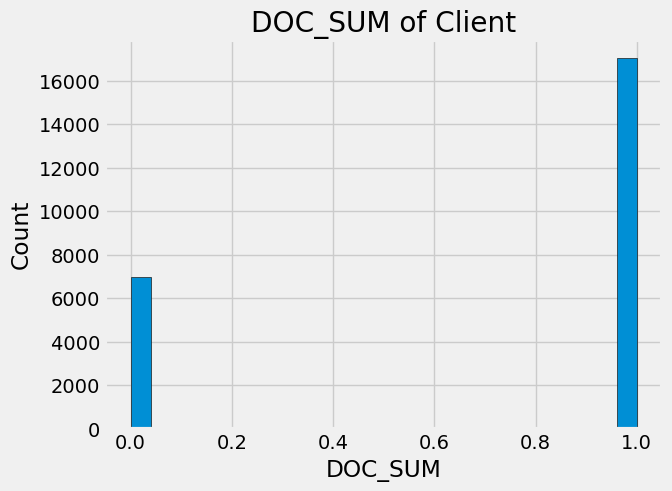

In [152]:
hist_stats('DOC_SUM')

In [153]:
df1['DOC_SUM_2_4'] = df1['FLAG_DOCUMENT_2'] + df1['FLAG_DOCUMENT_4'] 

0    23993
1        7
Name: DOC_SUM_2_4, dtype: int64

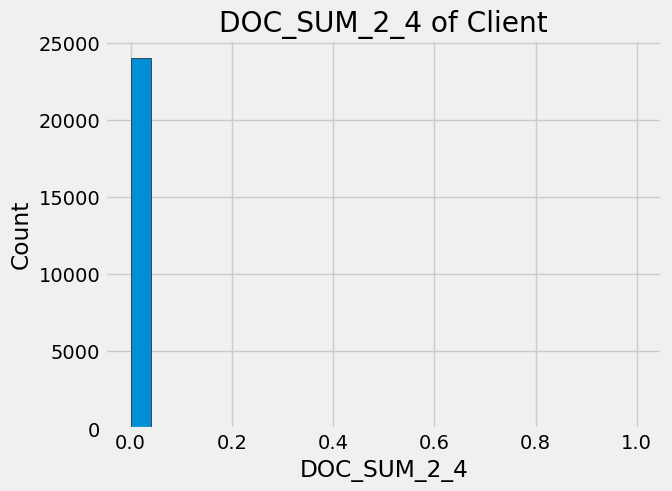

In [154]:
hist_stats('DOC_SUM_2_4')
df1['DOC_SUM_2_4'].value_counts()

* DOC_FLAG의 합을 구했지만 영향있는 값을 찾지 못함
* 서류를 하나도 제출하지 않는 경우는 있지만 2개이상 제출하는 경우는 없어보임.
* FLAG_DOCUMENT_2 또는 FLAG_DOCUMENT_4 를 제출한 사람은 연체를 하지 않았지만,
  매우 적은 모수이므로 단독사용시 과적합 유발할 수 있다고 판단하여 제외.
* 단, FALG_DOCUMENT_2 와 FLAG_DOCUMENT_4를 더한 값을 사용

In [155]:
df1['PHONE_SUM'] = df1['FLAG_WORK_PHONE'] + df1['FLAG_PHONE'] + df1['FLAG_EMAIL'] 

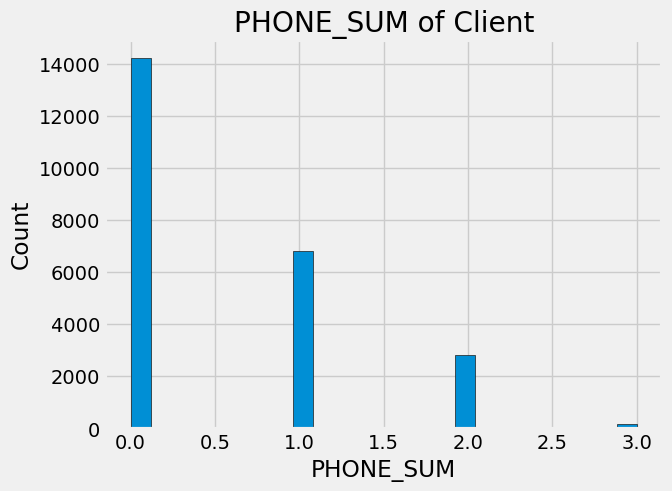

In [156]:
hist_stats('PHONE_SUM')

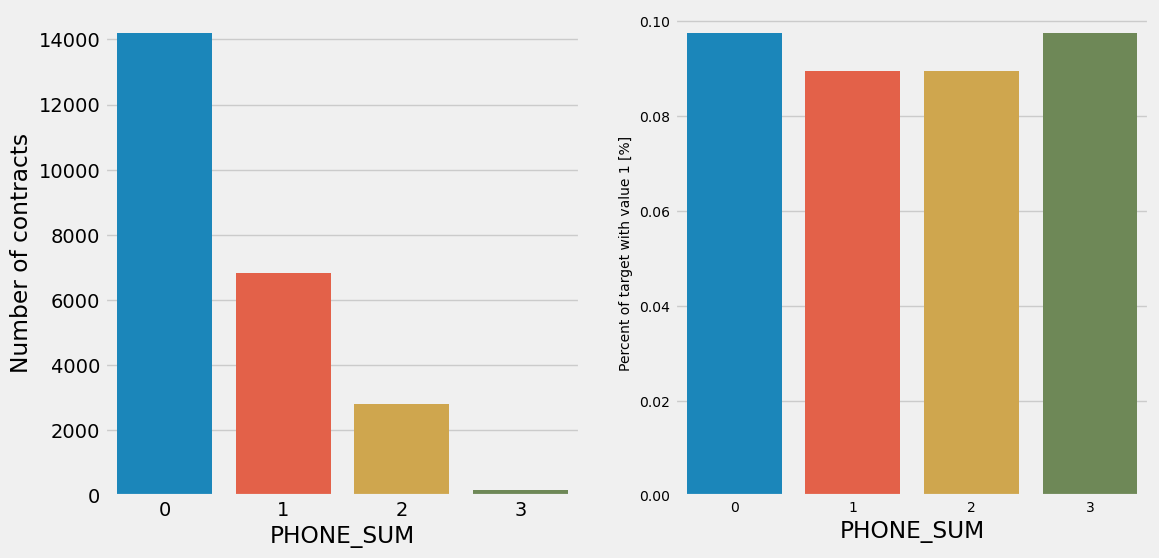

In [157]:
plot_stats('PHONE_SUM')

In [158]:
flag_groups = df1[['TARGET','PHONE_SUM']]
flag_groups['PHONE_SUM_MEAN'] = df1['PHONE_SUM']
flag_groups = flag_groups.groupby('PHONE_SUM_MEAN').mean()
flag_groups

TARGET  PHONE_SUM
PHONE_SUM_MEAN                     
0               0.085123        0.0
1               0.075660        1.0
2               0.089584        2.0
3               0.097561        3.0

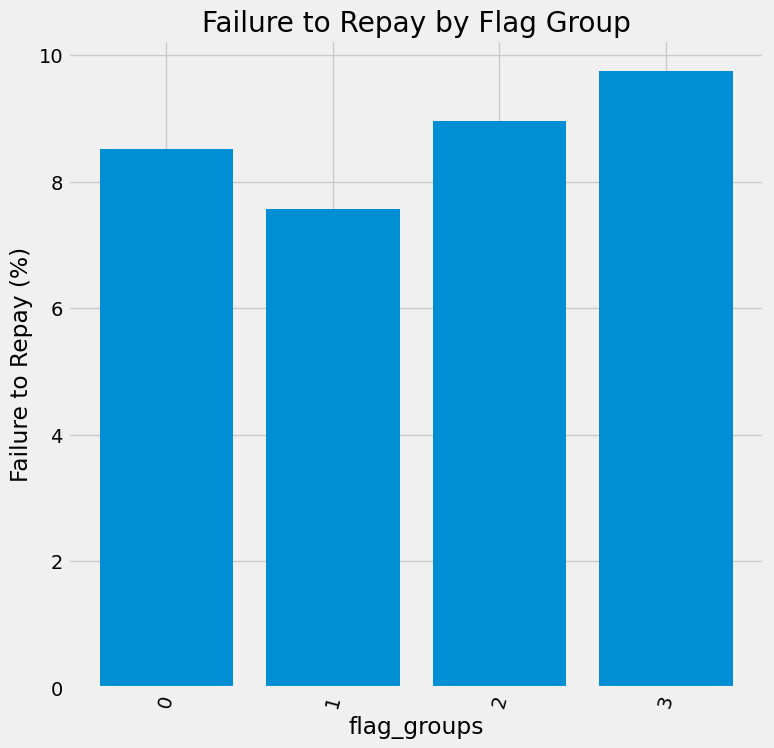

In [159]:
plt.figure(figsize = (8, 8))

plt.bar(flag_groups.index.astype(str), 100 * flag_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('flag_groups'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Flag Group');

* 정보를 하나도 등록하지 않은 경우를 제외하면 정보등록수가 많을수록 연쳬 확율이 높아짐.

In [160]:
df1['FLAG_SUM'] = df1['PHONE_SUM'] + df1['DOC_SUM']

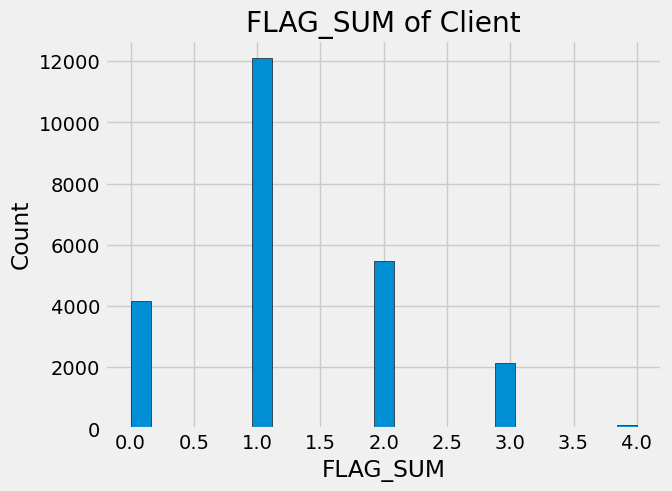

In [161]:
hist_stats('FLAG_SUM')

In [162]:
flag_groups = df1[['TARGET','FLAG_SUM']]
flag_groups['FLAG_SUM_MEAN'] = df1['FLAG_SUM']
flag_groups = flag_groups.groupby('FLAG_SUM_MEAN').mean()
flag_groups

TARGET  FLAG_SUM
FLAG_SUM_MEAN                    
0              0.061764       0.0
1              0.089361       1.0
2              0.079759       2.0
3              0.095372       3.0
4              0.112903       4.0

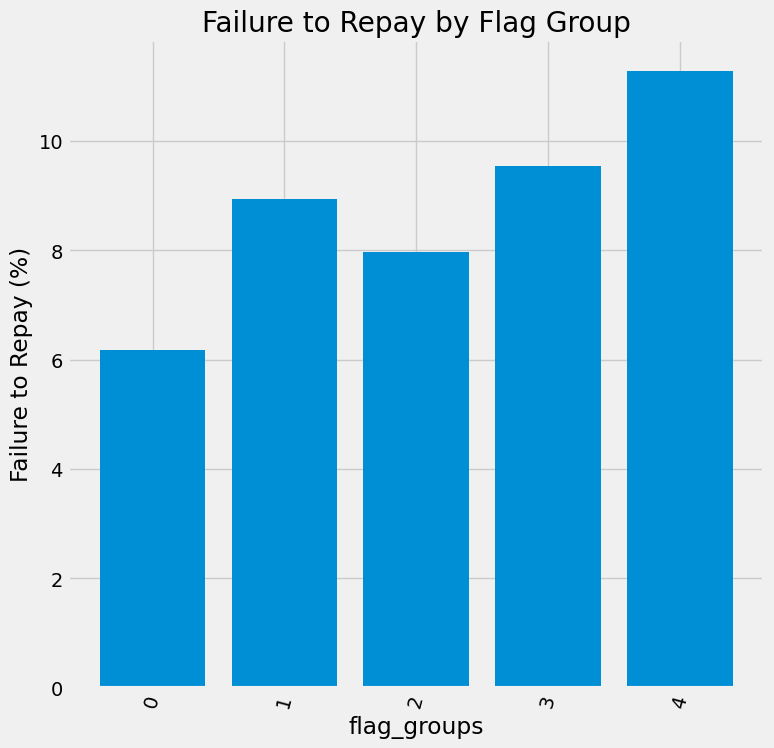

In [163]:
plt.figure(figsize = (8, 8))

plt.bar(flag_groups.index.astype(str), 100 * flag_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('flag_groups'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Flag Group');

* FLAG 수가 증가할 수록 대체적으로 연체 비율이 증가함.

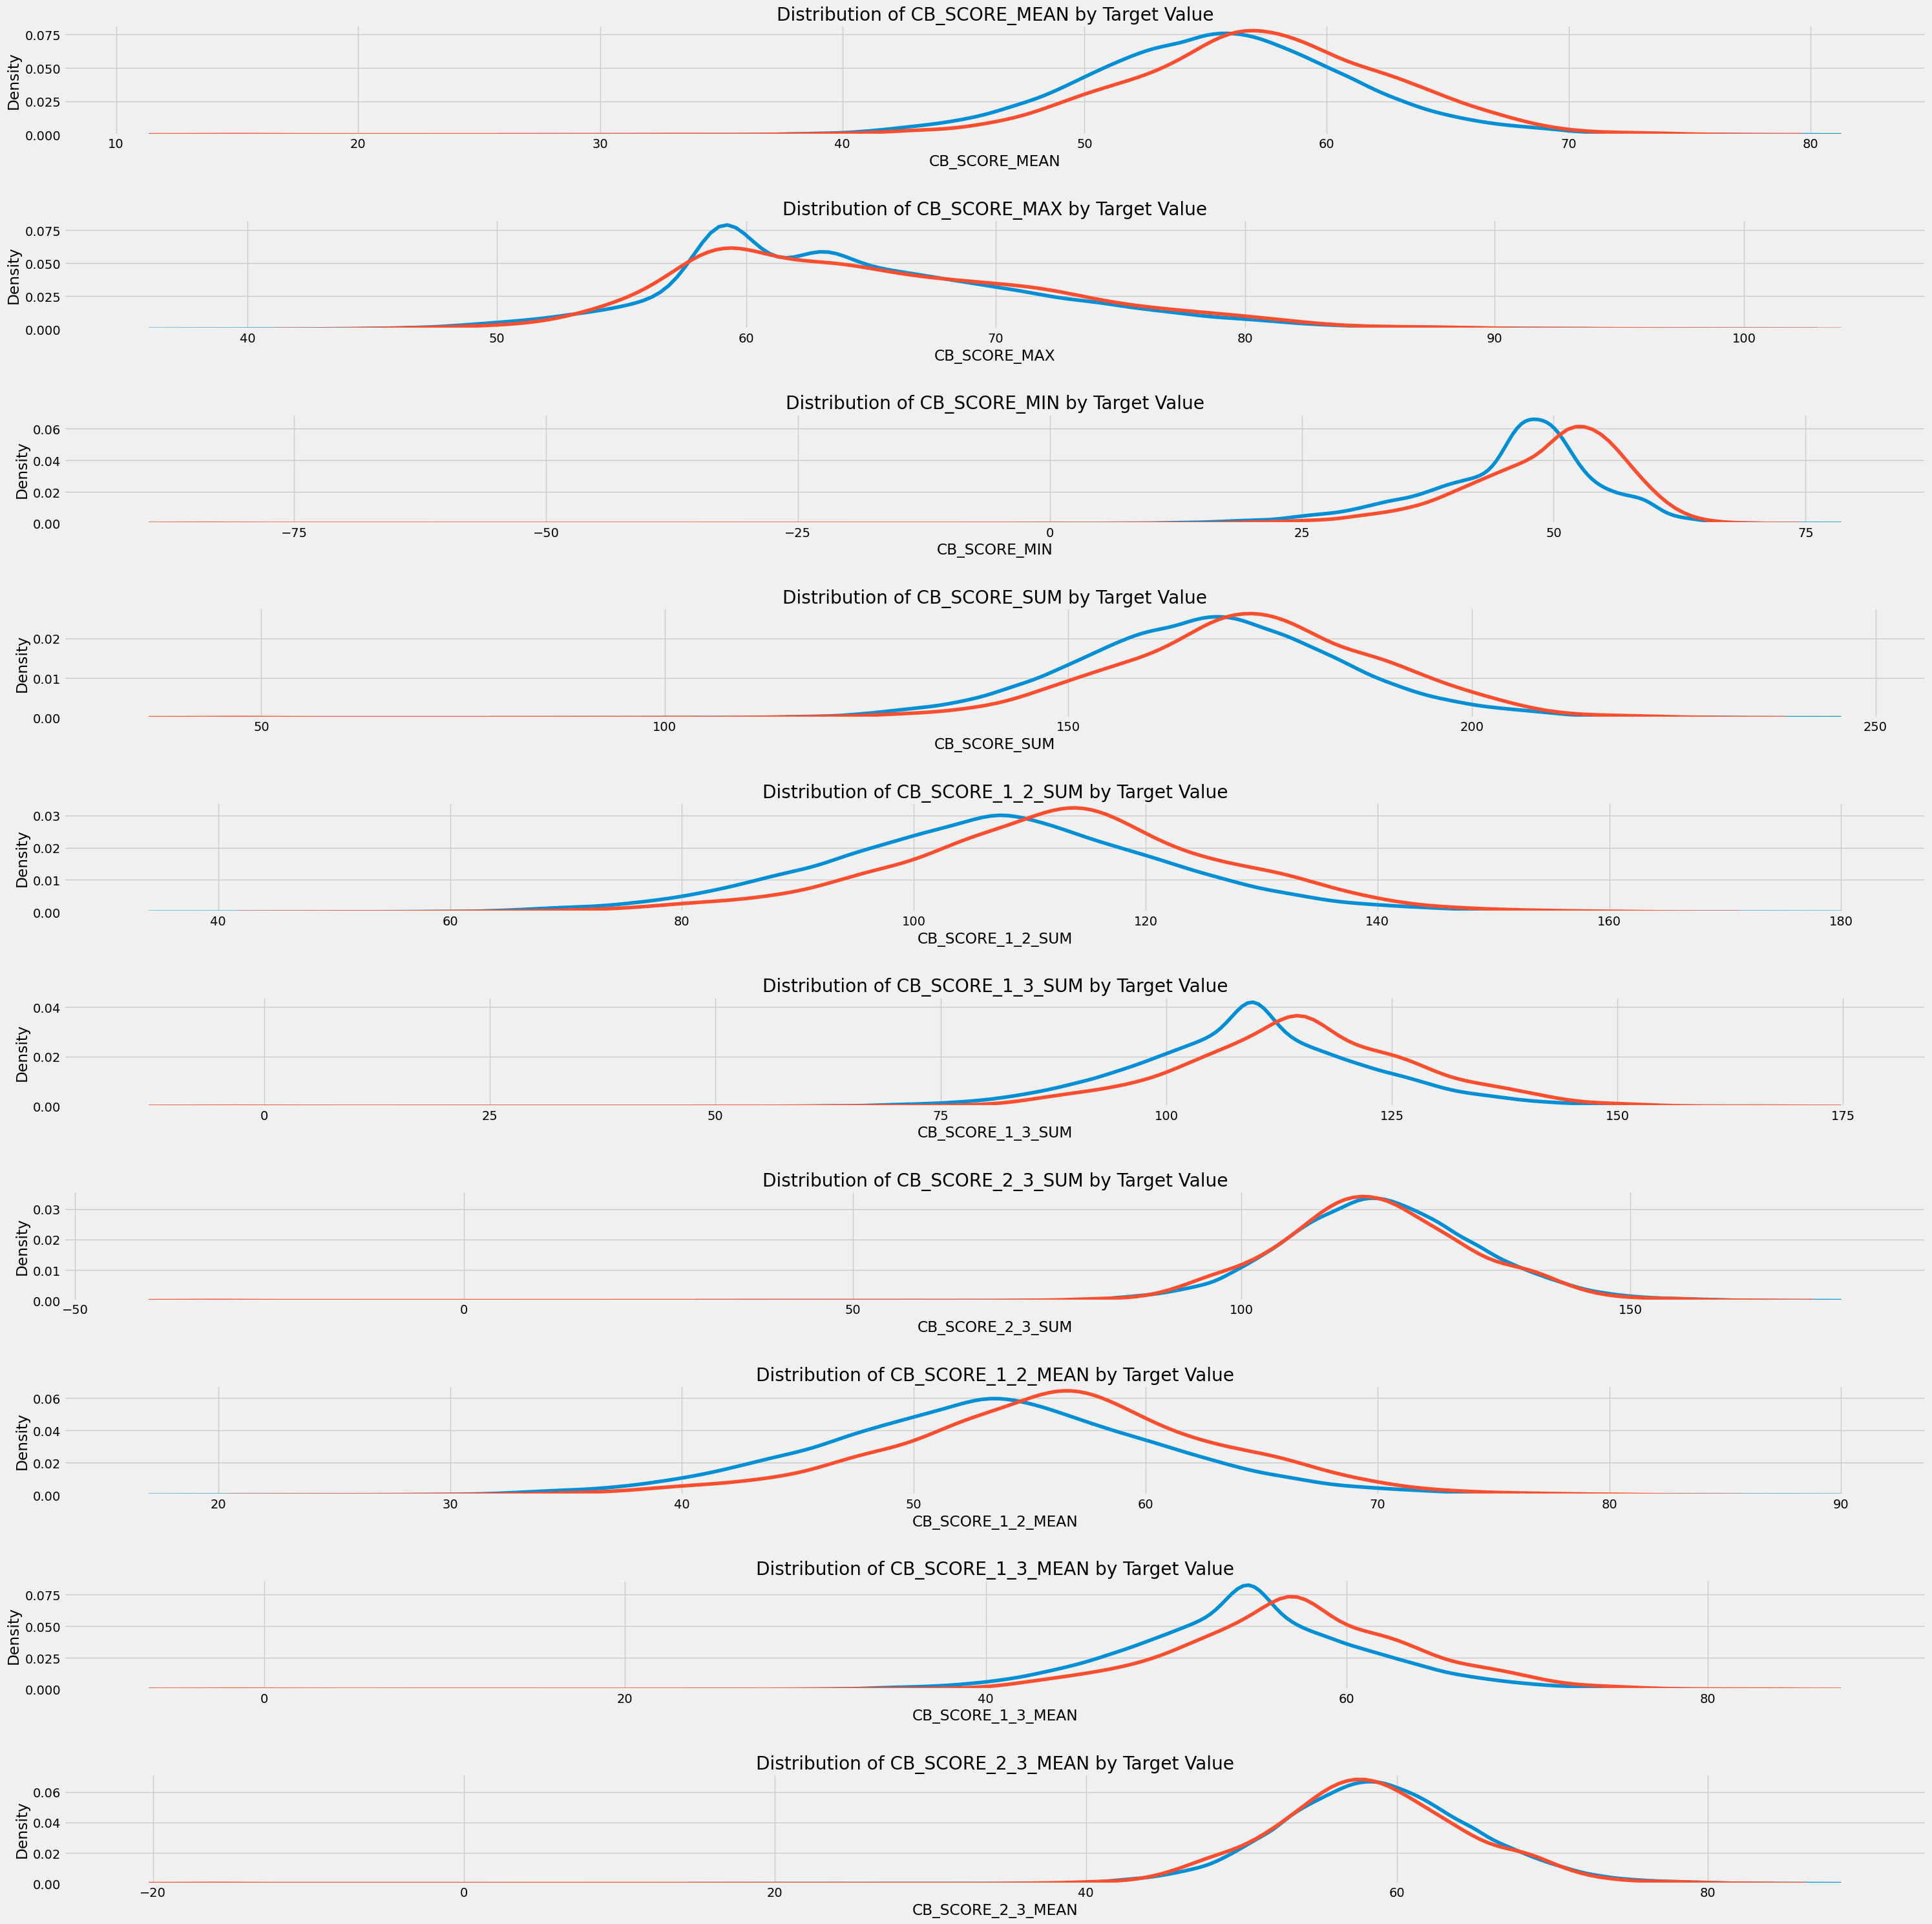

In [164]:
plt.figure(figsize = (30, 30))

for i, source in enumerate(['CB_SCORE_MEAN', 'CB_SCORE_MAX', 'CB_SCORE_MIN', 'CB_SCORE_SUM','CB_SCORE_1_2_SUM','CB_SCORE_1_3_SUM','CB_SCORE_2_3_SUM','CB_SCORE_1_2_MEAN','CB_SCORE_1_3_MEAN','CB_SCORE_2_3_MEAN']):
    
    plt.subplot(10, 1, i + 1)
    sns.kdeplot(df1.loc[df1['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(df1.loc[df1['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

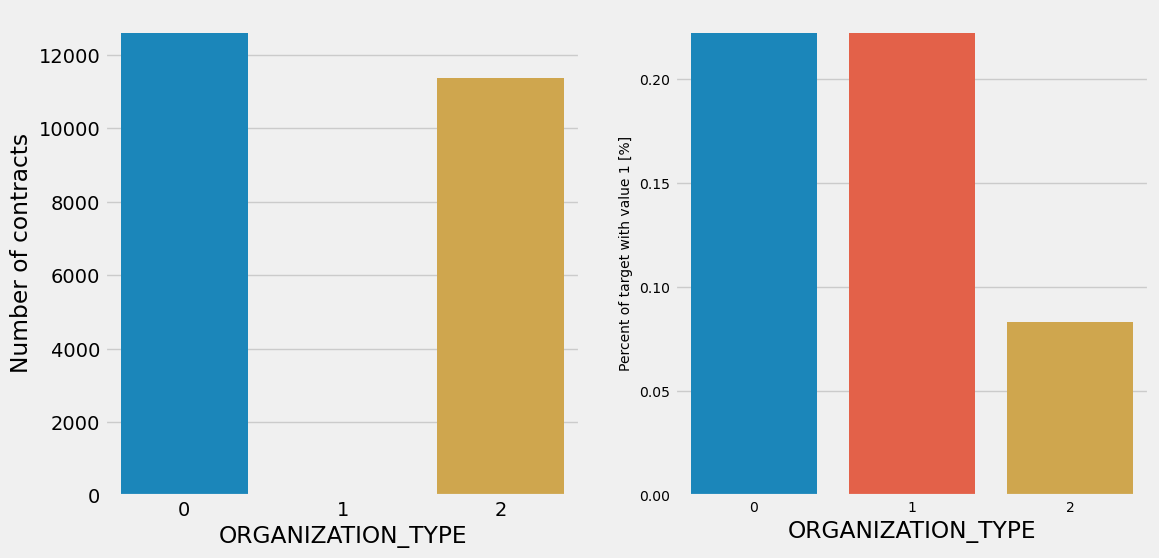

0    12607
2    11384
1        9
Name: ORGANIZATION_TYPE, dtype: int64

In [165]:
plot_stats('ORGANIZATION_TYPE')
df1['ORGANIZATION_TYPE'].value_counts()

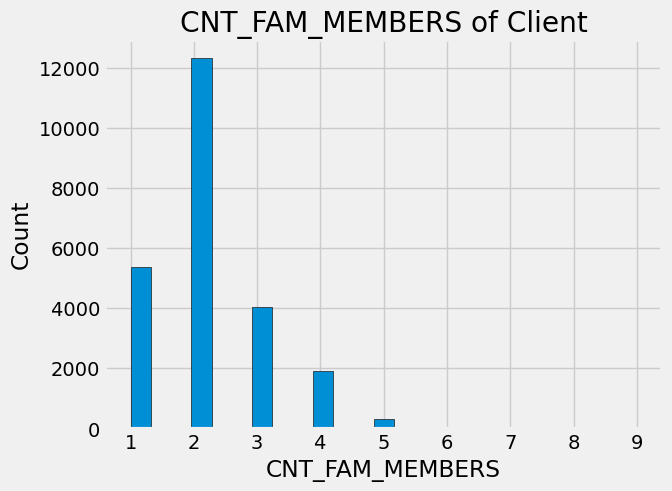

In [166]:
hist_stats('CNT_FAM_MEMBERS')

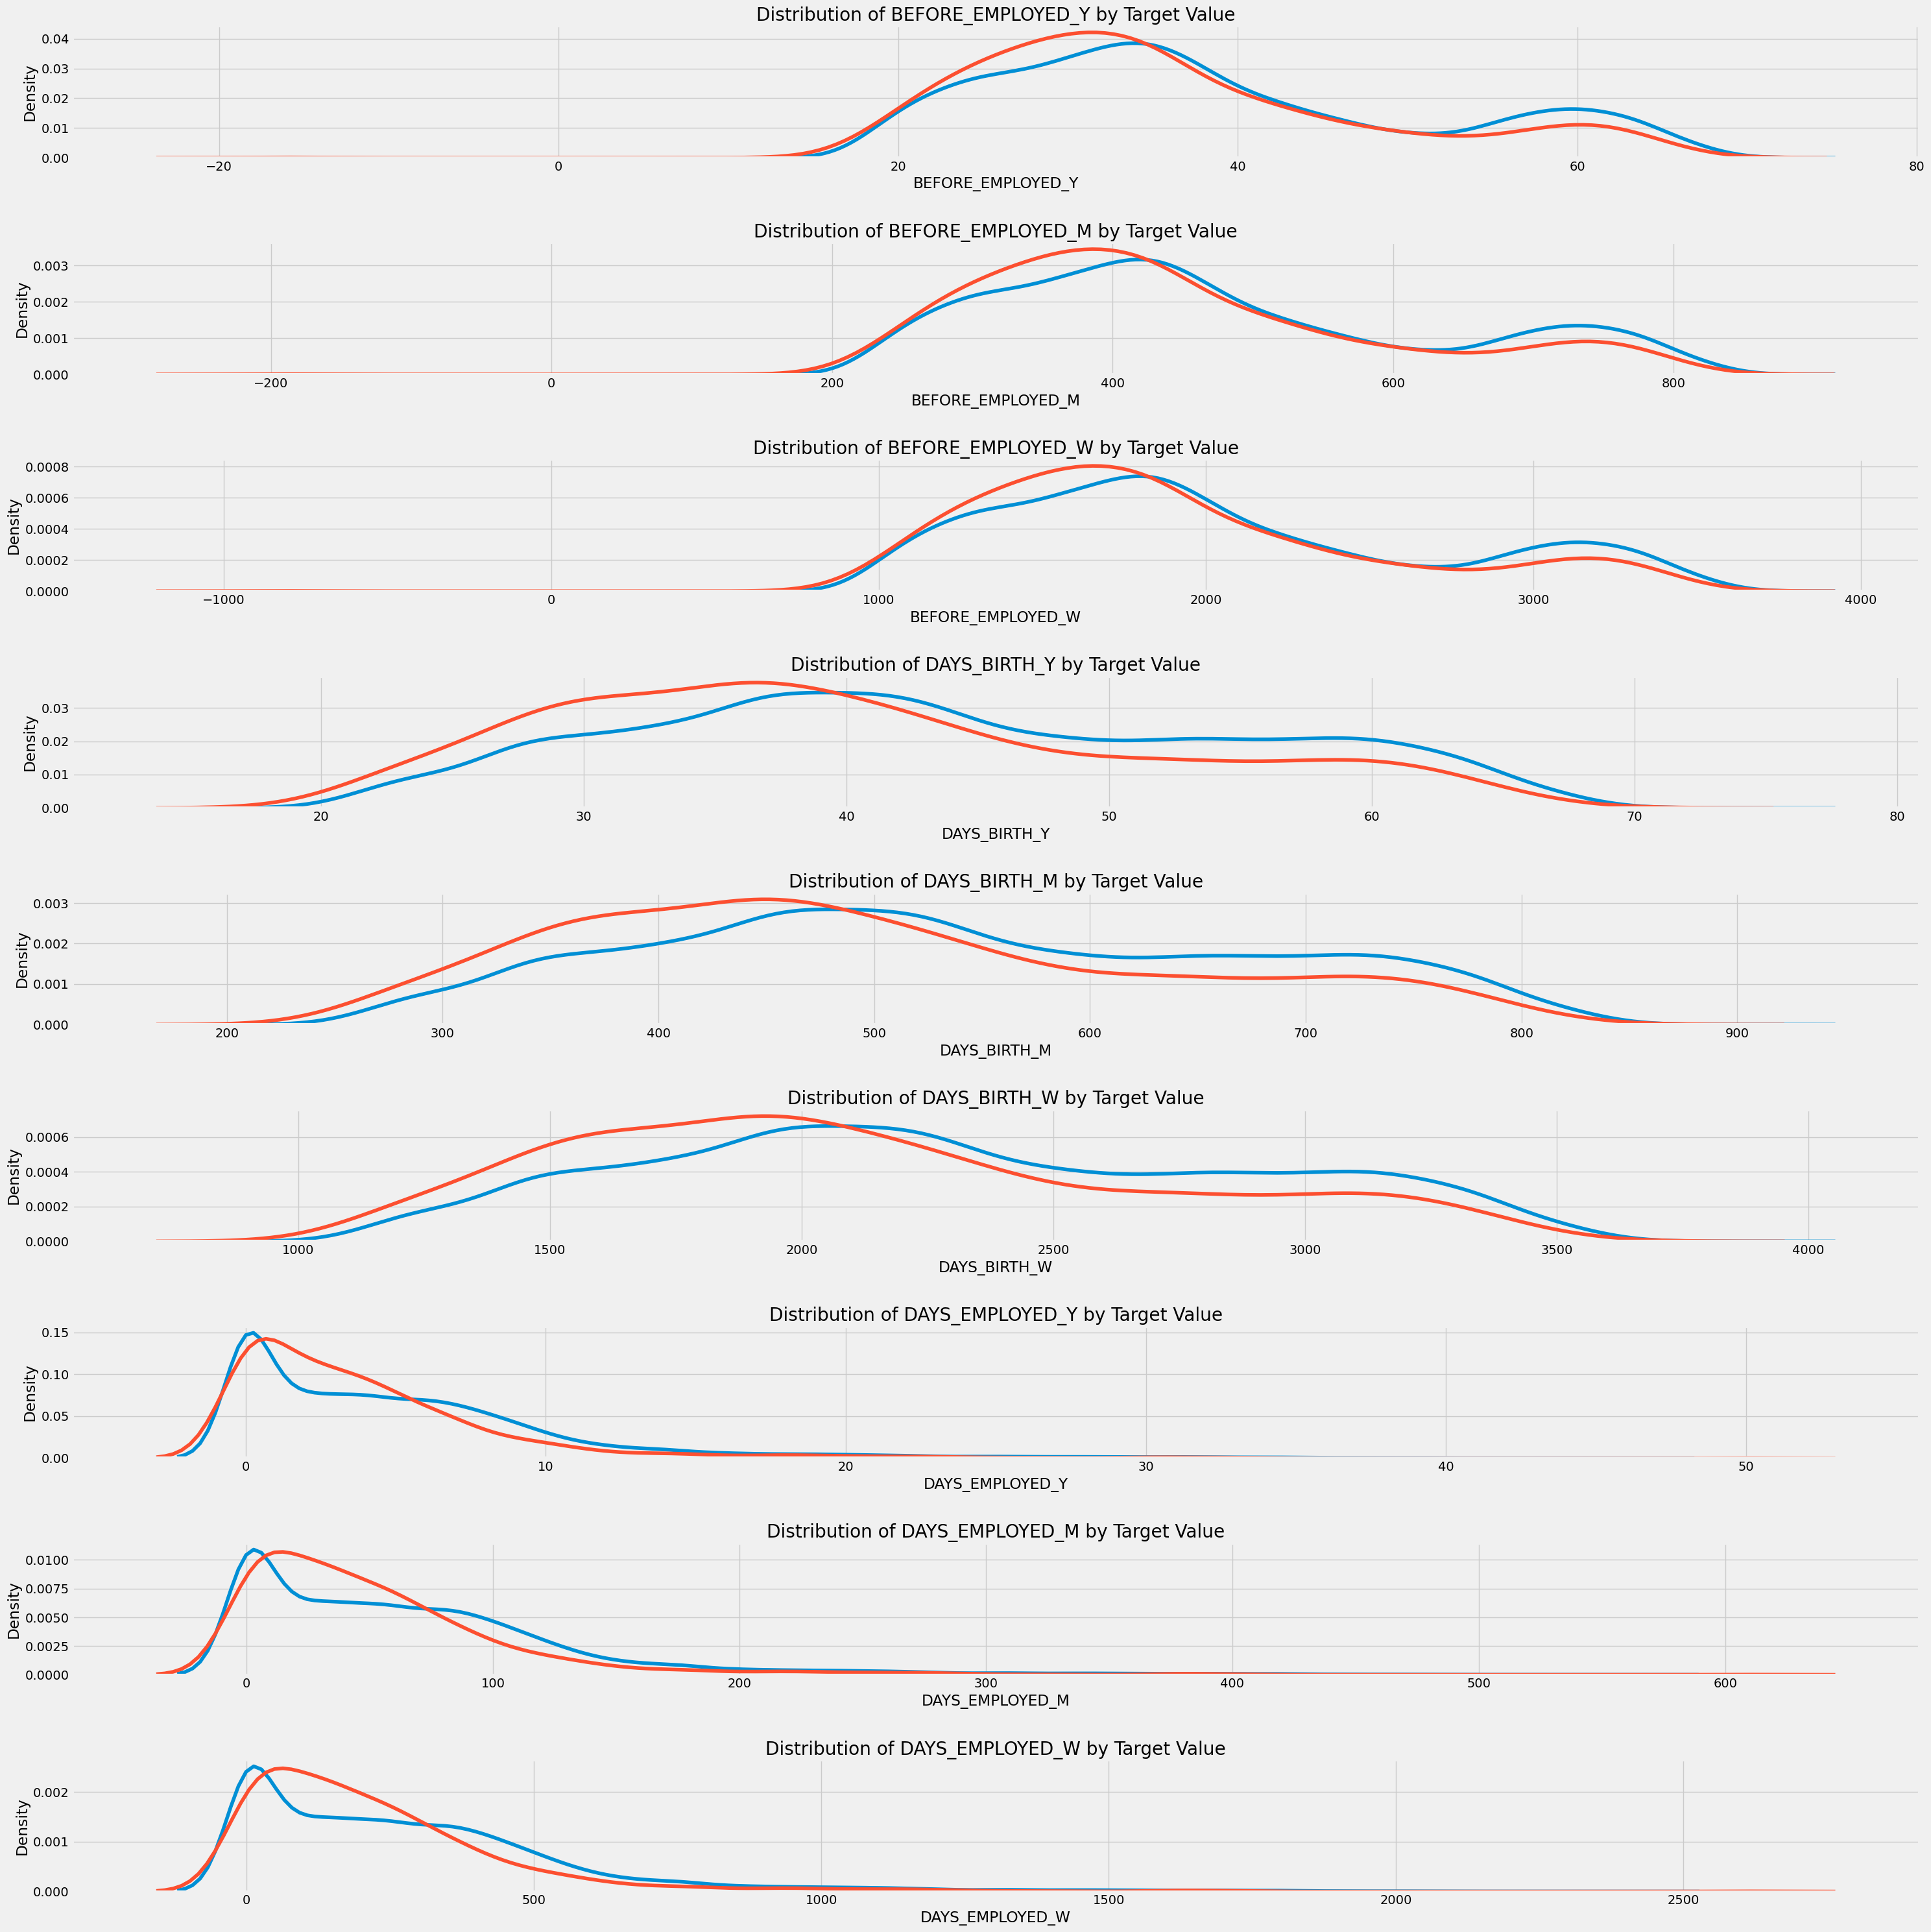

In [167]:
plt.figure(figsize = (30, 30))

for i, source in enumerate(['BEFORE_EMPLOYED_Y', 'BEFORE_EMPLOYED_M', 'BEFORE_EMPLOYED_W', 'DAYS_BIRTH_Y','DAYS_BIRTH_M','DAYS_BIRTH_W','DAYS_EMPLOYED_Y','DAYS_EMPLOYED_M','DAYS_EMPLOYED_W']):
    
    plt.subplot(9, 1, i + 1)
    sns.kdeplot(df1.loc[df1['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(df1.loc[df1['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

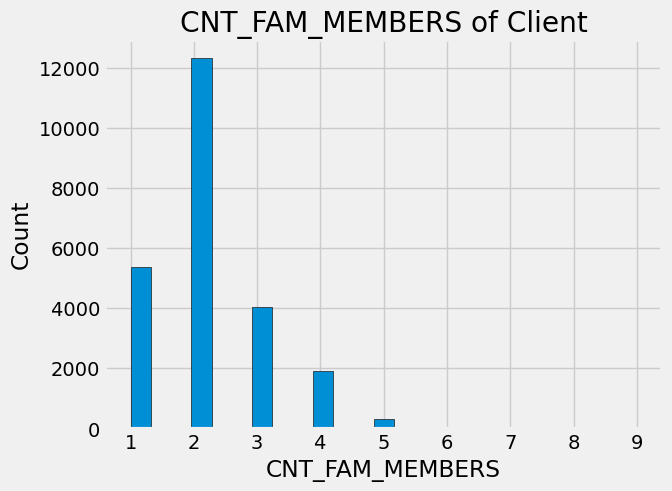

In [168]:
hist_stats('CNT_FAM_MEMBERS')

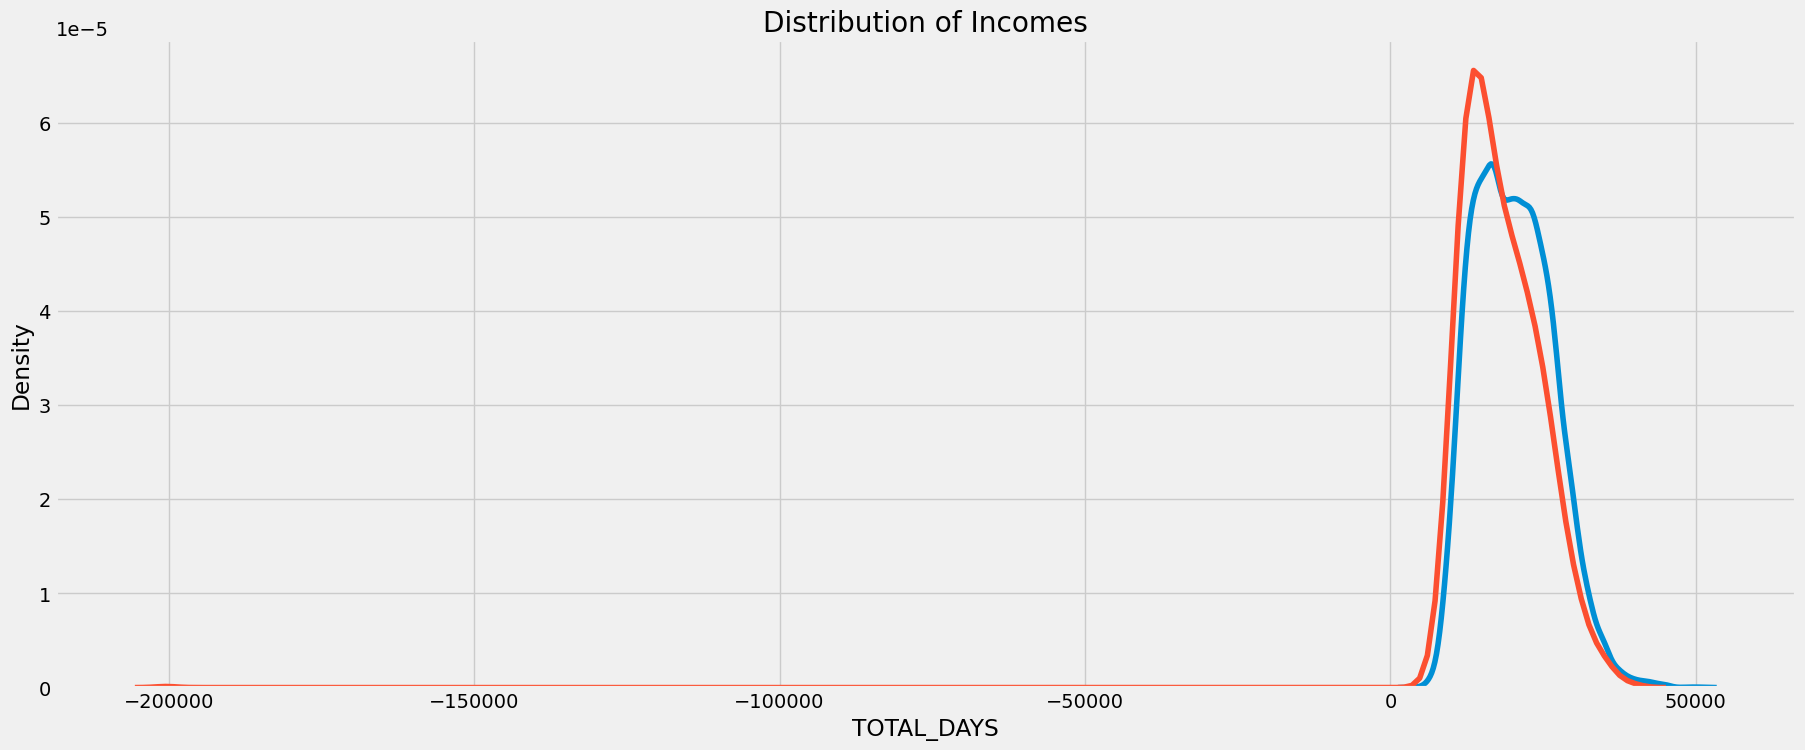

In [169]:
plt.figure(figsize = (20, 8))

sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'TOTAL_DAYS'], label = 'target == 0')
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'TOTAL_DAYS'], label = 'target == 1')

plt.xlabel('TOTAL_DAYS'); plt.ylabel('Density'); plt.title('Distribution of Incomes');


### 최종 Frame 선정

In [170]:
df_master = df_master.drop(['AMT_CREDIT'], axis=1)
df_master = df_master.drop(['AMT_INCOME_TOTAL'], axis=1)
df_master = df_master.drop(['DOC_SUM'], axis=1)
df_master = df_master.drop(['FLAG_DOCUMENT_4'], axis=1)
df_master = df_master.drop(['FLAG_DOCUMENT_2'], axis=1)
df_master = df_master.drop(['DAYS_EMPLOYED'], axis=1)
df_master = df_master.drop(['CB_SCORE_1_2_SUM'], axis=1)
df_master = df_master.drop(['CB_SCORE_1_3_SUM'], axis=1)
df_master = df_master.drop(['BEFORE_EMPLOYED_Y'], axis=1)
df_master = df_master.drop(['REGION_POPULATION_RELATIVE'], axis=1)

### 이상치 탐지

In [171]:
def remove_outlier(df_master, column):
    
    df = df_master[column]
    
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 5
    highest = quan_75 + iqr * 5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    print(df.iloc[outlier_index])
    df_master = df_master.drop(outlier_index, axis = 0)
    
    return df_master

In [172]:
candidate = ['CNT_CHILDREN']
for cand in candidate:  
    df_master = remove_outlier(df_master,cand)

df_master = df_master.reset_index(drop = True)
len(df_master)

outlier의 수 :  1
17202    7
Name: CNT_CHILDREN, dtype: int64


23999

### DataSet split

In [173]:
df_train, df_valid = train_test_split(df_master, test_size = 0.2, shuffle=True, random_state=12345)

In [174]:
df_train.shape, df_valid.shape

((19199, 63), (4800, 63))

In [175]:
x_train = df_train.drop(['TARGET'],axis=1)
y_train = df_train['TARGET']

In [176]:
x_valid = df_valid.drop(['TARGET'],axis=1)
y_valid = df_valid['TARGET']

### Data Scaling

In [177]:
mms = MinMaxScaler()
mms.fit(x_train)

x_train_scaled = mms.transform(x_train)
x_valid_scaled = mms.transform(x_valid)

## 5. Modeling

AUC : 0.7327451228247588


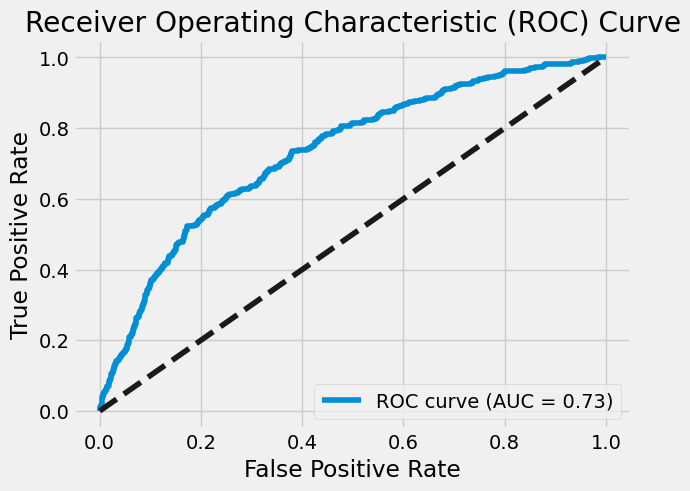

In [178]:
# Fit a logistic regression model
logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)

# Predict probabilities of target values for test set
y_prob = logreg.predict_proba(x_valid_scaled)

# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, thresholds = roc_curve(y_valid, y_prob[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_valid, y_prob[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


print("AUC :",roc_auc_score(y_valid, y_prob[:, 1]))

AUC for Decision Tree: 0.5681582606497282
AUC for Logistic Regression: 0.7327451228247588
AUC for SVM: 0.5785648674840939
The Logistic Regression model has the highest AUC


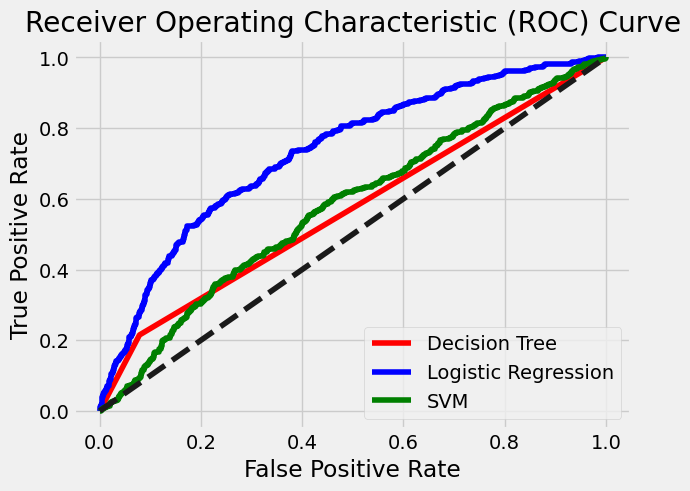

In [179]:
# Fit different classification models
dtc = DecisionTreeClassifier()
dtc.fit(x_train_scaled, y_train)

logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)

svm = SVC(probability=True)
svm.fit(x_train_scaled, y_train)

# Predict probabilities of target values for test set
y_prob_dtc = dtc.predict_proba(x_valid_scaled)
y_prob_logreg = logreg.predict_proba(x_valid_scaled)
y_prob_svm = svm.predict_proba(x_valid_scaled)

# Calculate the fpr and tpr for all thresholds of each classification model
fpr_dtc, tpr_dtc, _ = roc_curve(y_valid, y_prob_dtc[:, 1])
fpr_logreg, tpr_logreg, _ = roc_curve(y_valid, y_prob_logreg[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_valid, y_prob_svm[:, 1])

# Plot the ROC curves for all models on the same plot
plt.plot(fpr_dtc, tpr_dtc, color='red', label='Decision Tree')
plt.plot(fpr_logreg, tpr_logreg, color='blue', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, color='green', label='SVM')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Calculate the AUC for each model and print them
auc_dtc = roc_auc_score(y_valid, y_prob_dtc[:, 1])
auc_logreg = roc_auc_score(y_valid, y_prob_logreg[:, 1])
auc_svm = roc_auc_score(y_valid, y_prob_svm[:, 1])

print('AUC for Decision Tree:', auc_dtc)
print('AUC for Logistic Regression:', auc_logreg)
print('AUC for SVM:', auc_svm)

# Determine the model with the maximum AUC
max_auc = max(auc_dtc, auc_logreg, auc_svm)
if max_auc == auc_dtc:
    print('The Decision Tree model has the highest AUC')
elif max_auc == auc_logreg:
    print('The Logistic Regression model has the highest AUC')
else:
    print('The SVM model has the highest AUC')

plt.show()

In [180]:
# LightGBM을 이용해 학습 및 검증 진행
lgb = LGBMClassifier(max_depth = 4,
                    n_estimators = 10000,
                    n_jobs = 30,
                    min_child_weight = 10,
                    learning_rate = 0.02,
                    objective = 'binary',
                    reg_alpha=0.001,
                    random_state = 2023)

model_lgb = lgb.fit(x_train_scaled, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [181]:
print('The LGBM model has the highest AUC:', roc_auc_score(y_valid,model_lgb.predict(x_valid_scaled)))

The LGBM model has the highest AUC: 0.5433362828129608


### 5-1 Features importance

<Axes: ylabel='Feature'>

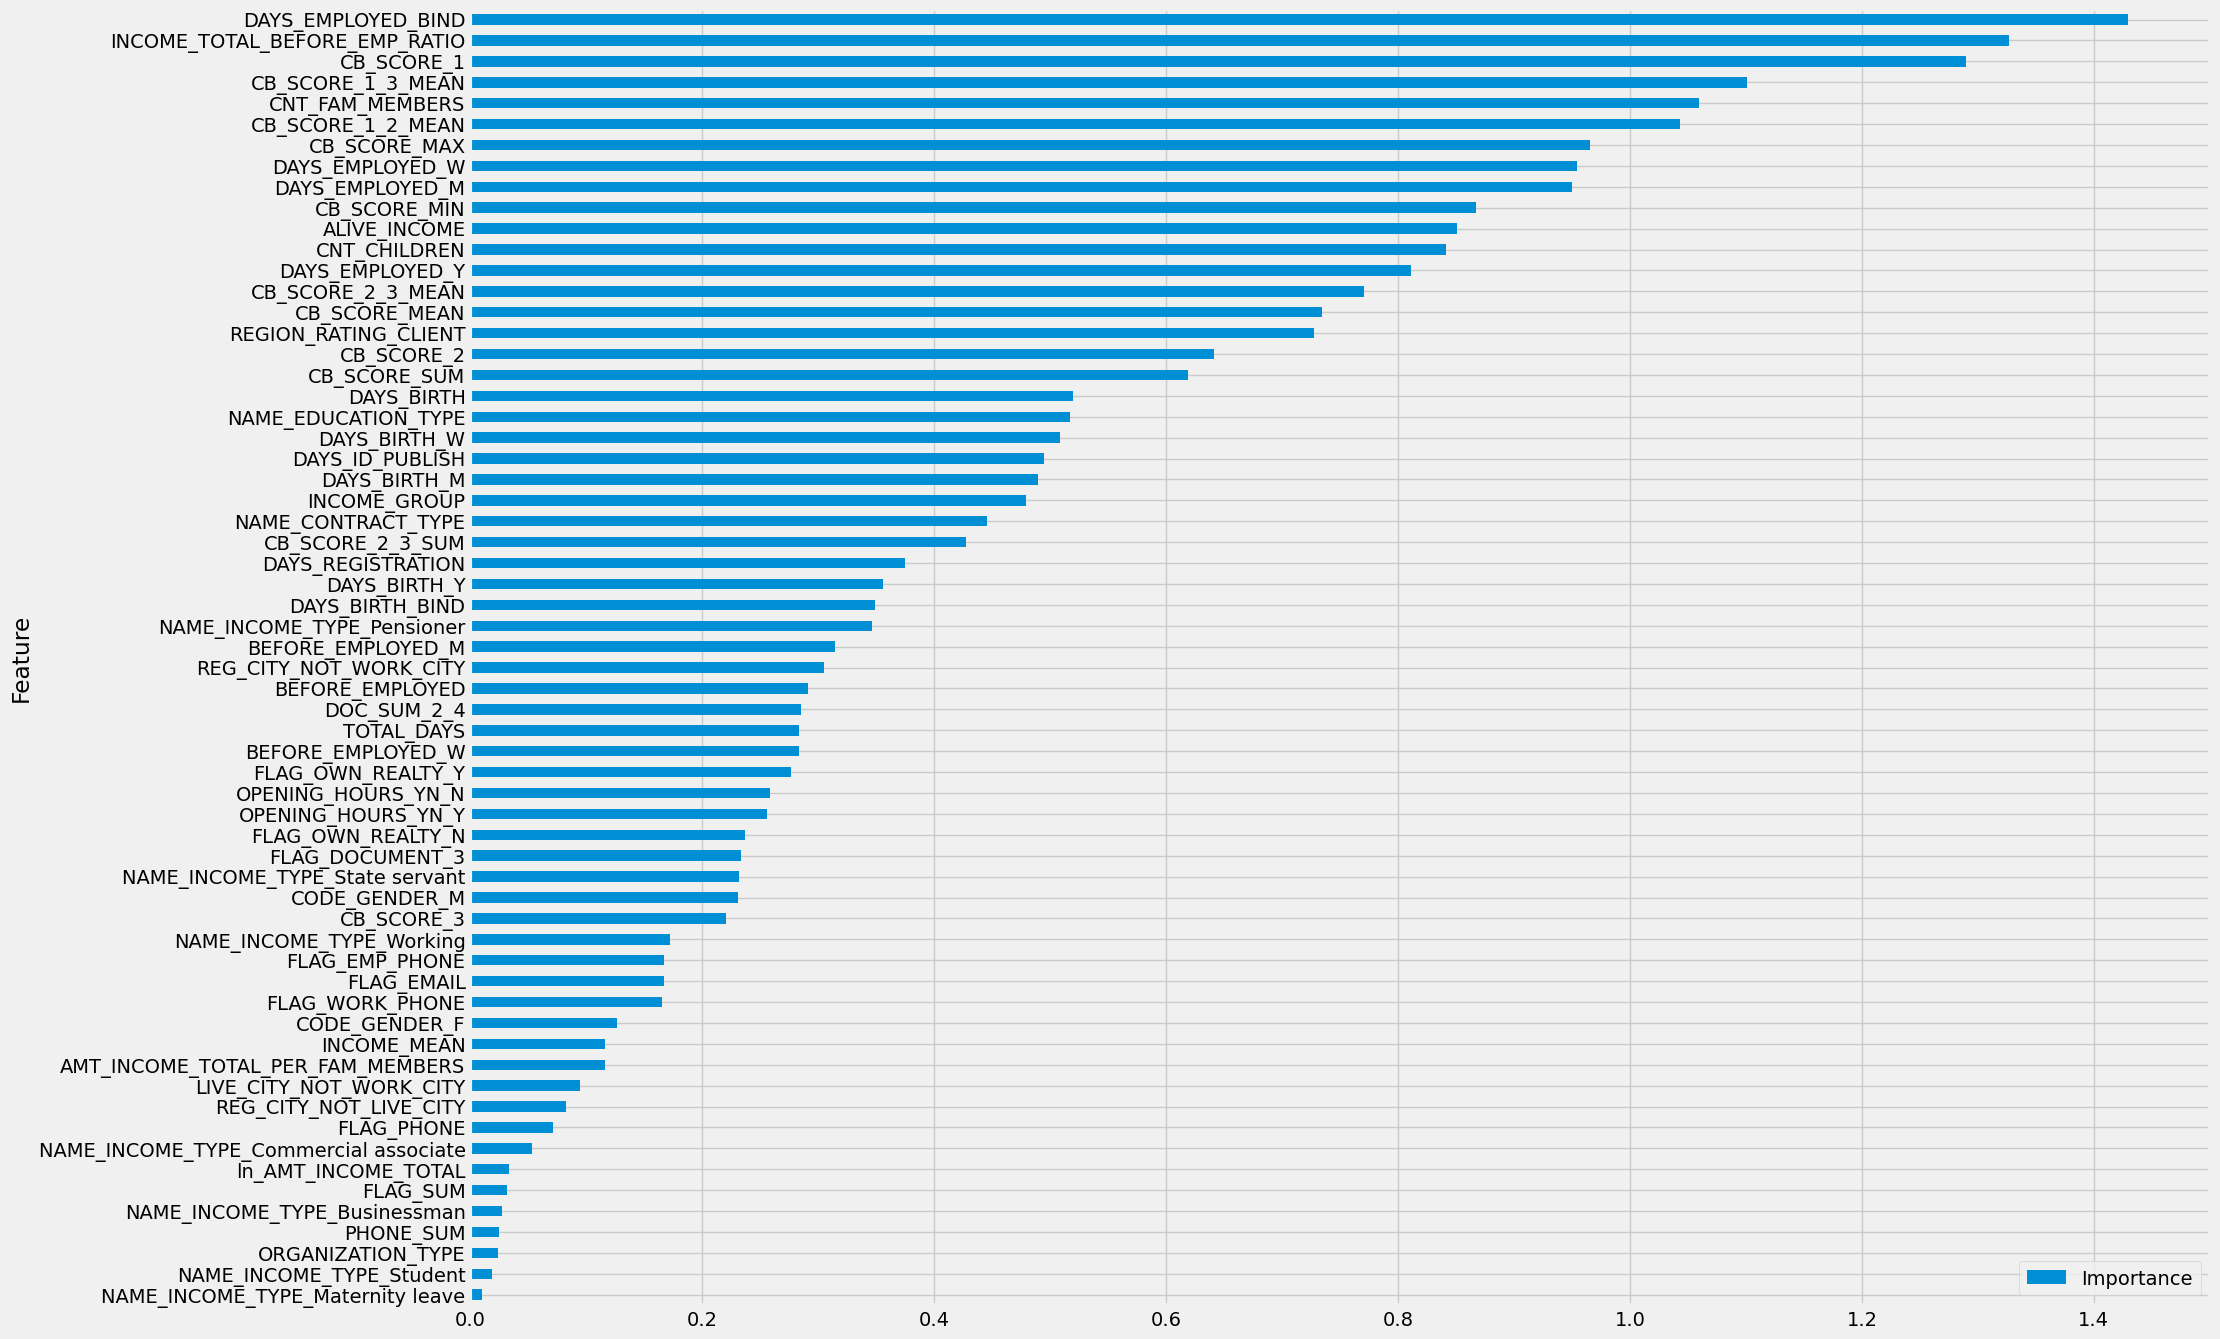

In [182]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20,16))

## 6. 최종평가

1. 결과
- Logistic Regression, Decision Tree, SVM, LGBMClassifier 
  모형 분석 결과 중 AUC가 가장 높았던 Logistic Regression을 
  최종모델로 선정하여 분석
- 고객은 연령대, CB_SCORE, 소득, 근무일수, 가족구성원 의 값들이 비교적 높은 중요성을 나타냄

2. 기대효과 및 업무 적용성
- 대출 신청 하는 고객의 신용점수, 소득금액 등의 정량적인 데이터와 
  인구학적, 행동적인 특성의 정성적인 데이터로 새로운 변수를 만들고  
  입력 하지 못한 정보는 입력된 정보를 활용하여 예측값으로 처리
  하여 모델링에 활용할 수 있을것으로 기대함.
- 개발된 모델을 활용하여 연체 경험이 있는 고객군을 특정할 수 있
  으며, 해당 고객군의 한도 축소 또는 금리를 높게 산출 등 대출 
  승인 및 금리 결정에 효율적인 수행 더 나아가 대출승인 자체를 
  막아 심사를 까다롭게 함으로써 연체 가능성을 낮추는데 기여 할
  것으로 기대함.

## 7. Hidden DataSet 평가를 위한 함수 생성

In [183]:
#x_test = pd.read_csv('./loan_customer.csv')

In [184]:
def test_transform(x_test):
    
    # NAME_CONTRACT_TYPE 0 OR 1 ENCODING
    x_test['NAME_CONTRACT_TYPE'] = x_test['NAME_CONTRACT_TYPE'].apply(lambda x: 1 if x =='Cash loans' else 0)
    
    # EDA 결과 연체율에 영향이 있다고 판단한 고학력인 값들인지 아닌지 판단하기 위한 작업
    def func_NAME_EDUCATION_TYPE(x):
        if x in ('Higher education', 'Academic degree'):
            return 1
        else:
            return 0
    
    # 위에서 사용한 함수의 결과값으로 NAME_EDUCATION_TYPE의 값을 대체
    x_test['NAME_EDUCATION_TYPE'] = x_test['NAME_EDUCATION_TYPE'].apply(func_NAME_EDUCATION_TYPE)
    
    # EDA 결과 연체율에 영향이 있다고 판단한 직업군인 값들인지 아닌지 판단하기 위한 작업
    def func_ORGANIZATION_TYPE(x):
        if x in ('Trade: type 5', 'Industry: type 13'):
            return 1
        elif x in ('Business Entity Type 3', 'XNA', 'Self-employed'):
            return 0
        else:
            return 2
    
    # 위에서 사용한 함수의 결과값으로 ORGANIZATION_TYPE 값을 대체
    x_test['ORGANIZATION_TYPE'] = x_test['ORGANIZATION_TYPE'].apply(func_ORGANIZATION_TYPE)
    
    # 결혼의 유무와 아이의 수를 가지고 총 가족구성원의 수를 예측.
    x_test.loc[x_test['NAME_FAMILY_STATUS']     == 'Married', 'CNT_FAM_MEMBERS'] = x_test['CNT_CHILDREN'] + 2
    x_test.loc[x_test['NAME_FAMILY_STATUS']     == 'Civil marriage', 'CNT_FAM_MEMBERS'] = x_test['CNT_CHILDREN'] + 2
    x_test.loc[x_test['CNT_FAM_MEMBERS'].isna() == True, 'CNT_FAM_MEMBERS'] = x_test['CNT_CHILDREN'] + 1
    
    # 소득금액과 가족 구성원 수를 가지고 구성원당 소득금액을 산출.
    x_test['AMT_INCOME_TOTAL_PER_FAM_MEMBERS'] = x_test['AMT_INCOME_TOTAL'] / x_test['CNT_FAM_MEMBERS']
    
    # 대출실행요일 및 시간을 가지고 영업시간내 대출실행 여부를 파악. 
    x_test['HOUR_APPR_PROCESS_START'] = x_test['HOUR_APPR_PROCESS_START'].astype(int)
    
    # 대출실행 요일과 시간을 문자열로 합하여 데이터 생성
    df_date = x_test['WEEKDAY_APPR_PROCESS_START'] + x_test['HOUR_APPR_PROCESS_START'].astype(str)    
    temp = df_date.to_frame()
    # 생성한 데이터 컬럼명 지정 : OPENING_HOURS_YN 
    temp.columns=['OPENING_HOURS_YN']
    
    # Saturday,Sunday로 시작한 데이터는 영업시간 외 모바일 대출로 취급 
    temp.loc[temp['OPENING_HOURS_YN'].str.startswith('SUNDAY'), 'OPENING_HOURS_YN'] = 'N'
    temp.loc[temp['OPENING_HOURS_YN'].str.startswith('SATURDAY'), 'OPENING_HOURS_YN'] = 'N'

    # 주말을 제외한 9시~18시 까지의 데이터는 영업시간 내 대출로 취급 
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY9'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY10'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY11'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY12'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY13'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY14'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY15'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY16'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY17'), 'OPENING_HOURS_YN'] = 'Y'
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY18'), 'OPENING_HOURS_YN'] = 'Y'

    # 이후 평일 나머지 시간대는 영업시간 외 모바일 대출로 취급
    temp.loc[temp['OPENING_HOURS_YN'].str.contains('DAY'), 'OPENING_HOURS_YN'] = 'N'
    

    # 필요없는 컬럼 삭제    
    x_test = x_test.drop(['WEEKDAY_APPR_PROCESS_START'], axis=1)
    x_test = x_test.drop(['HOUR_APPR_PROCESS_START'], axis=1)
    x_test = x_test.drop(['FLAG_MOBIL'], axis=1)
    x_test = x_test.drop(['NAME_FAMILY_STATUS'], axis=1)
    x_test = x_test.drop(['NAME_HOUSING_TYPE'], axis=1)
    
    x_test = x_test.join(temp, how='left')    
    
    # 소득구간을 금액단위로 묶음 처리
    def income_grouping(x):
        if x < 100000 :
            return 10000
        elif x < 200000 :
            return 100000
        elif x < 300000. :
            return 200000 
        elif x < 400000 :
            return 300000
        elif x < 500000 :
            return 400000
        return 500000
    
    
    x_test['INCOME_GROUP'] = x_test['AMT_INCOME_TOTAL'].apply(income_grouping)
    
    # 소득금액을 log 변환하여 처리 
    x_test['ln_AMT_INCOME_TOTAL'] = np.log(x_test['AMT_INCOME_TOTAL'])
    

    # 알아보기 쉽게 양수로 변경
    x_test['DAYS_BIRTH'] = x_test['DAYS_BIRTH'] * -1
    x_test['DAYS_EMPLOYED'] = x_test['DAYS_EMPLOYED'] * -1
    x_test['DAYS_REGISTRATION'] = x_test['DAYS_REGISTRATION'] * -1
    x_test['DAYS_ID_PUBLISH'] = x_test['DAYS_ID_PUBLISH'] * -1

    x_test.loc[(x_test['DAYS_EMPLOYED'] < 0), 'DAYS_EMPLOYED'] = 0
    x_test.loc[(x_test['DAYS_EMPLOYED'] > 36500), 'DAYS_EMPLOYED'] = 18250
    
    # before_EMPLOYED: 고용되기 전까지의 일수
    x_test['BEFORE_EMPLOYED'] = x_test['DAYS_BIRTH'] - x_test['DAYS_EMPLOYED']
    x_test['INCOME_TOTAL_BEFORE_EMP_RATIO'] = x_test['AMT_INCOME_TOTAL'] / x_test['BEFORE_EMPLOYED']
    x_test['BEFORE_EMPLOYED_Y'] = np.floor(x_test['BEFORE_EMPLOYED'] / 365).astype(int)
    x_test['BEFORE_EMPLOYED_M'] = np.floor(x_test['BEFORE_EMPLOYED'] / 30).astype(int)
    x_test['BEFORE_EMPLOYED_W'] = np.floor(x_test['BEFORE_EMPLOYED'] / 7).astype(int)

    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)    
    x_test['DAYS_BIRTH_Y'] = np.floor(x_test['DAYS_BIRTH'] / 365).astype(int)
    x_test['DAYS_BIRTH_M'] = np.floor(x_test['DAYS_BIRTH'] / 30).astype(int)
    x_test['DAYS_BIRTH_W'] = np.floor(x_test['DAYS_BIRTH'] / 7).astype(int)

    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    x_test['DAYS_EMPLOYED_Y'] = np.floor(x_test['DAYS_EMPLOYED'] / 365).astype(int)
    x_test['DAYS_EMPLOYED_M'] = np.floor(x_test['DAYS_EMPLOYED'] / 30).astype(int)
    x_test['DAYS_EMPLOYED_W'] = np.floor(x_test['DAYS_EMPLOYED'] / 7).astype(int)

    #ability: 소득/(살아온 일수+ 근무일수)
    x_test['ALIVE_INCOME'] = x_test['AMT_INCOME_TOTAL'] / (x_test['DAYS_BIRTH'] + x_test['DAYS_EMPLOYED'])

    #income_mean: 소득/ 가족 수
    x_test['INCOME_MEAN'] = x_test['AMT_INCOME_TOTAL'] / x_test['CNT_FAM_MEMBERS']

    # 나이 그룹을 10살 단위로 묶음    
    def birth_grouping(x):
        if x < 10 :
            return 0
        elif x < 20 :
            return 10
        elif x < 30. :
            return 20
        elif x < 40 :
            return 30
        elif x < 50 :
            return 40
        elif x < 60 :
            return 50
        elif x < 70 :
            return 60
        elif x < 80 :
            return 70
        elif x < 90 :
            return 80
        elif x < 100 :
            return 90    
        return 100

    x_test['DAYS_BIRTH_BIND'] = x_test['DAYS_BIRTH_Y'].apply(birth_grouping)
    
    # employed 그룹을 10살 단위로 묶음
    def employed_grouping(x):
        if x < 10 :
            return 0
        elif x < 20 :
            return 10
        elif x < 30. :
            return 20
        elif x < 40 :
            return 30
        elif x < 50 :
            return 40
        elif x < 60 :
            return 50
        elif x < 70 :
            return 60
        elif x < 80 :
            return 70
        elif x < 90 :
            return 80
        elif x < 100 :
            return 90    
        return 100

    x_test['DAYS_EMPLOYED_BIND'] = x_test['DAYS_EMPLOYED_Y'].apply(employed_grouping)

    # 나이 + 근무일수 + 등록정보견경일수 - 신분증변경일수
    # 기간이 짧을수록 연체비율이 높은 나이, 근무일수, 등록정보변경일수를 더한값에 기간이 길수록 연체비율이 높은 신분증 변경시점을 뺀값.
    x_test['TOTAL_DAYS'] = x_test['DAYS_BIRTH'] + x_test['DAYS_EMPLOYED'] + x_test['DAYS_REGISTRATION'] - x_test['DAYS_ID_PUBLISH']
    
    # DOC_FLAG 합산
    x_test['DOC_SUM_2_4'] = x_test['FLAG_DOCUMENT_2'] + x_test['FLAG_DOCUMENT_4'] 
    x_test['DOC_SUM'] = x_test['FLAG_DOCUMENT_2'] + x_test['FLAG_DOCUMENT_3'] + x_test['FLAG_DOCUMENT_4'] 

    # 개인정보 등록여부 합산
    x_test['PHONE_SUM'] = x_test['FLAG_WORK_PHONE'] + x_test['FLAG_PHONE'] + x_test['FLAG_EMAIL'] 

    # DOG_SUM + PHONE_SUM
    x_test['FLAG_SUM'] = x_test['PHONE_SUM'] + x_test['DOC_SUM']
    
    # CB_SCORE 값들을 사용하여 각각의 값들을 조합.
    x_test['CB_SCORE_MEAN'] = x_test[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].mean(axis='columns')
    x_test['CB_SCORE_MAX'] = x_test[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].max(axis='columns')
    x_test['CB_SCORE_MIN'] = x_test[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].min(axis='columns')
    x_test['CB_SCORE_SUM'] = x_test[['CB_SCORE_1','CB_SCORE_2','CB_SCORE_3']].sum(axis='columns')
    x_test['CB_SCORE_1_2_SUM'] = x_test[['CB_SCORE_1','CB_SCORE_2']].sum(axis='columns')
    x_test['CB_SCORE_1_3_SUM'] = x_test[['CB_SCORE_1','CB_SCORE_3']].sum(axis='columns')
    x_test['CB_SCORE_2_3_SUM'] = x_test[['CB_SCORE_2','CB_SCORE_3']].sum(axis='columns')
    x_test['CB_SCORE_1_2_MEAN'] = x_test[['CB_SCORE_1','CB_SCORE_2']].mean(axis='columns')
    x_test['CB_SCORE_1_3_MEAN'] = x_test[['CB_SCORE_1','CB_SCORE_3']].mean(axis='columns')
    x_test['CB_SCORE_2_3_MEAN'] = x_test[['CB_SCORE_2','CB_SCORE_3']].mean(axis='columns')
    

    # one-hot encoding
    x_test = pd.get_dummies(x_test)    
    

    x_test = round(x_test.astype(int),0)
    
    # 불필요 컬럼 삭제
    x_test = x_test.drop(['AMT_CREDIT'], axis=1)
    x_test = x_test.drop(['AMT_INCOME_TOTAL'], axis=1)
    x_test = x_test.drop(['DOC_SUM'], axis=1)
    x_test = x_test.drop(['FLAG_DOCUMENT_4'], axis=1)
    x_test = x_test.drop(['FLAG_DOCUMENT_2'], axis=1)
    x_test = x_test.drop(['DAYS_EMPLOYED'], axis=1)
    x_test = x_test.drop(['CB_SCORE_1_2_SUM'], axis=1)
    x_test = x_test.drop(['CB_SCORE_1_3_SUM'], axis=1)
    x_test = x_test.drop(['BEFORE_EMPLOYED_Y'], axis=1)
    x_test = x_test.drop(['REGION_POPULATION_RELATIVE'], axis=1)
    print('Training Features shape: ', x_test.shape)
    
    # 이상치 제거
    def remove_outlier(x_test, column):
    
        df = x_test[column]

        # 1분위수
        quan_25 = np.percentile(df.values, 25)

        # 3분위수
        quan_75 = np.percentile(df.values, 75)

        iqr = quan_75 - quan_25

        lowest = quan_25 - iqr * 5
        highest = quan_75 + iqr * 5
        outlier_index = df[(df < lowest) | (df > highest)].index
        print('outlier의 수 : ' , len(outlier_index))
        print(df.iloc[outlier_index])
        x_test = x_test.drop(outlier_index, axis = 0)

        return x_test

    # 자녀수 이상치 제거
    candidate = ['CNT_CHILDREN']
    for cand in candidate:  
        x_test = remove_outlier(x_test,cand)

    x_test = x_test.reset_index(drop = True)
    
    df_train, df_valid = train_test_split(x_test, test_size = 0.2, shuffle=True, random_state=12345)
    df_train.shape, df_valid.shape    

    x_train = df_train.drop(['TARGET'],axis=1)
    y_train = df_train['TARGET']
    x_valid = df_valid.drop(['TARGET'],axis=1)
    y_valid = df_valid['TARGET']
    
    # MinMaxScale
    mms = MinMaxScaler()
    mms.fit(x_train)

    x_train_scaled = mms.transform(x_train)
    x_valid_scaled = mms.transform(x_valid)
    
    return x_train_scaled, y_train, x_valid_scaled, y_valid

In [ ]:
x_train_scaled, y_train, x_valid_scaled, y_valid = test_transform(x_test)

In [ ]:
# Fit different classification models
dtc = DecisionTreeClassifier()
dtc.fit(x_train_scaled, y_train)

logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)

svm = SVC(probability=True)
svm.fit(x_train_scaled, y_train)

# Predict probabilities of target values for test set
y_prob_dtc = dtc.predict_proba(x_valid_scaled)
y_prob_logreg = logreg.predict_proba(x_valid_scaled)
y_prob_svm = svm.predict_proba(x_valid_scaled)

# Calculate the fpr and tpr for all thresholds of each classification model
fpr_dtc, tpr_dtc, _ = roc_curve(y_valid, y_prob_dtc[:, 1])
fpr_logreg, tpr_logreg, _ = roc_curve(y_valid, y_prob_logreg[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_valid, y_prob_svm[:, 1])

# Plot the ROC curves for all models on the same plot
plt.plot(fpr_dtc, tpr_dtc, color='red', label='Decision Tree')
plt.plot(fpr_logreg, tpr_logreg, color='blue', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, color='green', label='SVM')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Calculate the AUC for each model and print them
auc_dtc = roc_auc_score(y_valid, y_prob_dtc[:, 1])
auc_logreg = roc_auc_score(y_valid, y_prob_logreg[:, 1])
auc_svm = roc_auc_score(y_valid, y_prob_svm[:, 1])

print('AUC for Decision Tree:', auc_dtc)
print('AUC for Logistic Regression:', auc_logreg)
print('AUC for SVM:', auc_svm)

# Determine the model with the maximum AUC
max_auc = max(auc_dtc, auc_logreg, auc_svm)
if max_auc == auc_dtc:
    print('The Decision Tree model has the highest AUC')
elif max_auc == auc_logreg:
    print('The Logistic Regression model has the highest AUC')
else:
    print('The SVM model has the highest AUC')

plt.show()

In [ ]:
# LightGBM을 이용해 학습 및 검증 진행
lgb = LGBMClassifier(max_depth = 4,
                    n_estimators = 10000,
                    n_jobs = 30,
                    min_child_weight = 20,
                    learning_rate = 0.02,
                    objective = 'binary',
                    reg_alpha=0.001,
                    random_state = 2023)

model_lgb = lgb.fit(x_train_scaled, y_train)

In [188]:
print('The LGBM model has the highest AUC:', roc_auc_score(y_valid,model_lgb.predict(x_valid_scaled)))

The LGBM model has the highest AUC: 0.5504023932920405


### ★ Feature Importance 및 기타 분석 사항은 def test_transform 함수 선언 이전에 최종 출력 함. ★